## Define new Estimator that Only Uses Factored Policies

In [ ]:
#nf_transition_data is a NumPy tensor of shape (N, T, 5) with the last last dimension being [t, s, a, r, s']
#transition data must be generated by the BEHAVIOUR policy.
def off_policy_RatioDecIS_estimator(nf_transition_data,
                                   f_transition_data,
                                    discount_factor,
                                    action_spaces,
                                    factored_behaviour_policies,
                                    factored_evaluation_policies):
    Q = 0.0

    D = len(action_spaces)

    #Separate relevant parts of the data
    t_list = nf_transition_data[..., 0].astype(int)
    r_list = nf_transition_data[..., 3].astype(float)/float(D)

    # Per-trajectory returns (discounted cumulative rewards)
    G = (r_list * np.power(discount_factor, t_list)).sum(axis=-1)

    for d in range(D):
        #Separate relevant parts of the data
        s_list = f_transition_data[..., d, 1].astype(int)
        a_list = f_transition_data[..., d, 2].astype(int)

        #Transition probabilities
        p_b = factored_behaviour_policies[d][s_list, a_list]
        p_e = factored_evaluation_policies[d][s_list, a_list]

        # Per-trajectory cumulative importance ratios, take the product
        rho_d = (p_e / p_b).prod(-1)

        #Weight with factored IS ratio and add to running total
        Q += G*rho_d

    return np.average(Q)

In [ ]:
#nf_transition_data is a NumPy tensor of shape (N, T, 5) with the last last dimension being [t, s, a, r, s']
#transition data must be generated by the BEHAVIOUR policy.
def off_policy_RewardDecIS_estimator(nf_transition_data,
                                    f_transition_data,
                                    discount_factor,
                                    action_spaces,
                                    pi_b,
                                    pi_e):
    Q = 0.0

    D = len(action_spaces)

    #Separate relevant parts of the data
    s_list = nf_transition_data[..., 1].astype(int)
    a_list = nf_transition_data[..., 2].astype(int)

    #Transition probabilities
    p_b = pi_b[s_list, a_list]
    p_e = pi_e[s_list, a_list]

    # Per-trajectory cumulative importance ratios, take the product
    rho = (p_e / p_b).prod(-1)

    for d in range(D):

      #Separate relevant parts of the data
      t_list = f_transition_data[..., d, 0].astype(int)
      r_list = f_transition_data[..., d, 3].astype(float)

      # Per-trajectory returns (discounted cumulative rewards)
      G = (r_list * np.power(discount_factor, t_list)).sum(axis=-1)

      #Weight with factored IS ratio and add to running total
      Q += G*(rho**(1/D))

    return np.average(Q)

In [ ]:
import numpy as np

#nf_transition_data is a NumPy tensor of shape (N, T, 5) with the last last dimension being [t, s, a, r, s']
#transition data must be generated by the BEHAVIOUR policy.
def off_policy_RatioDecPDIS_estimator(nf_transition_data,
                                     f_transition_data,
                                    discount_factor,
                                    action_spaces,
                                    factored_behaviour_policies,
                                    factored_evaluation_policies):
    D = len(action_spaces)
    Q = 0.0

    #Separate relevant parts of the data
    t_list = nf_transition_data[..., 0].astype(int)
    r_list = nf_transition_data[..., 3].astype(float)/float(D)

    for d in range(D):
        #Separate relevant parts of the data
        s_list = f_transition_data[..., d, 1].astype(int)
        a_list = f_transition_data[..., d, 2].astype(int)

        #Transition probabilities
        p_b = factored_behaviour_policies[d][s_list, a_list]
        p_e = factored_evaluation_policies[d][s_list, a_list]

        # Per-decision cumulative importance ratios, take the product
        rhos_d = (p_e / p_b).cumprod(axis=-1)

        # Per-trajectory returns (discounted cumulative rewards)
        G = (rhos_d * r_list * np.power(discount_factor, t_list)).sum(axis=-1)

        #Weight with factored IS ratio and add to running total
        Q += G

    return np.average(Q)

In [ ]:
import numpy as np

#nf_transition_data is a NumPy tensor of shape (N, T, 5) with the last last dimension being [t, s, a, r, s']
#transition data must be generated by the BEHAVIOUR policy.
def off_policy_RewardDecPDIS_estimator(nf_transition_data,
                                     f_transition_data,
                                    discount_factor,
                                    action_spaces,
                                    pi_b,
                                    pi_e):
    D = len(action_spaces)
    Q = 0.0

    #Separate relevant parts of the data
    s_list = nf_transition_data[..., 1].astype(int)
    a_list = nf_transition_data[..., 2].astype(int)

    #Transition probabilities
    p_b = pi_b[s_list, a_list]
    p_e = pi_e[s_list, a_list]

    # Per-decision cumulative importance ratios, take the product
    rho = ((p_e / p_b).cumprod(axis=-1))**(1/D)

    for d in range(len(action_spaces)):

      #Separate relevant parts of the data
      t_list = f_transition_data[..., d, 0].astype(int)
      r_list = f_transition_data[..., d, 3].astype(float)

      # Per-trajectory returns (discounted cumulative rewards)
      G = (rho * r_list * np.power(discount_factor, t_list)).sum(axis=-1)

      #Weight with factored IS ratio and add to running total
      Q += G

    return np.average(Q)

## Load repo

In [ ]:
!git clone https://github.com/ai4ai-lab/Factored-Action-Spaces-for-OPE.git

Cloning into 'Factored-Action-Spaces-for-OPE'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 93 (delta 20), reused 71 (delta 7), pack-reused 0
Receiving objects: 100% (93/93), 2.94 MiB | 7.35 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [ ]:
#Enable importing code from parent directory
import os, sys
main_folder = os.path.abspath('./Factored-Action-Spaces-for-OPE')
sys.path.insert(1, main_folder)

# Test Out on Sepsis Simulator

## Import Repo of Sepsis Simulator

In [ ]:
!git clone https://github.com/clinicalml/gumbel-max-scm.git

Cloning into 'gumbel-max-scm'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 113 (delta 0), reused 0 (delta 0), pack-reused 110
Receiving objects: 100% (113/113), 1.48 MiB | 3.87 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [ ]:
#Enable importing code from parent directory
import os, sys
simulator_path = os.path.abspath('./gumbel-max-scm')
sys.path.insert(1, simulator_path)

In [ ]:
!pip install pymdptoolbox

  Preparing metadata (setup.py) ... done
  Created wheel for pymdptoolbox: filename=pymdptoolbox-4.0b3-py3-none-any.whl size=25657 sha256=ad9621fd57dbd7a113309a744b199ac437bbcf1fc5e4fafcec2397396a264cc7
  Stored in directory: /root/.cache/pip/wheels/2b/e7/c7/d7abf9e309f3573a934fed2750c70bd75d9e9d901f7f16e183
Successfully built pymdptoolbox


**IMPORTANT NOTE:** At this stage, to reproduce our experiments, one must modify line 38 of `gumbel-max-scm/sepsisSimDiabetes/DataGenerator.py` so that it reads:

```
mdp = MDP(init_state_idx=%state%,
                  policy_array=policy, policy_idx_type=policy_idx_type,
                  p_diabetes=p_diabetes)

```

We have essentially set the initial state to a fixed value so that we may estimate the Q-function from that state. Additionally, line 58 of the same file must be modified to:

```
mdp.state = mdp.get_new_state(state_idx = %state%)
```

In [ ]:
import numpy as np
import cf.counterfactual as cf
import cf.utils as utils
import pandas as pd
import pickle
import itertools as it
from tqdm import tqdm_notebook as tqdm
from scipy.linalg import block_diag

# Sepsis Simulator code
from sepsisSimDiabetes.State import State
from sepsisSimDiabetes.Action import Action
from sepsisSimDiabetes.DataGenerator import DataGenerator
import sepsisSimDiabetes.MDP as simulator

import mdptoolboxSrc.mdp as mdptools

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Set up Variables and Functions

Code taken from [Oberst and Sontag](https://github.com/clinicalml/gumbel-max-scm/blob/master/plots-main-paper.ipynb).

Set up important variables

In [ ]:
SEED = 1
np.random.seed(SEED)
NSIMSAMPS = 100000  # Samples to draw from the simulator
NSTEPS = 20  # Max length of each trajectory
NCFSAMPS = 5  # Counterfactual Samples per observed sample
DISCOUNT_Pol = 0.99 # Used for computing optimal policies
DISCOUNT = 1 # Used for computing actual reward
PHYS_EPSILON = 0.05 # Used for sampling using physician pol as eps greedy

# Option 1: Use bootstrapping w/replacement on the original NSIMSAMPS to estimate errors
USE_BOOSTRAP=True
N_BOOTSTRAP = 100

# Option 2: Use repeated sampling (i.e., NSIMSAMPS fresh simulations each time) to get error bars;
# This is done in the appendix of the paper, but not in the main paper
N_REPEAT_SAMPLING = 1

# These are properties of the simulator, do not change
n_actions = Action.NUM_ACTIONS_TOTAL
n_components = 2

# These are added as absorbing states
n_states_abs = State.NUM_OBS_STATES + 2
discStateIdx = n_states_abs - 1
deadStateIdx = n_states_abs - 2

In [ ]:
hr_state_mapping = ['Low', 'Normal', 'High']
sbp_state_mapping = ['Low', 'Normal', 'High']
o2_state_mapping = ['Low', 'Normal']
glu_state_mapping = ['Very Low', 'Low', 'Normal', 'High', 'Very High']
abx_state_mapping = ['Off', 'On']
vaso_state_mapping = ['Off', 'On']
vent_state_mapping = ['Off', 'On']
diab_state_mapping = ['No', 'Yes']

Set up base for behaviour and evaluation policies

In [ ]:
import zipfile
with zipfile.ZipFile("gumbel-max-scm/data/diab_txr_mats-replication.zip", 'r') as zip_ref:
    zip_ref.extractall("gumbel-max-scm/data")

In [ ]:
# Get the transition and reward matrix from file
with open("gumbel-max-scm/data/diab_txr_mats-replication.pkl", "rb") as f:
    mdict = pickle.load(f)

tx_mat = mdict["tx_mat"]
r_mat = mdict["r_mat"]

In [ ]:
from scipy.linalg import block_diag

tx_mat_full = np.zeros((n_actions, State.NUM_FULL_STATES, State.NUM_FULL_STATES))
r_mat_full = np.zeros((n_actions, State.NUM_FULL_STATES, State.NUM_FULL_STATES))

for a in range(n_actions):
    tx_mat_full[a, ...] = block_diag(tx_mat[0, a, ...], tx_mat[1, a,...])
    r_mat_full[a, ...] = block_diag(r_mat[0, a, ...], r_mat[1, a, ...])

In [ ]:
fullMDP = cf.MatrixMDP(tx_mat_full, r_mat_full)
fullPol = fullMDP.policyIteration(discount=DISCOUNT_Pol, eval_type=1)

#The behavior policy is the fully random policy
randPol = np.ones(fullPol.shape)/(fullPol.shape[1])

In [ ]:
#To handle -1 states and -1 actions
def pad_policy(policy, val=1):
  #Add a column of zeroes to the end
  policy = np.concatenate((policy, np.full((policy.shape[0], 1), val)), axis=1)
  #Add a row of zeroes at the end
  policy = np.concatenate((policy, np.full((1, policy.shape[1]), val)), axis=0)
  return policy

Functions to convert data and policies into factored format

In [ ]:
def factorise_dataset(data):
  #With two action spaces: (ABX, VASO) and (VENT), we can perfectly satisfy theorem 1
  f_transitions_anva_ve = np.zeros((NSIMSAMPS, NSTEPS, 2, 5))
  #We also investigate the factorisations that would not satisfy theorem 1:
  # (ABX, VENT), (VASO)
  f_transitions_anve_va = np.zeros((NSIMSAMPS, NSTEPS, 2, 5))
  # (VENT, VASO), (ABX)
  f_transitions_veva_an = np.zeros((NSIMSAMPS, NSTEPS, 2, 5))
  #With three action spaces, we can reduce the variance but may increase bias
  f_transitions_an_va_ve = np.zeros((NSIMSAMPS, NSTEPS, 3, 5))

  #Transform unfactored data sample by sample
  for step in range(NSTEPS):
    for trajectory in range(NSIMSAMPS):
      #Extract necessary features
      seg = data[trajectory, step, :]
      time = seg[0]
      state = seg[1]
      action = seg[2]
      reward = seg[3]
      next_state = seg[4]

      #Set times
      f_transitions_anva_ve[trajectory, step, :, 0] = [time]*2
      f_transitions_anve_va[trajectory, step, :, 0] = [time]*2
      f_transitions_veva_an[trajectory, step, :, 0] = [time]*2
      f_transitions_an_va_ve[trajectory, step, :, 0] = [time]*3

      #Set factored states (state abstractions)
      f_transitions_anva_ve[trajectory, step, :, 1] = [state]*2
      f_transitions_anve_va[trajectory, step, :, 1] = [state]*2
      f_transitions_veva_an[trajectory, step, :, 1] = [state]*2
      f_transitions_an_va_ve[trajectory, step, :, 1] = [state]*3

      #Set factored actions
      actionObj = Action(action_idx=action)
      action_vec = actionObj.get_action_vec()

      f_transitions_anva_ve[trajectory, step, 0, 2] = action_vec[1,0]
      f_transitions_anva_ve[trajectory, step, 1, 2] = 2*action_vec[0,0] + action_vec[2,0]

      f_transitions_anve_va[trajectory, step, 0, 2] = action_vec[2,0]
      f_transitions_anve_va[trajectory, step, 1, 2] = 2*action_vec[0,0] + action_vec[1,0]

      f_transitions_veva_an[trajectory, step, 0, 2] = action_vec[0,0]
      f_transitions_veva_an[trajectory, step, 1, 2] = 2*action_vec[1,0] + action_vec[2,0]

      f_transitions_an_va_ve[trajectory, step, 0, 2] = action_vec[0,0]
      f_transitions_an_va_ve[trajectory, step, 1, 2] = action_vec[1,0]
      f_transitions_an_va_ve[trajectory, step, 2, 2] = action_vec[2,0]

      #Set factored rewards
      f_transitions_anva_ve[trajectory, step, :, 3] = [reward/2.0]*2
      f_transitions_anve_va[trajectory, step, :, 3] = [reward/2.0]*2
      f_transitions_veva_an[trajectory, step, :, 3] = [reward/2.0]*2
      f_transitions_an_va_ve[trajectory, step, :, 3] = [reward/3.0]*3

      #Set factored next states (state abstractions)
      f_transitions_anva_ve[trajectory, step, :, 4] = [next_state]*2
      f_transitions_anve_va[trajectory, step, :, 4] = [next_state]*2
      f_transitions_veva_an[trajectory, step, :, 4] = [next_state]*2
      f_transitions_an_va_ve[trajectory, step, :, 4] = [next_state]*3

  return f_transitions_anva_ve,  f_transitions_anve_va, f_transitions_veva_an, f_transitions_an_va_ve

In [ ]:
def bin_to_num(bitlist):
  out = 0
  for bit in bitlist:
    out = (out << 1) | bit
  return out

#Number codes:
#1 = (ABX, VAS), (VENT)
#2 = (ABX, VENT), (VAS)
#3 = (VENT, VAS), (ABX)
#4 = (ABX), (VENT), (VAS)
def factor_policy_1(policy):

  factored_policy_1 = np.zeros((policy.shape[0], 2))
  for ind in range(policy.shape[0]):
    max_pair = None
    max_sum = 0.0
    for index_pair in [(0,0), (0,1), (1,0), (1,1)]:
      new_sum = policy[ind, bin_to_num([index_pair[0], 0, index_pair[1]])] + policy[ind, bin_to_num([index_pair[0], 1, index_pair[1]])]
      if new_sum > max_sum:
        max_pair = index_pair
        max_sum = new_sum
    factored_policy_1[ind, 0] = policy[ind, bin_to_num([max_pair[0], 0, max_pair[1]])]/max_sum
    factored_policy_1[ind, 1] = policy[ind, bin_to_num([max_pair[0], 1, max_pair[1]])]/max_sum

  factored_policy_2 = np.zeros((policy.shape[0], 4))
  for ind in range(policy.shape[0]):
    max_id = None
    max_sum = 0.0
    for index in [0, 1]:
      new_sum = policy[ind, bin_to_num([0, index, 0])] + policy[ind, bin_to_num([0, index, 1])] + policy[ind, bin_to_num([1, index, 0])] + + policy[ind, bin_to_num([1, index, 1])]
      if new_sum > max_sum:
        max_id = index
        max_sum = new_sum
    factored_policy_2[ind, 0] = policy[ind, bin_to_num([0, max_id, 0])]/max_sum
    factored_policy_2[ind, 1] = policy[ind, bin_to_num([0, max_id, 1])]/max_sum
    factored_policy_2[ind, 2] = policy[ind, bin_to_num([1, max_id, 0])]/max_sum
    factored_policy_2[ind, 3] = policy[ind, bin_to_num([1, max_id, 1])]/max_sum

  return [factored_policy_1, factored_policy_2]

In [ ]:
#Number codes:
#1 = (ABX, VAS), (VENT)
#2 = (ABX, VENT), (VAS)
#3 = (VENT, VAS), (ABX)
#4 = (ABX), (VENT), (VAS)
def factor_policy_2(policy):

  factored_policy_1 = np.zeros((policy.shape[0], 2))
  for ind in range(policy.shape[0]):
    max_pair = None
    max_sum = 0.0
    for index_pair in [(0,0), (0,1), (1,0), (1,1)]:
      new_sum = policy[ind, bin_to_num([index_pair[0], index_pair[1], 0])] + policy[ind, bin_to_num([index_pair[0], index_pair[1], 1])]
      if new_sum > max_sum:
        max_pair = index_pair
        max_sum = new_sum
    factored_policy_1[ind, 0] = policy[ind, bin_to_num([max_pair[0], max_pair[1], 0])]/max_sum
    factored_policy_1[ind, 1] = policy[ind, bin_to_num([max_pair[0], max_pair[1], 1])]/max_sum

  factored_policy_2 = np.zeros((policy.shape[0], 4))
  for ind in range(policy.shape[0]):
    max_id = None
    max_sum = 0.0
    for index in [0, 1]:
      new_sum = policy[ind, bin_to_num([0, 0, index])] + policy[ind, bin_to_num([0, 1, index])] + policy[ind, bin_to_num([1, 0, index])] + + policy[ind, bin_to_num([1, 1, index])]
      if new_sum > max_sum:
        max_id = index
        max_sum = new_sum
    factored_policy_2[ind, 0] = policy[ind, bin_to_num([0, 0, max_id])]/max_sum
    factored_policy_2[ind, 1] = policy[ind, bin_to_num([0, 1, max_id])]/max_sum
    factored_policy_2[ind, 2] = policy[ind, bin_to_num([1, 0, max_id])]/max_sum
    factored_policy_2[ind, 3] = policy[ind, bin_to_num([1, 1, max_id])]/max_sum

  return [factored_policy_1, factored_policy_2]

In [ ]:
#Number codes:
#1 = (ABX, VAS), (VENT)
#2 = (ABX, VENT), (VAS)
#3 = (VENT, VAS), (ABX)
#4 = (ABX), (VENT), (VAS)
def factor_policy_3(policy):

  factored_policy_1 = np.zeros((policy.shape[0], 2))
  for ind in range(policy.shape[0]):
    max_pair = None
    max_sum = 0.0
    for index_pair in [(0,0), (0,1), (1,0), (1,1)]:
      new_sum = policy[ind, bin_to_num([0, index_pair[0], index_pair[1]])] + policy[ind, bin_to_num([1, index_pair[0], index_pair[1]])]
      if new_sum > max_sum:
        max_pair = index_pair
        max_sum = new_sum
    factored_policy_1[ind, 0] = policy[ind, bin_to_num([0, max_pair[0], max_pair[1]])]/max_sum
    factored_policy_1[ind, 1] = policy[ind, bin_to_num([1, max_pair[0], max_pair[1]])]/max_sum

  factored_policy_2 = np.zeros((policy.shape[0], 4))
  for ind in range(policy.shape[0]):
    max_id = None
    max_sum = 0.0
    for index in [0, 1]:
      new_sum = policy[ind, bin_to_num([index, 0, 0])] + policy[ind, bin_to_num([index, 0, 1])] + policy[ind, bin_to_num([index, 1, 0])] + + policy[ind, bin_to_num([index, 1, 1])]
      if new_sum > max_sum:
        max_id = index
        max_sum = new_sum
    factored_policy_2[ind, 0] = policy[ind, bin_to_num([max_id, 0, 0])]/max_sum
    factored_policy_2[ind, 1] = policy[ind, bin_to_num([max_id, 0, 1])]/max_sum
    factored_policy_2[ind, 2] = policy[ind, bin_to_num([max_id, 1, 0])]/max_sum
    factored_policy_2[ind, 3] = policy[ind, bin_to_num([max_id, 1, 1])]/max_sum

  return [factored_policy_1, factored_policy_2]

In [ ]:
#Number codes:
#1 = (ABX, VAS), (VENT)
#2 = (ABX, VENT), (VAS)
#3 = (VENT, VAS), (ABX)
#4 = (ABX), (VENT), (VAS)
def factor_policy_4(policy):

  factored_policy_1 = np.zeros((policy.shape[0], 2))
  for ind in range(policy.shape[0]):
    max_pair = None
    max_sum = 0.0
    for index_pair in [(0,0), (0,1), (1,0), (1,1)]:
      new_sum = policy[ind, bin_to_num([0, index_pair[0], index_pair[1]])] + policy[ind, bin_to_num([1, index_pair[0], index_pair[1]])]
      if new_sum > max_sum:
        max_pair = index_pair
        max_sum = new_sum
    factored_policy_1[ind, 0] = policy[ind, bin_to_num([0, max_pair[0], max_pair[1]])]/max_sum
    factored_policy_1[ind, 1] = policy[ind, bin_to_num([1, max_pair[0], max_pair[1]])]/max_sum

  factored_policy_2 = np.zeros((policy.shape[0], 2))
  for ind in range(policy.shape[0]):
    max_pair = None
    max_sum = 0.0
    for index_pair in [(0,0), (0,1), (1,0), (1,1)]:
      new_sum = policy[ind, bin_to_num([index_pair[0], 0, index_pair[1]])] + policy[ind, bin_to_num([index_pair[0], 1, index_pair[1]])]
      if new_sum > max_sum:
        max_pair = index_pair
        max_sum = new_sum
    factored_policy_2[ind, 0] = policy[ind, bin_to_num([max_pair[0], 0, max_pair[1]])]/max_sum
    factored_policy_2[ind, 1] = policy[ind, bin_to_num([max_pair[0], 1, max_pair[1]])]/max_sum

  factored_policy_3 = np.zeros((policy.shape[0], 2))
  for ind in range(policy.shape[0]):
    max_pair = None
    max_sum = 0.0
    for index_pair in [(0,0), (0,1), (1,0), (1,1)]:
      new_sum = policy[ind, bin_to_num([index_pair[0], index_pair[1], 0])] + policy[ind, bin_to_num([index_pair[0], index_pair[1], 1])]
      if new_sum > max_sum:
        max_pair = index_pair
        max_sum = new_sum
    factored_policy_3[ind, 0] = policy[ind, bin_to_num([max_pair[0], max_pair[1], 0])]/max_sum
    factored_policy_3[ind, 1] = policy[ind, bin_to_num([max_pair[0], max_pair[1], 1])]/max_sum

  return [factored_policy_1, factored_policy_2, factored_policy_3]

## Graph Plotting Function For Episodes

In [ ]:
import pickle
import matplotlib.pyplot as plt

def plot_graphs(means, stds, label, low_ylim, up_ylim, D, factorisation=4):
  EPISODES = [10, 50, 100, 500, 1000]

  ylabels = {
      'bias': '|Bias| With Respect to On Policy Estimate',
      'var': 'Variance',
      'MSE': 'Mean Squared Error',
      'ESS': 'Effective Sample Size'
  }

  colours = {
      'On Policy': 'k',
      'OPE IS': 'r',
      'OPE PDIS': 'g',
      'OPE RatioDecIS, Fact. 1': 'midnightblue',
      'OPE RatioDecPDIS, Fact. 1': 'salmon',
      'OPE RewardDecIS, Fact. 1': 'indigo',
      'OPE RewardDecPDIS, Fact. 1': 'darkorange',
      'OPE RatioDecIS, Fact. 2': 'midnightblue',
      'OPE RatioDecPDIS, Fact. 2': 'salmon',
      'OPE RewardDecIS, Fact. 2': 'indigo',
      'OPE RewardDecPDIS, Fact. 2': 'darkorange',
      'OPE RatioDecIS, Fact. 3': 'midnightblue',
      'OPE RatioDecPDIS, Fact. 3': 'salmon',
      'OPE RewardDecIS, Fact. 3': 'indigo',
      'OPE RewardDecPDIS, Fact. 3': 'darkorange',
      'OPE RatioDecIS, Fact. 4': 'midnightblue',
      'OPE RatioDecPDIS, Fact. 4': 'salmon',
      'OPE RewardDecIS, Fact. 4': 'indigo',
      'OPE RewardDecPDIS, Fact. 4': 'darkorange'
  }

  legend_list = None
  index_list = None
  if factorisation == 1:
    legend_list = ['OPE IS', 'OPE PDIS', 'OPE RatioDecIS, Fact. 1', 'OPE RatioDecPDIS, Fact. 1', 'OPE RewardDecIS, Fact. 1', 'OPE RewardDecPDIS, Fact. 1']
    index_list = [1, 2, 4, 5, 6, 7]
  elif factorisation == 2:
    legend_list = ['OPE IS', 'OPE PDIS', 'OPE RatioDecIS, Fact. 2', 'OPE RatioDecPDIS, Fact. 2', 'OPE RewardDecIS, Fact. 2', 'OPE RewardDecPDIS, Fact. 2']
    index_list = [1, 2, 8, 9, 10, 11]
  elif factorisation == 3:
    legend_list = ['OPE IS', 'OPE PDIS', 'OPE RatioDecIS, Fact. 3', 'OPE RatioDecPDIS, Fact. 3', 'OPE RewardDecIS, Fact. 3', 'OPE RewardDecPDIS, Fact. 3']
    index_list = [1, 2, 12, 13, 14, 15]
  else:
    legend_list = ['OPE IS', 'OPE PDIS', 'OPE RatioDecIS, Fact. 4', 'OPE RatioDecPDIS, Fact. 4', 'OPE RewardDecIS, Fact. 4', 'OPE RewardDecPDIS, Fact. 4']
    index_list = [1, 2, 16, 17, 18, 19]

  plt.figure()
  if label != 'bias':
    legend_list.insert(0,'On Policy')
    index_list.insert(0, 0)
  for (id, legend) in zip(index_list, legend_list):
    print(f'{legend}-----{means[:, id]}')
    plt.errorbar(EPISODES, means[:, id], yerr=stds[:, id], color=colours[legend], marker='x')
  plt.yscale("log")
  plt.xscale("log")
  plt.grid(visible=True, which='both', axis='both')
  plt.legend(legend_list)
  plt.xlabel('Number of Episodes')
  plt.ylabel(ylabels[label])
  plt.ylim([low_ylim, up_ylim])
  plt.savefig(f'{label}-sepsis-simulator-{D}.pdf', dpi=300)
  plt.show()


For vs Steps

In [ ]:
import pickle
import matplotlib.pyplot as plt

def plot_graphs(means, stds, label, low_ylim, up_ylim, D, factorisation=4):
  LENGTHS = [1, 5, 10, 20]

  ylabels = {
      'bias': '|Bias| With Respect to On Policy Estimate',
      'var': 'Variance',
      'MSE': 'Mean Squared Error',
      'ESS': 'Effective Sample Size'
  }

  colours = {
      'On Policy': 'k',
      'OPE IS': 'r',
      'OPE PDIS': 'g',
      'OPE RatioDecIS, Fact. 1': 'midnightblue',
      'OPE RatioDecPDIS, Fact. 1': 'salmon',
      'OPE RewardDecIS, Fact. 1': 'indigo',
      'OPE RewardDecPDIS, Fact. 1': 'darkorange',
      'OPE RatioDecIS, Fact. 2': 'midnightblue',
      'OPE RatioDecPDIS, Fact. 2': 'salmon',
      'OPE RewardDecIS, Fact. 2': 'indigo',
      'OPE RewardDecPDIS, Fact. 2': 'darkorange',
      'OPE RatioDecIS, Fact. 3': 'midnightblue',
      'OPE RatioDecPDIS, Fact. 3': 'salmon',
      'OPE RewardDecIS, Fact. 3': 'indigo',
      'OPE RewardDecPDIS, Fact. 3': 'darkorange',
      'OPE RatioDecIS, Fact. 4': 'midnightblue',
      'OPE RatioDecPDIS, Fact. 4': 'salmon',
      'OPE RewardDecIS, Fact. 4': 'indigo',
      'OPE RewardDecPDIS, Fact. 4': 'darkorange'
  }

  legend_list = None
  index_list = None
  if factorisation == 1:
    legend_list = ['OPE IS', 'OPE PDIS', 'OPE RatioDecIS, Fact. 1', 'OPE RatioDecPDIS, Fact. 1', 'OPE RewardDecIS, Fact. 1', 'OPE RewardDecPDIS, Fact. 1']
    index_list = [1, 2, 4, 5, 6, 7]
  elif factorisation == 2:
    legend_list = ['OPE IS', 'OPE PDIS', 'OPE RatioDecIS, Fact. 2', 'OPE RatioDecPDIS, Fact. 2', 'OPE RewardDecIS, Fact. 2', 'OPE RewardDecPDIS, Fact. 2']
    index_list = [1, 2, 8, 9, 10, 11]
  elif factorisation == 3:
    legend_list = ['OPE IS', 'OPE PDIS', 'OPE RatioDecIS, Fact. 3', 'OPE RatioDecPDIS, Fact. 3', 'OPE RewardDecIS, Fact. 3', 'OPE RewardDecPDIS, Fact. 3']
    index_list = [1, 2, 12, 13, 14, 15]
  else:
    legend_list = ['OPE IS', 'OPE PDIS', 'OPE RatioDecIS, Fact. 4', 'OPE RatioDecPDIS, Fact. 4', 'OPE RewardDecIS, Fact. 4', 'OPE RewardDecPDIS, Fact. 4']
    index_list = [1, 2, 16, 17, 18, 19]

  plt.figure()
  if label != 'bias':
    legend_list.insert(0,'On Policy')
    index_list.insert(0, 0)
  for (id, legend) in zip(index_list, legend_list):
    print(f'{legend}-----{means[:, id]}')
    plt.errorbar(LENGTHS, means[:, id], yerr=stds[:, id], color=colours[legend], marker='x')
  plt.yscale("log")
  plt.xscale("log")
  plt.grid(visible=True, which='both', axis='both')
  plt.legend(legend_list)
  plt.xlabel('Number of Steps in Each Episode')
  plt.ylabel(ylabels[label])
  plt.ylim([low_ylim, up_ylim])
  plt.savefig(f'{label}-sepsis-simulator-{D}.pdf', dpi=300)
  plt.show()


## From Patient State 136, With Diabetes

In [ ]:
#The patient has diabetes
PROB_DIAB = 1.0

### State Analysis

In [ ]:
#Instantiate a state based on the idx and get the state vector
testState = State(state_idx = 136, diabetic_idx=1)
vec = testState.get_state_vector()

print(vec)

print(f'Heart Rate: {hr_state_mapping[vec[0]]}')
print(f'Systolic Blood Pressure: {sbp_state_mapping[vec[1]]}')
print(f'Percent Oxygen: {o2_state_mapping[vec[2]]}')
print(f'Glucose Level: {glu_state_mapping[vec[3]]}')
print(f'Antibiotics: {abx_state_mapping[vec[4]]}')
print(f'Vasopressors: {vaso_state_mapping[vec[5]]}')
print(f'Ventilator: {vent_state_mapping[vec[6]]}')
print(f'Diabetes: {testState.diabetic_idx}')

[0 1 1 2 0 0 0]
Heart Rate: Low
Systolic Blood Pressure: Normal
Percent Oxygen: Normal
Glucose Level: Normal
Antibiotics: Off
Vasopressors: Off
Ventilator: Off
Diabetes: 1


### Generate Data From Behaviour Policy

Run the data generator

In [ ]:
dgen = DataGenerator()
states, actions, lengths, rewards, diab, emp_tx_totals, emp_r_totals = dgen.simulate(
    NSIMSAMPS, NSTEPS, policy=randPol, policy_idx_type='full',
    p_diabetes=PROB_DIAB, use_tqdm=False) #True, tqdm_desc='Behaviour Policy Simulation')

obs_samps = utils.format_dgen_samps(
    states, actions, rewards, diab, NSTEPS, NSIMSAMPS)

Convert data into array format

In [ ]:
time = np.arange(NSTEPS)
times = np.stack(axis=0, arrays=[time]*NSIMSAMPS)
times = times[..., np.newaxis]

nf_tr_b = np.concatenate((times, states[:, 0:NSTEPS, :], actions, rewards, states[:, 1:, :]), axis=2)
nf_tr_b.shape

(100000, 20, 5)

In [ ]:
f_tr_b1, f_tr_b2, f_tr_b3, f_tr_b4 = factorise_dataset(nf_tr_b)

In [ ]:
print(nf_tr_b)

[[[  0. 136.   0.  -1. 168.]
  [  1. 168.  -1.   0.  -1.]
  [  2.  -1.  -1.   0.  -1.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 [[  0. 136.   3.  -1. 227.]
  [  1. 227.  -1.   0.  -1.]
  [  2.  -1.  -1.   0.  -1.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 [[  0. 136.   7.   0. 223.]
  [  1. 223.   3.   0. 219.]
  [  2. 219.   1.   0. 218.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 ...

 [[  0. 136.   2.   0. 377.]
  [  1. 377.   4.   0. 372.]
  [  2. 372.   7.   0. 463.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 [[  0. 136.   5.   0. 222.]
  [  1. 222.   1.   0. 218.]
  [  2. 218.   7.  -1. 231.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 [[  0. 136.   7.  -1. 231.]
  [  1. 231.  -1.   0.  -1.]
  [  2.  -1.  -1.   0.  -1

In [ ]:
print(f_tr_b1)

[[[[  0.  136.    0.   -0.5 168. ]
   [  0.  136.    0.   -0.5 168. ]]

  [[  1.  168.    1.    0.   -1. ]
   [  1.  168.   -1.    0.   -1. ]]

  [[  2.   -1.    1.    0.   -1. ]
   [  2.   -1.   -1.    0.   -1. ]]

  ...

  [[ 17.   -1.    1.    0.   -1. ]
   [ 17.   -1.   -1.    0.   -1. ]]

  [[ 18.   -1.    1.    0.   -1. ]
   [ 18.   -1.   -1.    0.   -1. ]]

  [[ 19.   -1.    1.    0.   -1. ]
   [ 19.   -1.   -1.    0.   -1. ]]]


 [[[  0.  136.    1.   -0.5 227. ]
   [  0.  136.    1.   -0.5 227. ]]

  [[  1.  227.    1.    0.   -1. ]
   [  1.  227.   -1.    0.   -1. ]]

  [[  2.   -1.    1.    0.   -1. ]
   [  2.   -1.   -1.    0.   -1. ]]

  ...

  [[ 17.   -1.    1.    0.   -1. ]
   [ 17.   -1.   -1.    0.   -1. ]]

  [[ 18.   -1.    1.    0.   -1. ]
   [ 18.   -1.   -1.    0.   -1. ]]

  [[ 19.   -1.    1.    0.   -1. ]
   [ 19.   -1.   -1.    0.   -1. ]]]


 [[[  0.  136.    1.    0.  223. ]
   [  0.  136.    3.    0.  223. ]]

  [[  1.  223.    1.    0.  219. ]
   [  1.  2

In [ ]:
factored_randPol1 = factor_policy_1(randPol)
factored_randPol2 = factor_policy_2(randPol)
factored_randPol3 = factor_policy_3(randPol)
factored_randPol4 = factor_policy_4(randPol)

In [ ]:
randPol = pad_policy(randPol)

factored_randPol1[0] = pad_policy(factored_randPol1[0])
factored_randPol1[1] = pad_policy(factored_randPol1[1])

factored_randPol2[0] = pad_policy(factored_randPol2[0])
factored_randPol2[1] = pad_policy(factored_randPol2[1])

factored_randPol3[0] = pad_policy(factored_randPol3[0])
factored_randPol3[1] = pad_policy(factored_randPol3[1])

factored_randPol4[0] = pad_policy(factored_randPol4[0])
factored_randPol4[1] = pad_policy(factored_randPol4[1])
factored_randPol4[2] = pad_policy(factored_randPol4[2])

### Varying Episodes $\epsilon_{e} = 0.4$ (Policy Divergence $4.8^{20}$)

Set up evaluation policy, generate data and convert into factored format

In [ ]:
EVAL_EPSILON = 0.4

evalPolSoft = np.copy(fullPol)
evalPolSoft[evalPolSoft == 1] = 1 - EVAL_EPSILON
evalPolSoft[evalPolSoft == 0] = EVAL_EPSILON / (n_actions - 1)

In [ ]:
# Calculate policy divergence from Voloshin et al.
D = 0
for state in range(randPol.shape[0] - 1):
    for action in range(randPol.shape[1] - 1):
        difference = evalPolSoft[state, action]/randPol[state, action]
        D = max(D, difference)
print(D)
shorter_D = round(D,2)

4.8


In [ ]:
dgen = DataGenerator()
states, actions, lengths, rewards, diab, emp_tx_totals, emp_r_totals = dgen.simulate(
    NSIMSAMPS, NSTEPS, policy=evalPolSoft, policy_idx_type='full',
    p_diabetes=PROB_DIAB, use_tqdm=False) #True, tqdm_desc='Behaviour Policy Simulation')

obs_samps = utils.format_dgen_samps(
    states, actions, rewards, diab, NSTEPS, NSIMSAMPS)

In [ ]:
time = np.arange(NSTEPS)
times = np.stack(axis=0, arrays=[time]*NSIMSAMPS)
times = times[..., np.newaxis]

nf_tr_e = np.concatenate((times, states[:, 0:NSTEPS, :], actions, rewards, states[:, 1:, :]), axis=2)
nf_tr_e.shape

(100000, 20, 5)

In [ ]:
f_tr_e1, f_tr_e2, f_tr_e3, f_tr_e4 = factorise_dataset(nf_tr_e)

In [ ]:
factored_evalPolSoft1 = factor_policy_1(evalPolSoft)
factored_evalPolSoft2 = factor_policy_2(evalPolSoft)
factored_evalPolSoft3 = factor_policy_3(evalPolSoft)
factored_evalPolSoft4 = factor_policy_4(evalPolSoft)

In [ ]:
evalPolSoft = pad_policy(evalPolSoft)

factored_evalPolSoft1[0] = pad_policy(factored_evalPolSoft1[0])
factored_evalPolSoft1[1] = pad_policy(factored_evalPolSoft1[1])

factored_evalPolSoft2[0] = pad_policy(factored_evalPolSoft2[0])
factored_evalPolSoft2[1] = pad_policy(factored_evalPolSoft2[1])

factored_evalPolSoft3[0] = pad_policy(factored_evalPolSoft3[0])
factored_evalPolSoft3[1] = pad_policy(factored_evalPolSoft3[1])

factored_evalPolSoft4[0] = pad_policy(factored_evalPolSoft4[0])
factored_evalPolSoft4[1] = pad_policy(factored_evalPolSoft4[1])
factored_evalPolSoft4[2] = pad_policy(factored_evalPolSoft4[2])

In [ ]:
import policy_estimators as pe
import gc

def evaluate_PE(RUNS, EPISODES, SHORTER_D, STEPS=NSTEPS):

  biases = np.zeros((5, 20))
  variances = np.zeros((5, 20))
  MSEs = np.zeros((5, 20))
  ESSs = np.zeros((5, 20))

  # Reshape data for processing
  T, ldim = nf_tr_b.shape[-2], nf_tr_b.shape[-1]
  nfb = nf_tr_b.reshape((-1, RUNS, EPISODES, T, ldim))
  nfe = nf_tr_e.reshape((-1, RUNS, EPISODES, T, ldim))

  T, D1, ldim = f_tr_b1.shape[-3], f_tr_b1.shape[-2], f_tr_b1.shape[-1]
  fb1 = f_tr_b1.reshape((-1, RUNS, EPISODES, T, D1, ldim))
  fe1 = f_tr_e1.reshape((-1, RUNS, EPISODES, T, D1, ldim))

  T, D2, ldim = f_tr_b2.shape[-3], f_tr_b2.shape[-2], f_tr_b2.shape[-1]
  fb2 = f_tr_b2.reshape((-1, RUNS, EPISODES, T, D2, ldim))
  fe2 = f_tr_e2.reshape((-1, RUNS, EPISODES, T, D2, ldim))

  T, D3, ldim = f_tr_b3.shape[-3], f_tr_b3.shape[-2], f_tr_b3.shape[-1]
  fb3 = f_tr_b3.reshape((-1, RUNS, EPISODES, T, D3, ldim))
  fe3 = f_tr_e3.reshape((-1, RUNS, EPISODES, T, D3, ldim))

  T, D4, ldim = f_tr_b4.shape[-3], f_tr_b4.shape[-2], f_tr_b4.shape[-1]
  fb4 = f_tr_b4.reshape((-1, RUNS, EPISODES, T, D4, ldim))
  fe4 = f_tr_e4.reshape((-1, RUNS, EPISODES, T, D4, ldim))

  for t in range(5):
    print()

    lower_index = 0
    estimates_on_policy = np.zeros(RUNS)
    estimates_OPE_IS = np.zeros(RUNS)
    estimates_OPE_PDIS = np.zeros(RUNS)
    estimates_OPE_PDWIS = np.zeros(RUNS)

    estimates_OPE_RatioDecIS1 = np.zeros(RUNS)
    estimates_OPE_RatioDecPDIS1 = np.zeros(RUNS)
    estimates_OPE_RewardDecIS1 = np.zeros(RUNS)
    estimates_OPE_RewardDecPDIS1 = np.zeros(RUNS)

    estimates_OPE_RatioDecIS2 = np.zeros(RUNS)
    estimates_OPE_RatioDecPDIS2 = np.zeros(RUNS)
    estimates_OPE_RewardDecIS2 = np.zeros(RUNS)
    estimates_OPE_RewardDecPDIS2 = np.zeros(RUNS)

    estimates_OPE_RatioDecIS3 = np.zeros(RUNS)
    estimates_OPE_RatioDecPDIS3 = np.zeros(RUNS)
    estimates_OPE_RewardDecIS3 = np.zeros(RUNS)
    estimates_OPE_RewardDecPDIS3 = np.zeros(RUNS)

    estimates_OPE_RatioDecIS4 = np.zeros(RUNS)
    estimates_OPE_RatioDecPDIS4 = np.zeros(RUNS)
    estimates_OPE_RewardDecIS4 = np.zeros(RUNS)
    estimates_OPE_RewardDecPDIS4 = np.zeros(RUNS)

    for r in range(RUNS):
        #On policy Q estimate
        estimates_on_policy[r] = pe.on_policy_Q_estimate(nfe[t, r, :, :STEPS, :], DISCOUNT_Pol)
        #Off policy IS estimate
        estimates_OPE_IS[r] = pe.off_policy_IS_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, randPol, evalPolSoft)
        #Off policy PDIS estimate
        estimates_OPE_PDIS[r] = pe.off_policy_PDIS_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, randPol, evalPolSoft)
        #Off policy PDWIS estimate
        estimates_OPE_PDWIS[r] = pe.off_policy_PDWIS_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, randPol, evalPolSoft)

        #Factorisation 1----------------------------------

        #Off policy half decomposed IS estimate
        estimates_OPE_RatioDecIS1[r] = off_policy_RatioDecIS_estimator(nfb[t, r, :, :STEPS, :], fb1[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol1, factored_evalPolSoft1)
        #Off policy half decomposed PDIS estimate
        estimates_OPE_RatioDecPDIS1[r] = off_policy_RatioDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb1[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol1, factored_evalPolSoft1)
        #Off policy half decomposed IS estimate
        estimates_OPE_RewardDecIS1[r] = off_policy_RewardDecIS_estimator(nfb[t, r, :, :STEPS, :], fb1[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)
        #Off policy half decomposed PDIS estimate
        estimates_OPE_RewardDecPDIS1[r] = off_policy_RewardDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb1[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)

        #Factorisation 2----------------------------------

        #Off policy half decomposed IS estimate
        estimates_OPE_RatioDecIS2[r] = off_policy_RatioDecIS_estimator(nfb[t, r, :, :STEPS, :], fb2[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol2, factored_evalPolSoft2)
        #Off policy half decomposed PDIS estimate
        estimates_OPE_RatioDecPDIS2[r] = off_policy_RatioDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb2[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol2, factored_evalPolSoft2)
        #Off policy half decomposed IS estimate
        estimates_OPE_RewardDecIS2[r] = off_policy_RewardDecIS_estimator(nfb[t, r, :, :STEPS, :], fb2[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)
        #Off policy half decomposed PDIS estimate
        estimates_OPE_RewardDecPDIS2[r] = off_policy_RewardDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb2[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)

        #Factorisation 3----------------------------------

        #Off policy decomposed IS estimate
        estimates_OPE_RatioDecIS3[r] = off_policy_RatioDecIS_estimator(nfb[t, r, :, :STEPS, :], fb3[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol3, factored_evalPolSoft3)
        #Off policy decomposed PDIS estimate
        estimates_OPE_RatioDecPDIS3[r] = off_policy_RatioDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb3[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol3, factored_evalPolSoft3)
        #Off policy half decomposed IS estimate
        estimates_OPE_RewardDecIS3[r] = off_policy_RewardDecIS_estimator(nfb[t, r, :, :STEPS, :], fb3[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)
        #Off policy half decomposed PDIS estimate
        estimates_OPE_RewardDecPDIS3[r] = off_policy_RewardDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb3[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)

        #Factorisation 4----------------------------------

        #Off policy decomposed IS estimate
        estimates_OPE_RatioDecIS4[r] = off_policy_RatioDecIS_estimator(nfb[t, r, :, :STEPS, :], fb4[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1,2], factored_randPol4, factored_evalPolSoft4)
        #Off policy decomposed PDIS estimate
        estimates_OPE_RatioDecPDIS4[r] = off_policy_RatioDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb4[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1,2], factored_randPol4, factored_evalPolSoft4)
        #Off policy half decomposed IS estimate
        estimates_OPE_RewardDecIS4[r] = off_policy_RewardDecIS_estimator(nfb[t, r, :, :STEPS, :], fb4[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)
        #Off policy half decomposed PDIS estimate
        estimates_OPE_RewardDecPDIS4[r] = off_policy_RewardDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb4[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)

    mean_on_policy = np.mean(estimates_on_policy)
    var_on_policy = np.var(estimates_on_policy, ddof=0)
    print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

    from sklearn.metrics import mean_squared_error

    #For on policy
    biases[t, 0] = 0.0
    variances[t, 0] = var_on_policy
    MSEs[t, 0] = var_on_policy
    ESSs[t, 0] = EPISODES

    def generate_results(estimates, mean_true, label):
      MSE = mean_squared_error(estimates, [mean_true]*RUNS)
      mean = np.mean(estimates)
      var = np.var(estimates, ddof=0)
      bias1 = np.sqrt(MSE - var)
      bias2 = abs(mean - mean_true)
      print(f'Mean {label} estimate: {mean}. Bias1: {bias1}. Bias2: {bias2}. Variance: {var}. MSE: {MSE}')
      return bias1, var, MSE

    label_list = ['OPE IS', 'OPE PDIS', 'OPE PDWIS',
                  'OPE RatioDecIS: Fact. 1', 'OPE RatioDecPDIS: Fact. 1',
                  'OPE RewardDecIS: Fact. 1', 'OPE RewardDecPDIS: Fact. 1',
                  'OPE RatioDecIS: Fact. 2', 'OPE RatioDecPDIS: Fact. 2',
                  'OPE RewardDecIS: Fact. 2', 'OPE RewardDecPDIS: Fact. 2',
                  'OPE RatioDecIS: Fact. 3', 'OPE RatioDecPDIS: Fact. 3',
                  'OPE RewardDecIS: Fact. 3', 'OPE RewardDecPDIS: Fact. 3',
                  'OPE RatioDecIS: Fact. 4', 'OPE RatioDecPDIS: Fact. 4',
                  'OPE RewardDecIS: Fact. 4', 'OPE RewardDecPDIS: Fact. 4'
                  ]

    estimates = [estimates_OPE_IS, estimates_OPE_PDIS, estimates_OPE_PDWIS,
                estimates_OPE_RatioDecIS1, estimates_OPE_RatioDecPDIS1,
                estimates_OPE_RewardDecIS1, estimates_OPE_RewardDecPDIS1,
                estimates_OPE_RatioDecIS2, estimates_OPE_RatioDecPDIS2,
                estimates_OPE_RewardDecIS2, estimates_OPE_RewardDecPDIS2,
                estimates_OPE_RatioDecIS3, estimates_OPE_RatioDecPDIS3,
                estimates_OPE_RewardDecIS3, estimates_OPE_RewardDecPDIS3,
                estimates_OPE_RatioDecIS4, estimates_OPE_RatioDecPDIS4,
                estimates_OPE_RewardDecIS4, estimates_OPE_RewardDecPDIS4,
                ]


    for (id, val) in enumerate(label_list):
      biases[t, 1+id], variances[t, 1+id], MSEs[t, 1+id] = generate_results(estimates[id], mean_on_policy, label_list[id])
      ESSs[t, 1+id] = (EPISODES*variances[t, 0])/variances[t, 1+id]
      gc.collect()

  return np.mean(biases, axis=0), np.std(biases, axis=0), np.mean(variances, axis=0), np.std(variances, axis=0), np.mean(MSEs, axis=0), np.std(MSEs, axis=0), np.mean(ESSs, axis=0), np.std(ESSs, axis=0)

#### Run Everything

In [ ]:
EPISODES = [10, 50, 100, 500, 1000]

bias_means = np.zeros((len(EPISODES), 20))
bias_stds = np.zeros((len(EPISODES), 20))
var_means = np.zeros((len(EPISODES), 20))
var_stds = np.zeros((len(EPISODES), 20))
MSE_means = np.zeros((len(EPISODES), 20))
MSE_stds = np.zeros((len(EPISODES), 20))
ESS_means = np.zeros((len(EPISODES), 20))
ESS_stds = np.zeros((len(EPISODES), 20))

RUNS = 20

for id in range(len(EPISODES)):
  e = EPISODES[id]
  print(f'{e} Episodes, {RUNS} ----------------------------------')
  bias_means[id, :], bias_stds[id, :], var_means[id, :], var_stds[id, :], MSE_means[id, :], MSE_stds[id, :], ESS_means[id, :], ESS_stds[id, :] = evaluate_PE(RUNS=RUNS, EPISODES=e, SHORTER_D=shorter_D)
  print()
  gc.collect()

print('BIAS MEANS')
print(list(bias_means))
print('\nBIAS STDS')
print(list(bias_stds))
print('\nVAR MEANS')
print(list(var_means))
print('\nVAR STDS')
print(list(var_stds))
print('\nMSE MEANS')
print(list(MSE_means))
print('\nMSE STDS')
print(list(MSE_stds))
print('\nESS MEANS')
print(list(ESS_means))
print('\nESS STDS')
print(list(ESS_stds))

10 Episodes, 20 ----------------------------------

Mean on policy Q estimate: -0.791868697213221. Variance of on policy Q estimate: 0.020311796665178457
Mean OPE IS estimate: -0.569046995951281. Bias1: 0.2228217012619398. Bias2: 0.2228217012619399. Variance: 0.07885653173641347. MSE: 0.1285060422896786
Mean OPE PDIS estimate: -0.569046995951281. Bias1: 0.2228217012619398. Bias2: 0.2228217012619399. Variance: 0.07885653173641347. MSE: 0.1285060422896786
Mean OPE PDWIS estimate: -0.04546649330224502. Bias1: 0.746402203910976. Bias2: 0.7464022039109759. Variance: 2.104402940742375e-05. MSE: 0.5571372940325696
Mean OPE RatioDecIS: Fact. 1 estimate: -1.062254457920154. Bias1: 0.2703857607069328. Bias2: 0.2703857607069331. Variance: 0.14138576304732237. MSE: 0.21449422264038912
Mean OPE RatioDecPDIS: Fact. 1 estimate: -0.7053585486280106. Bias1: 0.08651014858521036. Bias2: 0.08651014858521033. Variance: 0.05378841392556194. MSE: 0.061272419733797115
Mean OPE RewardDecIS: Fact. 1 estimate: -

#### Plot Graphs

##### Plot Bias

OPE IS-----[0.21038808 0.04979866 0.04956478 0.12356795 0.08581272]
OPE PDIS-----[0.21038808 0.04979866 0.04956478 0.12356795 0.08581272]
OPE RatioDecIS, Fact. 1-----[0.42812836 0.5919784  0.55425954 0.52184461 0.57528051]
OPE RatioDecPDIS, Fact. 1-----[0.11023213 0.15154159 0.13167007 0.11558018 0.16894764]
OPE RewardDecIS, Fact. 1-----[0.16325976 0.16708966 0.15049245 0.14832885 0.14836054]
OPE RewardDecPDIS, Fact. 1-----[0.16325976 0.16708966 0.15049245 0.14832885 0.14836054]


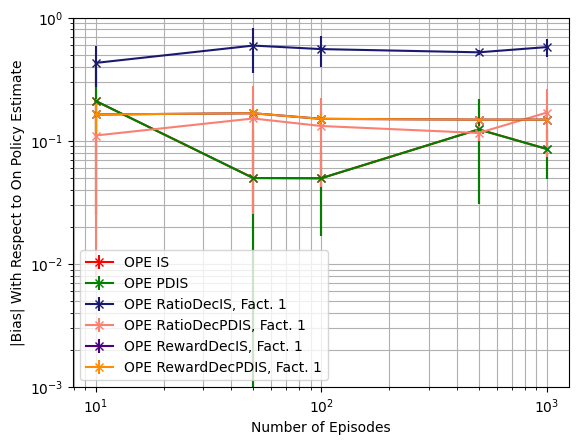

In [ ]:
label = 'bias'
plot_graphs(bias_means, bias_stds, label, 10**-3, 10**0, shorter_D, factorisation=1)

OPE IS-----[0.21038808 0.04979866 0.04956478 0.12356795 0.08581272]
OPE PDIS-----[0.21038808 0.04979866 0.04956478 0.12356795 0.08581272]
OPE RatioDecIS, Fact. 2-----[0.35925543 0.24750555 0.25112927 0.24770919 0.22873338]
OPE RatioDecPDIS, Fact. 2-----[0.25307694 0.09962109 0.09236736 0.09810349 0.11553714]
OPE RewardDecIS, Fact. 2-----[0.16325976 0.16708966 0.15049245 0.14832885 0.14836054]
OPE RewardDecPDIS, Fact. 2-----[0.16325976 0.16708966 0.15049245 0.14832885 0.14836054]


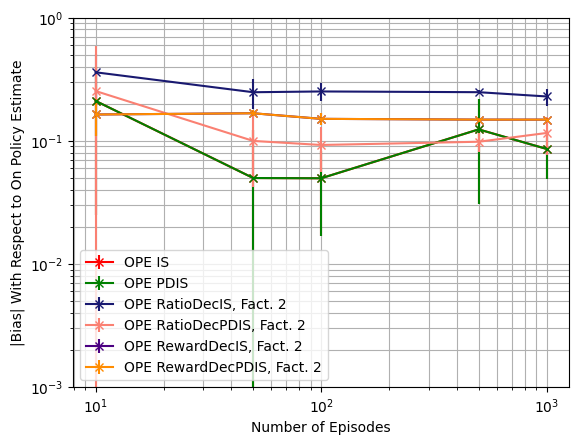

In [ ]:
plot_graphs(bias_means, bias_stds, label, 10**(-3), 10**0, shorter_D, factorisation=2)

OPE IS-----[0.21038808 0.04979866 0.04956478 0.12356795 0.08581272]
OPE PDIS-----[0.21038808 0.04979866 0.04956478 0.12356795 0.08581272]
OPE RatioDecIS, Fact. 3-----[0.1963299  0.19408154 0.1910385  0.15570107 0.16295713]
OPE RatioDecPDIS, Fact. 3-----[0.08740165 0.08626724 0.11717566 0.18057117 0.1491162 ]
OPE RewardDecIS, Fact. 3-----[0.16325976 0.16708966 0.15049245 0.14832885 0.14836054]
OPE RewardDecPDIS, Fact. 3-----[0.16325976 0.16708966 0.15049245 0.14832885 0.14836054]


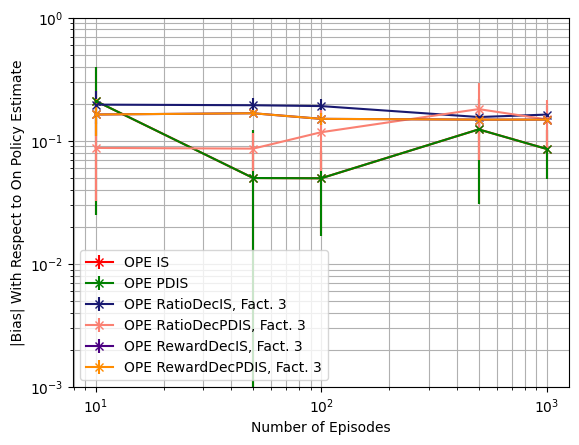

In [ ]:
plot_graphs(bias_means, bias_stds, label, 10**(-3), 10**0, shorter_D, factorisation=3)

OPE IS-----[0.21038808 0.04979866 0.04956478 0.12356795 0.08581272]
OPE PDIS-----[0.21038808 0.04979866 0.04956478 0.12356795 0.08581272]
OPE RatioDecIS, Fact. 4-----[0.15262359 0.23090074 0.19981733 0.18318144 0.18721467]
OPE RatioDecPDIS, Fact. 4-----[0.10479254 0.16869396 0.14708877 0.14288027 0.14583977]
OPE RewardDecIS, Fact. 4-----[0.36825738 0.37659924 0.36286773 0.36252352 0.36230324]
OPE RewardDecPDIS, Fact. 4-----[0.36825738 0.37659924 0.36286773 0.36252352 0.36230324]


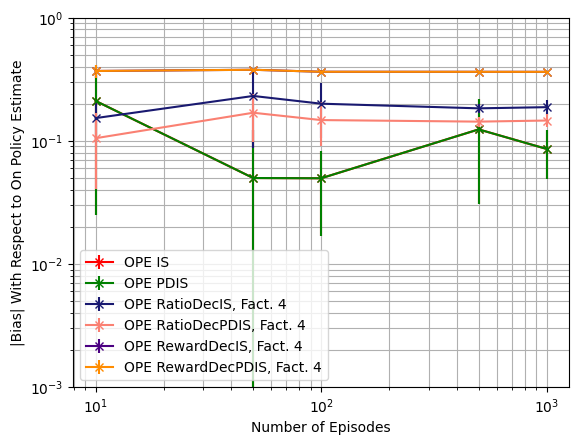

In [ ]:
plot_graphs(bias_means, bias_stds, label, 10**(-3), 10**0, shorter_D, factorisation=4)

##### Plot Variance

On Policy-----[0.02237518 0.00517436 0.00263435 0.00046854 0.0002364 ]
OPE IS-----[1.28867162 0.17311292 0.07200112 0.26859441 0.06994207]
OPE PDIS-----[1.28867162 0.17311292 0.07200112 0.26859441 0.06994207]
OPE RatioDecIS, Fact. 1-----[0.56700173 1.64357747 0.43829287 0.04098515 0.20797875]
OPE RatioDecPDIS, Fact. 1-----[0.21153188 0.5114471  0.13796686 0.01463106 0.16428256]
OPE RewardDecIS, Fact. 1-----[0.03646733 0.00706123 0.00413719 0.00112209 0.00047278]
OPE RewardDecPDIS, Fact. 1-----[0.03646733 0.00706123 0.00413719 0.00112209 0.00047278]


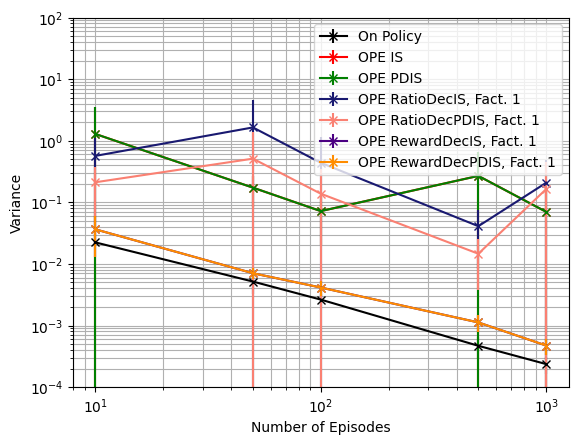

In [ ]:
label = 'var'
plot_graphs(var_means, var_stds, label, 10**(-4), 10**2, shorter_D, factorisation=1)

On Policy-----[0.02237518 0.00517436 0.00263435 0.00046854 0.0002364 ]
OPE IS-----[1.28867162 0.17311292 0.07200112 0.26859441 0.06994207]
OPE PDIS-----[1.28867162 0.17311292 0.07200112 0.26859441 0.06994207]
OPE RatioDecIS, Fact. 2-----[2.09787753 0.11921559 0.04769177 0.00851886 0.0203138 ]
OPE RatioDecPDIS, Fact. 2-----[2.15780107 0.13425907 0.05406247 0.01099625 0.02142219]
OPE RewardDecIS, Fact. 2-----[0.03646733 0.00706123 0.00413719 0.00112209 0.00047278]
OPE RewardDecPDIS, Fact. 2-----[0.03646733 0.00706123 0.00413719 0.00112209 0.00047278]


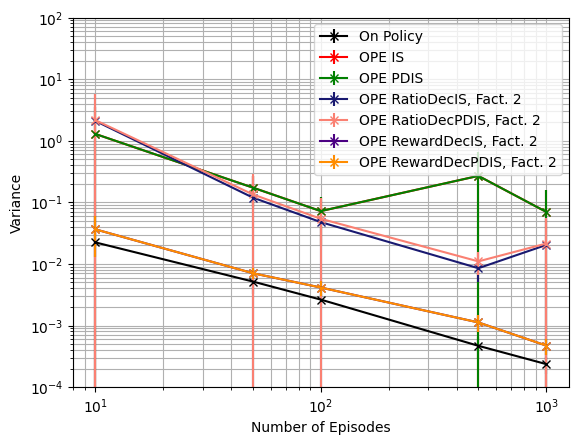

In [ ]:
plot_graphs(var_means, var_stds, label, 10**(-4), 10**2, shorter_D, factorisation=2)

On Policy-----[0.02237518 0.00517436 0.00263435 0.00046854 0.0002364 ]
OPE IS-----[1.28867162 0.17311292 0.07200112 0.26859441 0.06994207]
OPE PDIS-----[1.28867162 0.17311292 0.07200112 0.26859441 0.06994207]
OPE RatioDecIS, Fact. 3-----[0.11995872 0.03634945 0.02524419 0.03242375 0.00927143]
OPE RatioDecPDIS, Fact. 3-----[0.37788291 0.07250952 0.12447901 0.30367863 0.07740699]
OPE RewardDecIS, Fact. 3-----[0.03646733 0.00706123 0.00413719 0.00112209 0.00047278]
OPE RewardDecPDIS, Fact. 3-----[0.03646733 0.00706123 0.00413719 0.00112209 0.00047278]


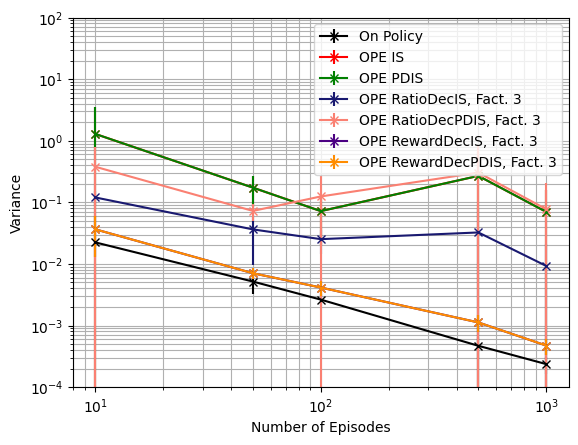

In [ ]:
plot_graphs(var_means, var_stds, label, 10**(-4), 10**2, shorter_D, factorisation=3)

On Policy-----[0.02237518 0.00517436 0.00263435 0.00046854 0.0002364 ]
OPE IS-----[1.28867162 0.17311292 0.07200112 0.26859441 0.06994207]
OPE PDIS-----[1.28867162 0.17311292 0.07200112 0.26859441 0.06994207]
OPE RatioDecIS, Fact. 4-----[0.28659935 0.73552452 0.20508942 0.01791879 0.02393325]
OPE RatioDecPDIS, Fact. 4-----[0.16778734 0.23654697 0.06999145 0.00902559 0.00893796]
OPE RewardDecIS, Fact. 4-----[0.0162077  0.00313833 0.00183875 0.00049871 0.00021013]
OPE RewardDecPDIS, Fact. 4-----[0.0162077  0.00313833 0.00183875 0.00049871 0.00021013]


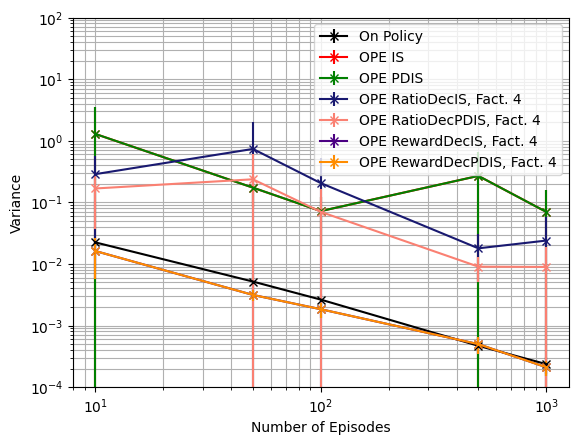

In [ ]:
plot_graphs(var_means, var_stds, label, 10**(-4), 10**2, shorter_D, factorisation=4)

##### Plot MSE

On Policy-----[0.02237518 0.00517436 0.00263435 0.00046854 0.0002364 ]
OPE IS-----[1.36740071 0.18073808 0.07552517 0.29253375 0.07866687]
OPE PDIS-----[1.36740071 0.18073808 0.07552517 0.29253375 0.07866687]
OPE RatioDecIS, Fact. 1-----[0.7748943  2.05000822 0.77009227 0.31401437 0.54762553]
OPE RatioDecPDIS, Fact. 1-----[0.23416051 0.5503387  0.16335076 0.02825196 0.20201286]
OPE RewardDecIS, Fact. 1-----[0.065933   0.03507025 0.02709405 0.02313931 0.02250288]
OPE RewardDecPDIS, Fact. 1-----[0.065933   0.03507025 0.02709405 0.02313931 0.02250288]


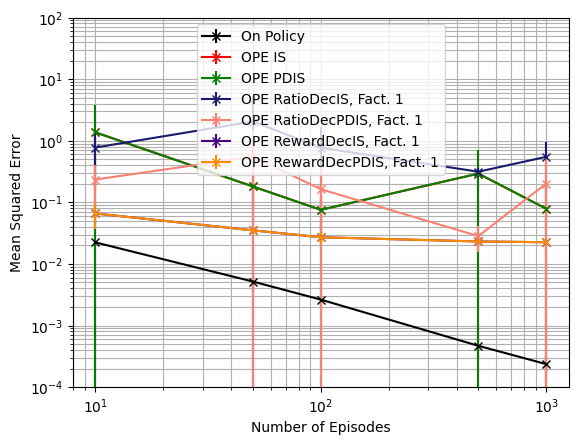

In [ ]:
label = 'MSE'
plot_graphs(MSE_means, MSE_stds, label, 10**(-4), 10**2, shorter_D, factorisation=1)

On Policy-----[0.02237518 0.00517436 0.00263435 0.00046854 0.0002364 ]
OPE IS-----[1.36740071 0.18073808 0.07552517 0.29253375 0.07866687]
OPE PDIS-----[1.36740071 0.18073808 0.07552517 0.29253375 0.07866687]
OPE RatioDecIS, Fact. 2-----[2.24735351 0.18505343 0.11249113 0.0699848  0.07391032]
OPE RatioDecPDIS, Fact. 2-----[2.33370283 0.14752106 0.0639613  0.02092974 0.03628121]
OPE RewardDecIS, Fact. 2-----[0.065933   0.03507025 0.02709405 0.02313931 0.02250288]
OPE RewardDecPDIS, Fact. 2-----[0.065933   0.03507025 0.02709405 0.02313931 0.02250288]


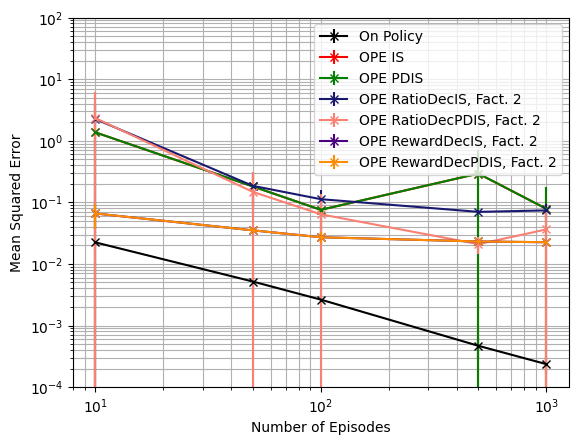

In [ ]:
plot_graphs(MSE_means, MSE_stds, label, 10**(-4), 10**2, shorter_D, factorisation=2)

On Policy-----[0.02237518 0.00517436 0.00263435 0.00046854 0.0002364 ]
OPE IS-----[1.36740071 0.18073808 0.07552517 0.29253375 0.07866687]
OPE PDIS-----[1.36740071 0.18073808 0.07552517 0.29253375 0.07866687]
OPE RatioDecIS, Fact. 3-----[0.16197848 0.07486441 0.06238092 0.0585104  0.03654892]
OPE RatioDecPDIS, Fact. 3-----[0.38852472 0.08080661 0.14181118 0.34856564 0.10362008]
OPE RewardDecIS, Fact. 3-----[0.065933   0.03507025 0.02709405 0.02313931 0.02250288]
OPE RewardDecPDIS, Fact. 3-----[0.065933   0.03507025 0.02709405 0.02313931 0.02250288]


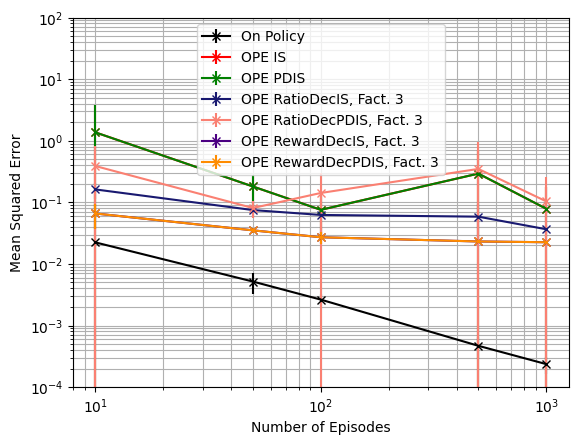

In [ ]:
plot_graphs(MSE_means, MSE_stds, label, 10**(-4), 10**2, shorter_D, factorisation=3)

On Policy-----[0.02237518 0.00517436 0.00263435 0.00046854 0.0002364 ]
OPE IS-----[1.36740071 0.18073808 0.07552517 0.29253375 0.07866687]
OPE PDIS-----[1.36740071 0.18073808 0.07552517 0.29253375 0.07866687]
OPE RatioDecIS, Fact. 4-----[0.31317949 0.80958197 0.25387216 0.05172349 0.05967495]
OPE RatioDecPDIS, Fact. 4-----[0.18289216 0.27010024 0.0949063  0.02961852 0.03051888]
OPE RewardDecIS, Fact. 4-----[0.15362022 0.14503776 0.13371055 0.13193316 0.13148581]
OPE RewardDecPDIS, Fact. 4-----[0.15362022 0.14503776 0.13371055 0.13193316 0.13148581]


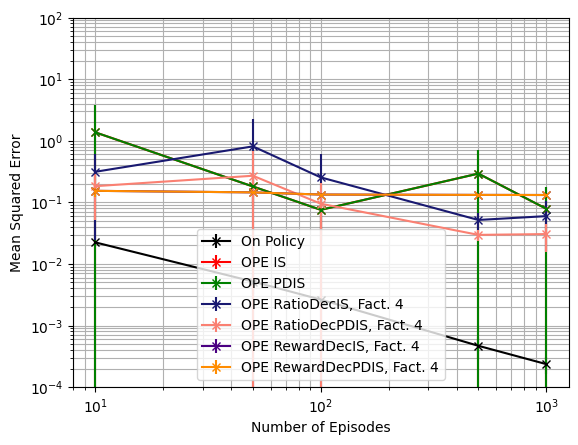

In [ ]:
plot_graphs(MSE_means, MSE_stds, label, 10**(-4), 10**2, shorter_D, factorisation=4)

##### Plot ESS

On Policy-----[  10.   50.  100.  500. 1000.]
OPE IS-----[ 1.39225442  2.21722233  4.83691683  5.56677512 10.65835208]
OPE PDIS-----[ 1.39225442  2.21722233  4.83691683  5.56677512 10.65835208]
OPE RatioDecIS, Fact. 1-----[ 0.76038005  2.0470798   4.26619764 11.9698012  18.44573322]
OPE RatioDecPDIS, Fact. 1-----[ 1.8095781   3.78379067  7.58768095 31.04065509 48.3765643 ]
OPE RewardDecIS, Fact. 1-----[  7.81474132  39.48455146  64.90274367 242.00691212 524.84240881]
OPE RewardDecPDIS, Fact. 1-----[  7.81474132  39.48455146  64.90274367 242.00691212 524.84240881]


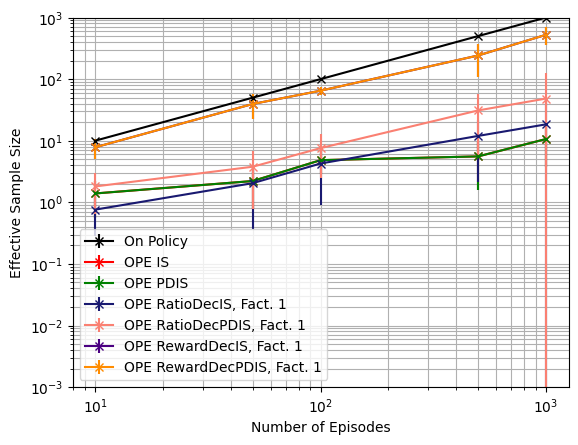

In [ ]:
label = 'ESS'
plot_graphs(ESS_means, ESS_stds, label, 10**(-3), 10**3, shorter_D, factorisation=1)

On Policy-----[  10.   50.  100.  500. 1000.]
OPE IS-----[ 1.39225442  2.21722233  4.83691683  5.56677512 10.65835208]
OPE PDIS-----[ 1.39225442  2.21722233  4.83691683  5.56677512 10.65835208]
OPE RatioDecIS, Fact. 2-----[ 2.25849539  7.70172747 14.05227524 33.77457799 65.12644377]
OPE RatioDecPDIS, Fact. 2-----[ 1.20494917  5.80394355 10.34800556 24.78608455 47.4519852 ]
OPE RewardDecIS, Fact. 2-----[  7.81474132  39.48455146  64.90274367 242.00691212 524.84240881]
OPE RewardDecPDIS, Fact. 2-----[  7.81474132  39.48455146  64.90274367 242.00691212 524.84240881]


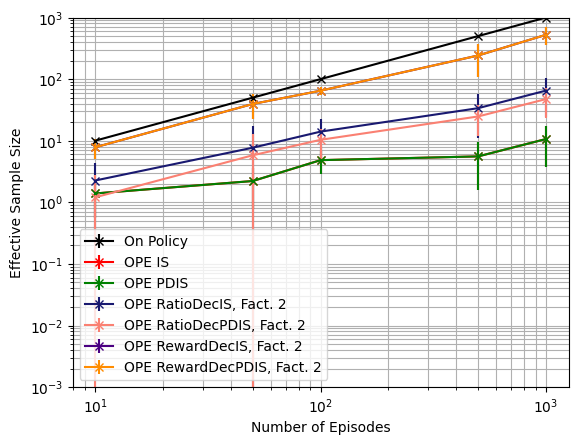

In [ ]:
plot_graphs(ESS_means, ESS_stds, label, 10**(-3), 10**3, shorter_D, factorisation=2)

On Policy-----[  10.   50.  100.  500. 1000.]
OPE IS-----[ 1.39225442  2.21722233  4.83691683  5.56677512 10.65835208]
OPE PDIS-----[ 1.39225442  2.21722233  4.83691683  5.56677512 10.65835208]
OPE RatioDecIS, Fact. 3-----[ 1.96245624 11.20447955 14.57067806 23.22233456 60.34402938]
OPE RatioDecPDIS, Fact. 3-----[ 1.14758841  3.60124188  5.5190607   7.93331668 14.62063846]
OPE RewardDecIS, Fact. 3-----[  7.81474132  39.48455146  64.90274367 242.00691212 524.84240881]
OPE RewardDecPDIS, Fact. 3-----[  7.81474132  39.48455146  64.90274367 242.00691212 524.84240881]


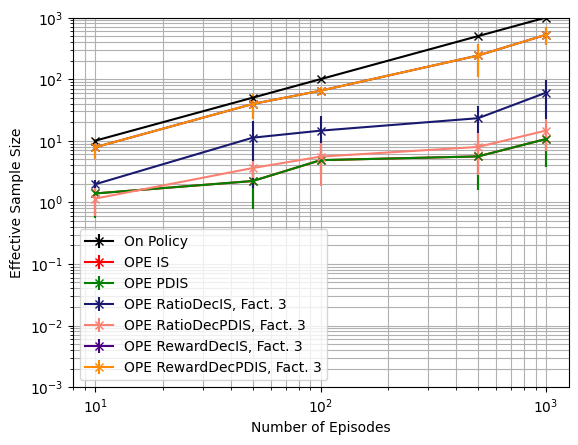

In [ ]:
plot_graphs(ESS_means, ESS_stds, label, 10**(-3), 10**3, shorter_D, factorisation=3)

On Policy-----[  10.   50.  100.  500. 1000.]
OPE IS-----[ 1.39225442  2.21722233  4.83691683  5.56677512 10.65835208]
OPE PDIS-----[ 1.39225442  2.21722233  4.83691683  5.56677512 10.65835208]
OPE RatioDecIS, Fact. 4-----[ 1.63668701  3.61479416  7.46965263 19.68275886 40.16373058]
OPE RatioDecPDIS, Fact. 4-----[ 2.12403064  4.9723967  10.6294184  29.42956383 52.17052074]
OPE RewardDecIS, Fact. 4-----[  17.58316797   88.84024078  146.03117325  544.51555227 1180.89541982]
OPE RewardDecPDIS, Fact. 4-----[  17.58316797   88.84024078  146.03117325  544.51555227 1180.89541982]


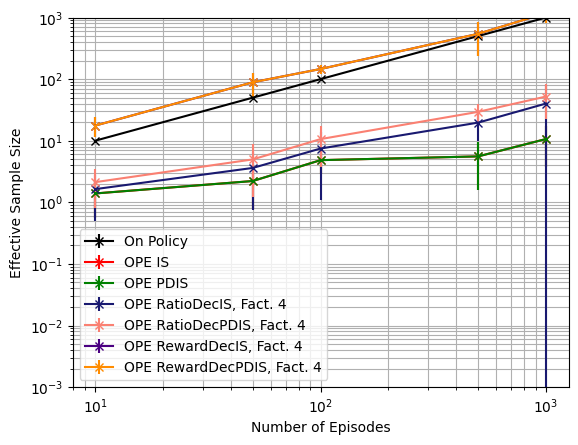

In [ ]:
plot_graphs(ESS_means, ESS_stds, label, 10**(-3), 10**3, shorter_D, factorisation=4)

### Varying Episodes $\epsilon_{e} = 0.6$ (Policy Divergence $3.2^{20}$)

Set up evaluation policy, generate data and convert into factored format

In [ ]:
EVAL_EPSILON = 0.6

evalPolSoft = np.copy(fullPol)
evalPolSoft[evalPolSoft == 1] = 1 - EVAL_EPSILON
evalPolSoft[evalPolSoft == 0] = EVAL_EPSILON / (n_actions - 1)

In [ ]:
# Calculate policy divergence from Voloshin et al.
D = 0
for state in range(randPol.shape[0] - 1):
    for action in range(randPol.shape[1] - 1):
        difference = evalPolSoft[state, action]/randPol[state, action]
        D = max(D, difference)
print(D)
shorter_D = round(D,2)

3.2


In [ ]:
dgen = DataGenerator()
states, actions, lengths, rewards, diab, emp_tx_totals, emp_r_totals = dgen.simulate(
    NSIMSAMPS, NSTEPS, policy=evalPolSoft, policy_idx_type='full',
    p_diabetes=PROB_DIAB, use_tqdm=False) #True, tqdm_desc='Behaviour Policy Simulation')

obs_samps = utils.format_dgen_samps(
    states, actions, rewards, diab, NSTEPS, NSIMSAMPS)

In [ ]:
time = np.arange(NSTEPS)
times = np.stack(axis=0, arrays=[time]*NSIMSAMPS)
times = times[..., np.newaxis]

nf_tr_e = np.concatenate((times, states[:, 0:NSTEPS, :], actions, rewards, states[:, 1:, :]), axis=2)
nf_tr_e.shape

(100000, 20, 5)

In [ ]:
f_tr_e1, f_tr_e2, f_tr_e3, f_tr_e4 = factorise_dataset(nf_tr_e)

In [ ]:
factored_evalPolSoft1 = factor_policy_1(evalPolSoft)
factored_evalPolSoft2 = factor_policy_2(evalPolSoft)
factored_evalPolSoft3 = factor_policy_3(evalPolSoft)
factored_evalPolSoft4 = factor_policy_4(evalPolSoft)

In [ ]:
evalPolSoft = pad_policy(evalPolSoft)

factored_evalPolSoft1[0] = pad_policy(factored_evalPolSoft1[0])
factored_evalPolSoft1[1] = pad_policy(factored_evalPolSoft1[1])

factored_evalPolSoft2[0] = pad_policy(factored_evalPolSoft2[0])
factored_evalPolSoft2[1] = pad_policy(factored_evalPolSoft2[1])

factored_evalPolSoft3[0] = pad_policy(factored_evalPolSoft3[0])
factored_evalPolSoft3[1] = pad_policy(factored_evalPolSoft3[1])

factored_evalPolSoft4[0] = pad_policy(factored_evalPolSoft4[0])
factored_evalPolSoft4[1] = pad_policy(factored_evalPolSoft4[1])
factored_evalPolSoft4[2] = pad_policy(factored_evalPolSoft4[2])

In [ ]:
import policy_estimators as pe
import gc

def evaluate_PE(RUNS, EPISODES, SHORTER_D, STEPS=NSTEPS):

  biases = np.zeros((5, 20))
  variances = np.zeros((5, 20))
  MSEs = np.zeros((5, 20))
  ESSs = np.zeros((5, 20))

  # Reshape data for processing
  T, ldim = nf_tr_b.shape[-2], nf_tr_b.shape[-1]
  nfb = nf_tr_b.reshape((-1, RUNS, EPISODES, T, ldim))
  nfe = nf_tr_e.reshape((-1, RUNS, EPISODES, T, ldim))

  T, D1, ldim = f_tr_b1.shape[-3], f_tr_b1.shape[-2], f_tr_b1.shape[-1]
  fb1 = f_tr_b1.reshape((-1, RUNS, EPISODES, T, D1, ldim))
  fe1 = f_tr_e1.reshape((-1, RUNS, EPISODES, T, D1, ldim))

  T, D2, ldim = f_tr_b2.shape[-3], f_tr_b2.shape[-2], f_tr_b2.shape[-1]
  fb2 = f_tr_b2.reshape((-1, RUNS, EPISODES, T, D2, ldim))
  fe2 = f_tr_e2.reshape((-1, RUNS, EPISODES, T, D2, ldim))

  T, D3, ldim = f_tr_b3.shape[-3], f_tr_b3.shape[-2], f_tr_b3.shape[-1]
  fb3 = f_tr_b3.reshape((-1, RUNS, EPISODES, T, D3, ldim))
  fe3 = f_tr_e3.reshape((-1, RUNS, EPISODES, T, D3, ldim))

  T, D4, ldim = f_tr_b4.shape[-3], f_tr_b4.shape[-2], f_tr_b4.shape[-1]
  fb4 = f_tr_b4.reshape((-1, RUNS, EPISODES, T, D4, ldim))
  fe4 = f_tr_e4.reshape((-1, RUNS, EPISODES, T, D4, ldim))

  for t in range(5):
    print()

    lower_index = 0
    estimates_on_policy = np.zeros(RUNS)
    estimates_OPE_IS = np.zeros(RUNS)
    estimates_OPE_PDIS = np.zeros(RUNS)
    estimates_OPE_PDWIS = np.zeros(RUNS)

    estimates_OPE_RatioDecIS1 = np.zeros(RUNS)
    estimates_OPE_RatioDecPDIS1 = np.zeros(RUNS)
    estimates_OPE_RewardDecIS1 = np.zeros(RUNS)
    estimates_OPE_RewardDecPDIS1 = np.zeros(RUNS)

    estimates_OPE_RatioDecIS2 = np.zeros(RUNS)
    estimates_OPE_RatioDecPDIS2 = np.zeros(RUNS)
    estimates_OPE_RewardDecIS2 = np.zeros(RUNS)
    estimates_OPE_RewardDecPDIS2 = np.zeros(RUNS)

    estimates_OPE_RatioDecIS3 = np.zeros(RUNS)
    estimates_OPE_RatioDecPDIS3 = np.zeros(RUNS)
    estimates_OPE_RewardDecIS3 = np.zeros(RUNS)
    estimates_OPE_RewardDecPDIS3 = np.zeros(RUNS)

    estimates_OPE_RatioDecIS4 = np.zeros(RUNS)
    estimates_OPE_RatioDecPDIS4 = np.zeros(RUNS)
    estimates_OPE_RewardDecIS4 = np.zeros(RUNS)
    estimates_OPE_RewardDecPDIS4 = np.zeros(RUNS)

    for r in range(RUNS):
        #On policy Q estimate
        estimates_on_policy[r] = pe.on_policy_Q_estimate(nfe[t, r, :, :STEPS, :], DISCOUNT_Pol)
        #Off policy IS estimate
        estimates_OPE_IS[r] = pe.off_policy_IS_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, randPol, evalPolSoft)
        #Off policy PDIS estimate
        estimates_OPE_PDIS[r] = pe.off_policy_PDIS_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, randPol, evalPolSoft)
        #Off policy PDWIS estimate
        estimates_OPE_PDWIS[r] = pe.off_policy_PDWIS_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, randPol, evalPolSoft)

        #Factorisation 1----------------------------------

        #Off policy half decomposed IS estimate
        estimates_OPE_RatioDecIS1[r] = off_policy_RatioDecIS_estimator(nfb[t, r, :, :STEPS, :], fb1[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol1, factored_evalPolSoft1)
        #Off policy half decomposed PDIS estimate
        estimates_OPE_RatioDecPDIS1[r] = off_policy_RatioDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb1[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol1, factored_evalPolSoft1)
        #Off policy half decomposed IS estimate
        estimates_OPE_RewardDecIS1[r] = off_policy_RewardDecIS_estimator(nfb[t, r, :, :STEPS, :], fb1[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)
        #Off policy half decomposed PDIS estimate
        estimates_OPE_RewardDecPDIS1[r] = off_policy_RewardDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb1[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)

        #Factorisation 2----------------------------------

        #Off policy half decomposed IS estimate
        estimates_OPE_RatioDecIS2[r] = off_policy_RatioDecIS_estimator(nfb[t, r, :, :STEPS, :], fb2[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol2, factored_evalPolSoft2)
        #Off policy half decomposed PDIS estimate
        estimates_OPE_RatioDecPDIS2[r] = off_policy_RatioDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb2[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol2, factored_evalPolSoft2)
        #Off policy half decomposed IS estimate
        estimates_OPE_RewardDecIS2[r] = off_policy_RewardDecIS_estimator(nfb[t, r, :, :STEPS, :], fb2[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)
        #Off policy half decomposed PDIS estimate
        estimates_OPE_RewardDecPDIS2[r] = off_policy_RewardDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb2[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)

        #Factorisation 3----------------------------------

        #Off policy decomposed IS estimate
        estimates_OPE_RatioDecIS3[r] = off_policy_RatioDecIS_estimator(nfb[t, r, :, :STEPS, :], fb3[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol3, factored_evalPolSoft3)
        #Off policy decomposed PDIS estimate
        estimates_OPE_RatioDecPDIS3[r] = off_policy_RatioDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb3[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol3, factored_evalPolSoft3)
        #Off policy half decomposed IS estimate
        estimates_OPE_RewardDecIS3[r] = off_policy_RewardDecIS_estimator(nfb[t, r, :, :STEPS, :], fb3[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)
        #Off policy half decomposed PDIS estimate
        estimates_OPE_RewardDecPDIS3[r] = off_policy_RewardDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb3[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)

        #Factorisation 4----------------------------------

        #Off policy decomposed IS estimate
        estimates_OPE_RatioDecIS4[r] = off_policy_RatioDecIS_estimator(nfb[t, r, :, :STEPS, :], fb4[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1,2], factored_randPol4, factored_evalPolSoft4)
        #Off policy decomposed PDIS estimate
        estimates_OPE_RatioDecPDIS4[r] = off_policy_RatioDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb4[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1,2], factored_randPol4, factored_evalPolSoft4)
        #Off policy half decomposed IS estimate
        estimates_OPE_RewardDecIS4[r] = off_policy_RewardDecIS_estimator(nfb[t, r, :, :STEPS, :], fb4[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)
        #Off policy half decomposed PDIS estimate
        estimates_OPE_RewardDecPDIS4[r] = off_policy_RewardDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb4[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)

    mean_on_policy = np.mean(estimates_on_policy)
    var_on_policy = np.var(estimates_on_policy, ddof=0)
    print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

    from sklearn.metrics import mean_squared_error

    #For on policy
    biases[t, 0] = 0.0
    variances[t, 0] = var_on_policy
    MSEs[t, 0] = var_on_policy
    ESSs[t, 0] = EPISODES

    def generate_results(estimates, mean_true, label):
      MSE = mean_squared_error(estimates, [mean_true]*RUNS)
      mean = np.mean(estimates)
      var = np.var(estimates, ddof=0)
      bias1 = np.sqrt(MSE - var)
      bias2 = abs(mean - mean_true)
      print(f'Mean {label} estimate: {mean}. Bias1: {bias1}. Bias2: {bias2}. Variance: {var}. MSE: {MSE}')
      return bias1, var, MSE

    label_list = ['OPE IS', 'OPE PDIS', 'OPE PDWIS',
                  'OPE RatioDecIS: Fact. 1', 'OPE RatioDecPDIS: Fact. 1',
                  'OPE RewardDecIS: Fact. 1', 'OPE RewardDecPDIS: Fact. 1',
                  'OPE RatioDecIS: Fact. 2', 'OPE RatioDecPDIS: Fact. 2',
                  'OPE RewardDecIS: Fact. 2', 'OPE RewardDecPDIS: Fact. 2',
                  'OPE RatioDecIS: Fact. 3', 'OPE RatioDecPDIS: Fact. 3',
                  'OPE RewardDecIS: Fact. 3', 'OPE RewardDecPDIS: Fact. 3',
                  'OPE RatioDecIS: Fact. 4', 'OPE RatioDecPDIS: Fact. 4',
                  'OPE RewardDecIS: Fact. 4', 'OPE RewardDecPDIS: Fact. 4'
                  ]

    estimates = [estimates_OPE_IS, estimates_OPE_PDIS, estimates_OPE_PDWIS,
                estimates_OPE_RatioDecIS1, estimates_OPE_RatioDecPDIS1,
                estimates_OPE_RewardDecIS1, estimates_OPE_RewardDecPDIS1,
                estimates_OPE_RatioDecIS2, estimates_OPE_RatioDecPDIS2,
                estimates_OPE_RewardDecIS2, estimates_OPE_RewardDecPDIS2,
                estimates_OPE_RatioDecIS3, estimates_OPE_RatioDecPDIS3,
                estimates_OPE_RewardDecIS3, estimates_OPE_RewardDecPDIS3,
                estimates_OPE_RatioDecIS4, estimates_OPE_RatioDecPDIS4,
                estimates_OPE_RewardDecIS4, estimates_OPE_RewardDecPDIS4,
                ]


    for (id, val) in enumerate(label_list):
      biases[t, 1+id], variances[t, 1+id], MSEs[t, 1+id] = generate_results(estimates[id], mean_on_policy, label_list[id])
      ESSs[t, 1+id] = (EPISODES*variances[t, 0])/variances[t, 1+id]
      gc.collect()

  return np.mean(biases, axis=0), np.std(biases, axis=0), np.mean(variances, axis=0), np.std(variances, axis=0), np.mean(MSEs, axis=0), np.std(MSEs, axis=0), np.mean(ESSs, axis=0), np.std(ESSs, axis=0)

#### Run Everything

In [ ]:
EPISODES = [10, 50, 100, 500, 1000]

bias_means = np.zeros((len(EPISODES), 20))
bias_stds = np.zeros((len(EPISODES), 20))
var_means = np.zeros((len(EPISODES), 20))
var_stds = np.zeros((len(EPISODES), 20))
MSE_means = np.zeros((len(EPISODES), 20))
MSE_stds = np.zeros((len(EPISODES), 20))
ESS_means = np.zeros((len(EPISODES), 20))
ESS_stds = np.zeros((len(EPISODES), 20))

RUNS = 20

for id in range(len(EPISODES)):
  e = EPISODES[id]
  print(f'{e} Episodes, {RUNS} ----------------------------------')
  bias_means[id, :], bias_stds[id, :], var_means[id, :], var_stds[id, :], MSE_means[id, :], MSE_stds[id, :], ESS_means[id, :], ESS_stds[id, :] = evaluate_PE(RUNS=RUNS, EPISODES=e, SHORTER_D=shorter_D)
  print()
  gc.collect()

print('BIAS MEANS')
print(list(bias_means))
print('\nBIAS STDS')
print(list(bias_stds))
print('\nVAR MEANS')
print(list(var_means))
print('\nVAR STDS')
print(list(var_stds))
print('\nMSE MEANS')
print(list(MSE_means))
print('\nMSE STDS')
print(list(MSE_stds))
print('\nESS MEANS')
print(list(ESS_means))
print('\nESS STDS')
print(list(ESS_stds))

10 Episodes, 20 ----------------------------------

Mean on policy Q estimate: -0.8898053979041014. Variance of on policy Q estimate: 0.009210234938231539
Mean OPE IS estimate: -0.7647220624140494. Bias1: 0.12508333549005202. Bias2: 0.12508333549005202. Variance: 0.025779822038478943. MSE: 0.04142566285579585
Mean OPE PDIS estimate: -0.7647220624140494. Bias1: 0.12508333549005202. Bias2: 0.12508333549005202. Variance: 0.025779822038478943. MSE: 0.04142566285579585
Mean OPE PDWIS estimate: -0.047384061445353905. Bias1: 0.8424213364587475. Bias2: 0.8424213364587475. Variance: 6.950567650132465e-06. MSE: 0.7096806586885923
Mean OPE RatioDecIS: Fact. 1 estimate: -1.1132062481607312. Bias1: 0.22340085025662978. Bias2: 0.2234008502566298. Variance: 0.07917220386494077. MSE: 0.1290801437603259
Mean OPE RatioDecPDIS: Fact. 1 estimate: -0.8168208503509569. Bias1: 0.0729845475531446. Bias2: 0.07298454755314454. Variance: 0.03671277612453852. MSE: 0.042039520306075745
Mean OPE RewardDecIS: Fact. 

#### Plot Graphs

##### Plot Bias

OPE IS-----[0.10878988 0.03227395 0.02434353 0.04708222 0.03079822]
OPE PDIS-----[0.10878988 0.03227395 0.02434353 0.04708222 0.03079822]
OPE RatioDecIS, Fact. 1-----[0.2829284  0.36226458 0.34992344 0.35578938 0.36187619]
OPE RatioDecPDIS, Fact. 1-----[0.07855101 0.05060784 0.03263383 0.04113627 0.04832962]
OPE RewardDecIS, Fact. 1-----[0.09909644 0.09049555 0.08751281 0.07853687 0.07917546]
OPE RewardDecPDIS, Fact. 1-----[0.09909644 0.09049555 0.08751281 0.07853687 0.07917546]


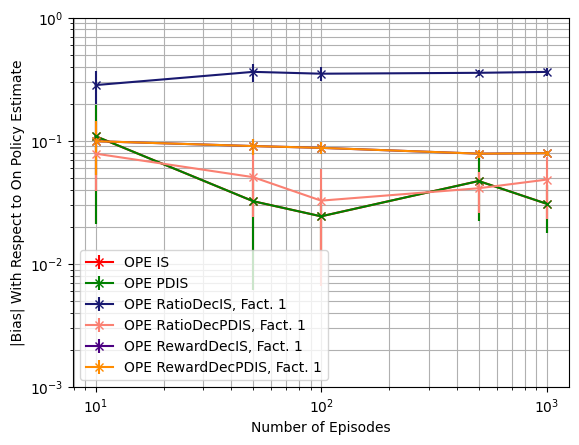

In [ ]:
label = 'bias'
plot_graphs(bias_means, bias_stds, label, 10**-3, 10**0, shorter_D, factorisation=1)

OPE IS-----[0.10878988 0.03227395 0.02434353 0.04708222 0.03079822]
OPE PDIS-----[0.10878988 0.03227395 0.02434353 0.04708222 0.03079822]
OPE RatioDecIS, Fact. 2-----[0.25493983 0.24555404 0.24496147 0.23934884 0.22410522]
OPE RatioDecPDIS, Fact. 2-----[0.11708258 0.03259087 0.02604529 0.03208276 0.04570681]
OPE RewardDecIS, Fact. 2-----[0.09909644 0.09049555 0.08751281 0.07853687 0.07917546]
OPE RewardDecPDIS, Fact. 2-----[0.09909644 0.09049555 0.08751281 0.07853687 0.07917546]


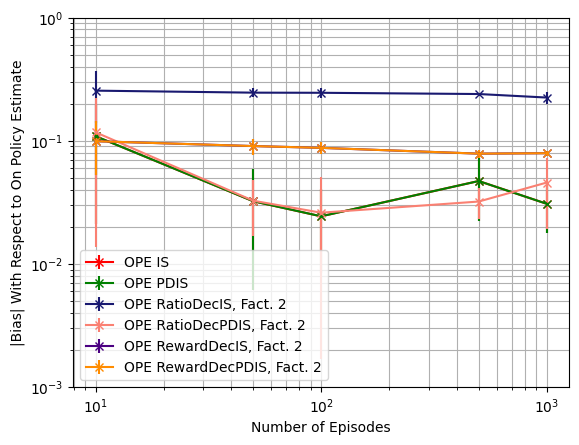

In [ ]:
plot_graphs(bias_means, bias_stds, label, 10**(-3), 10**0, shorter_D, factorisation=2)

OPE IS-----[0.10878988 0.03227395 0.02434353 0.04708222 0.03079822]
OPE PDIS-----[0.10878988 0.03227395 0.02434353 0.04708222 0.03079822]
OPE RatioDecIS, Fact. 3-----[0.18329062 0.16653223 0.16289761 0.13861708 0.14579347]
OPE RatioDecPDIS, Fact. 3-----[0.05268498 0.02702628 0.03761265 0.06729972 0.05050544]
OPE RewardDecIS, Fact. 3-----[0.09909644 0.09049555 0.08751281 0.07853687 0.07917546]
OPE RewardDecPDIS, Fact. 3-----[0.09909644 0.09049555 0.08751281 0.07853687 0.07917546]


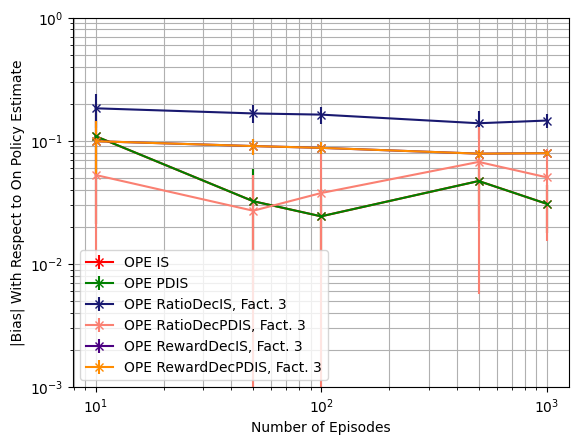

In [ ]:
plot_graphs(bias_means, bias_stds, label, 10**(-3), 10**0, shorter_D, factorisation=3)

OPE IS-----[0.10878988 0.03227395 0.02434353 0.04708222 0.03079822]
OPE PDIS-----[0.10878988 0.03227395 0.02434353 0.04708222 0.03079822]
OPE RatioDecIS, Fact. 4-----[0.0412726  0.08094254 0.06982223 0.07773573 0.07775173]
OPE RatioDecPDIS, Fact. 4-----[0.03776074 0.04904863 0.038967   0.0489214  0.04859537]
OPE RewardDecIS, Fact. 4-----[0.36525934 0.35854692 0.35702972 0.34946443 0.34986583]
OPE RewardDecPDIS, Fact. 4-----[0.36525934 0.35854692 0.35702972 0.34946443 0.34986583]


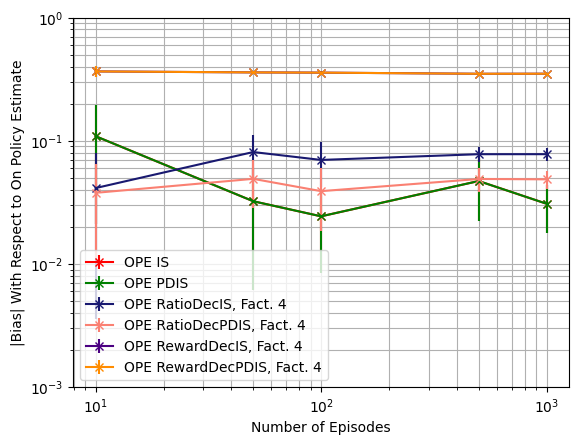

In [ ]:
plot_graphs(bias_means, bias_stds, label, 10**(-3), 10**0, shorter_D, factorisation=4)

##### Plot Variance

On Policy-----[0.00999531 0.00249587 0.00114636 0.0001953  0.00011899]
OPE IS-----[0.33750922 0.03494886 0.02023639 0.02785579 0.00927645]
OPE PDIS-----[0.33750922 0.03494886 0.02023639 0.02785579 0.00927645]
OPE RatioDecIS, Fact. 1-----[0.15735192 0.16336267 0.05309555 0.00712255 0.01320447]
OPE RatioDecPDIS, Fact. 1-----[0.0764739  0.06732794 0.02366689 0.00338855 0.00979987]
OPE RewardDecIS, Fact. 1-----[0.02153844 0.00378065 0.0022786  0.00061143 0.00030484]
OPE RewardDecPDIS, Fact. 1-----[0.02153844 0.00378065 0.0022786  0.00061143 0.00030484]


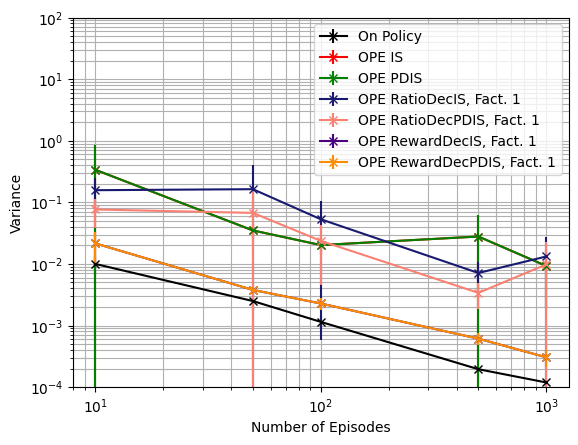

In [ ]:
label = 'var'
plot_graphs(var_means, var_stds, label, 10**(-4), 10**2, shorter_D, factorisation=1)

On Policy-----[0.00999531 0.00249587 0.00114636 0.0001953  0.00011899]
OPE IS-----[0.33750922 0.03494886 0.02023639 0.02785579 0.00927645]
OPE PDIS-----[0.33750922 0.03494886 0.02023639 0.02785579 0.00927645]
OPE RatioDecIS, Fact. 2-----[0.2432477  0.02537491 0.01624175 0.00270152 0.01204298]
OPE RatioDecPDIS, Fact. 2-----[0.27593293 0.02995202 0.01872324 0.00409669 0.01259022]
OPE RewardDecIS, Fact. 2-----[0.02153844 0.00378065 0.0022786  0.00061143 0.00030484]
OPE RewardDecPDIS, Fact. 2-----[0.02153844 0.00378065 0.0022786  0.00061143 0.00030484]


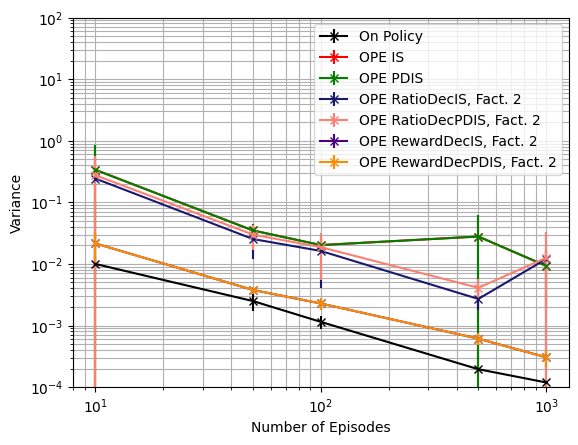

In [ ]:
plot_graphs(var_means, var_stds, label, 10**(-4), 10**2, shorter_D, factorisation=2)

On Policy-----[0.00999531 0.00249587 0.00114636 0.0001953  0.00011899]
OPE IS-----[0.33750922 0.03494886 0.02023639 0.02785579 0.00927645]
OPE PDIS-----[0.33750922 0.03494886 0.02023639 0.02785579 0.00927645]
OPE RatioDecIS, Fact. 3-----[0.08144962 0.01493745 0.02088413 0.02235239 0.00605619]
OPE RatioDecPDIS, Fact. 3-----[0.14854299 0.02364763 0.06386211 0.07782501 0.01959873]
OPE RewardDecIS, Fact. 3-----[0.02153844 0.00378065 0.0022786  0.00061143 0.00030484]
OPE RewardDecPDIS, Fact. 3-----[0.02153844 0.00378065 0.0022786  0.00061143 0.00030484]


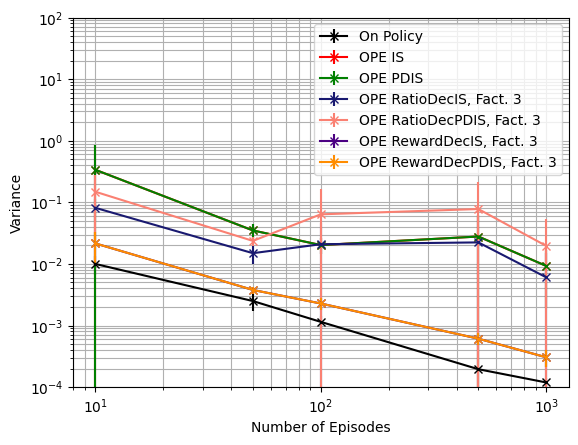

In [ ]:
plot_graphs(var_means, var_stds, label, 10**(-4), 10**2, shorter_D, factorisation=3)

On Policy-----[0.00999531 0.00249587 0.00114636 0.0001953  0.00011899]
OPE IS-----[0.33750922 0.03494886 0.02023639 0.02785579 0.00927645]
OPE PDIS-----[0.33750922 0.03494886 0.02023639 0.02785579 0.00927645]
OPE RatioDecIS, Fact. 4-----[0.08478782 0.07432171 0.02554563 0.00356028 0.00242147]
OPE RatioDecPDIS, Fact. 4-----[0.06625397 0.03376227 0.01301377 0.0025909  0.00146499]
OPE RewardDecIS, Fact. 4-----[0.00957264 0.00168029 0.00101271 0.00027175 0.00013549]
OPE RewardDecPDIS, Fact. 4-----[0.00957264 0.00168029 0.00101271 0.00027175 0.00013549]


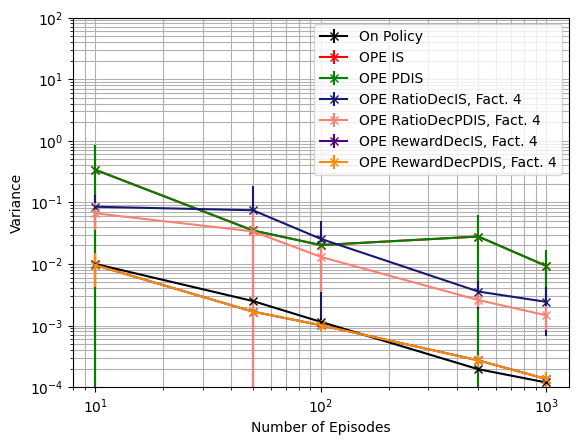

In [ ]:
plot_graphs(var_means, var_stds, label, 10**(-4), 10**2, shorter_D, factorisation=4)

##### Plot MSE

On Policy-----[0.00999531 0.00249587 0.00114636 0.0001953  0.00011899]
OPE IS-----[0.35704991 0.03667588 0.02108162 0.0306924  0.01039001]
OPE PDIS-----[0.35704991 0.03667588 0.02108162 0.0306924  0.01039001]
OPE RatioDecIS, Fact. 1-----[0.24451872 0.29817405 0.17754927 0.13410506 0.14488379]
OPE RatioDecPDIS, Fact. 1-----[0.08418737 0.07060661 0.0254065  0.00530729 0.01277189]
OPE RewardDecIS, Fact. 1-----[0.03353334 0.01214979 0.01003672 0.00681127 0.00658736]
OPE RewardDecPDIS, Fact. 1-----[0.03353334 0.01214979 0.01003672 0.00681127 0.00658736]


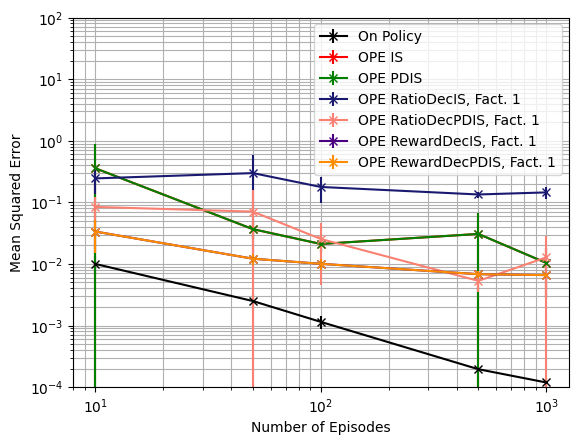

In [ ]:
label = 'MSE'
plot_graphs(MSE_means, MSE_stds, label, 10**(-4), 10**2, shorter_D, factorisation=1)

On Policy-----[0.00999531 0.00249587 0.00114636 0.0001953  0.00011899]
OPE IS-----[0.35704991 0.03667588 0.02108162 0.0306924  0.01039001]
OPE PDIS-----[0.35704991 0.03667588 0.02108162 0.0306924  0.01039001]
OPE RatioDecIS, Fact. 2-----[0.32147428 0.08609077 0.07672126 0.06001896 0.06291   ]
OPE RatioDecPDIS, Fact. 2-----[0.30030575 0.03126499 0.01999422 0.00520466 0.01538077]
OPE RewardDecIS, Fact. 2-----[0.03353334 0.01214979 0.01003672 0.00681127 0.00658736]
OPE RewardDecPDIS, Fact. 2-----[0.03353334 0.01214979 0.01003672 0.00681127 0.00658736]


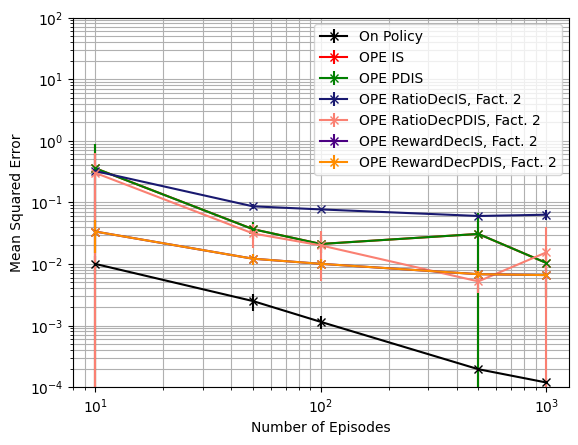

In [ ]:
plot_graphs(MSE_means, MSE_stds, label, 10**(-4), 10**2, shorter_D, factorisation=2)

On Policy-----[0.00999531 0.00249587 0.00114636 0.0001953  0.00011899]
OPE IS-----[0.35704991 0.03667588 0.02108162 0.0306924  0.01039001]
OPE PDIS-----[0.35704991 0.03667588 0.02108162 0.0306924  0.01039001]
OPE RatioDecIS, Fact. 3-----[0.11822551 0.04347534 0.04807898 0.04277897 0.02770431]
OPE RatioDecPDIS, Fact. 3-----[0.15304259 0.02506098 0.06739269 0.08614961 0.02337899]
OPE RewardDecIS, Fact. 3-----[0.03353334 0.01214979 0.01003672 0.00681127 0.00658736]
OPE RewardDecPDIS, Fact. 3-----[0.03353334 0.01214979 0.01003672 0.00681127 0.00658736]


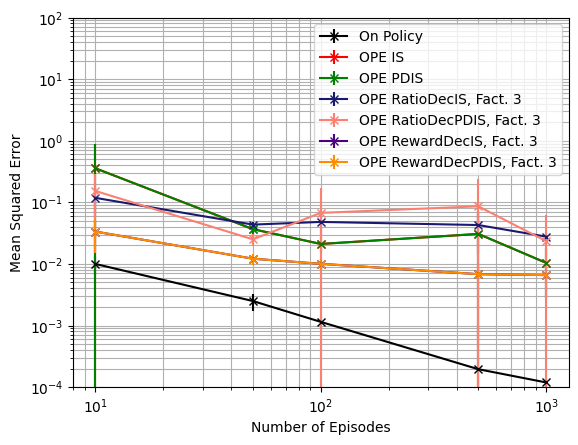

In [ ]:
plot_graphs(MSE_means, MSE_stds, label, 10**(-4), 10**2, shorter_D, factorisation=3)

On Policy-----[0.00999531 0.00249587 0.00114636 0.0001953  0.00011899]
OPE IS-----[0.35704991 0.03667588 0.02108162 0.0306924  0.01039001]
OPE PDIS-----[0.35704991 0.03667588 0.02108162 0.0306924  0.01039001]
OPE RatioDecIS, Fact. 4-----[0.0879146  0.0818328  0.03119541 0.00971909 0.00854741]
OPE RatioDecPDIS, Fact. 4-----[0.06838153 0.03659077 0.0149549  0.00509672 0.00389044]
OPE RewardDecIS, Fact. 4-----[0.14442935 0.1303816  0.12855146 0.12242156 0.12254913]
OPE RewardDecPDIS, Fact. 4-----[0.14442935 0.1303816  0.12855146 0.12242156 0.12254913]


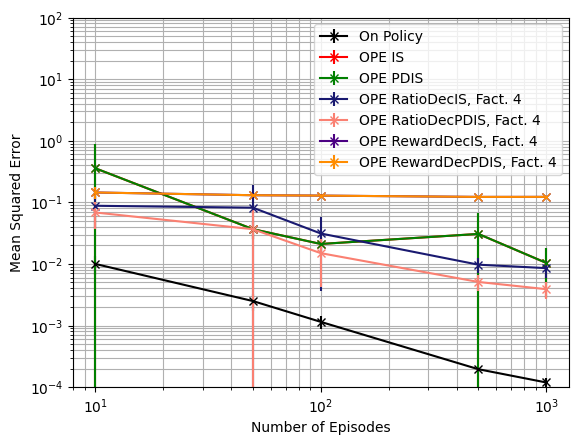

In [ ]:
plot_graphs(MSE_means, MSE_stds, label, 10**(-4), 10**2, shorter_D, factorisation=4)

##### Plot ESS

On Policy-----[  10.   50.  100.  500. 1000.]
OPE IS-----[ 1.48386478  3.82974347  6.24621615  9.33284637 19.76553735]
OPE PDIS-----[ 1.48386478  3.82974347  6.24621615  9.33284637 19.76553735]
OPE RatioDecIS, Fact. 1-----[ 0.86300099  2.94061276  4.63486738 22.51091199 25.67598427]
OPE RatioDecPDIS, Fact. 1-----[ 1.65874252  4.97314605  7.70241804 39.5868649  50.60282513]
OPE RewardDecIS, Fact. 1-----[  6.14436105  33.05124285  52.79239059 165.70141619 421.18013506]
OPE RewardDecPDIS, Fact. 1-----[  6.14436105  33.05124285  52.79239059 165.70141619 421.18013506]


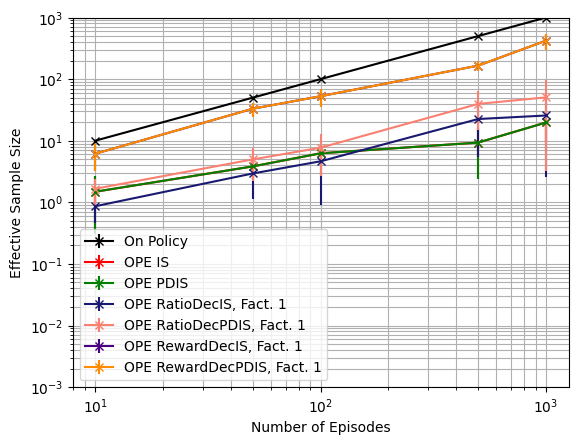

In [ ]:
label = 'ESS'
plot_graphs(ESS_means, ESS_stds, label, 10**(-3), 10**3, shorter_D, factorisation=1)

On Policy-----[  10.   50.  100.  500. 1000.]
OPE IS-----[ 1.48386478  3.82974347  6.24621615  9.33284637 19.76553735]
OPE PDIS-----[ 1.48386478  3.82974347  6.24621615  9.33284637 19.76553735]
OPE RatioDecIS, Fact. 2-----[ 1.73789699  6.65539131 11.97211909 39.27749415 81.02299082]
OPE RatioDecPDIS, Fact. 2-----[ 0.98237469  5.13523232  9.65530244 26.70846884 54.29230282]
OPE RewardDecIS, Fact. 2-----[  6.14436105  33.05124285  52.79239059 165.70141619 421.18013506]
OPE RewardDecPDIS, Fact. 2-----[  6.14436105  33.05124285  52.79239059 165.70141619 421.18013506]


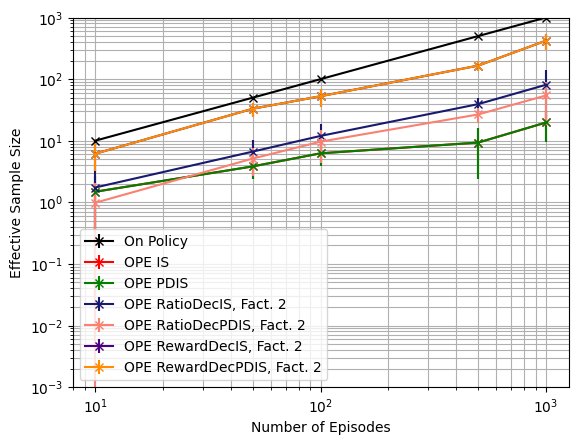

In [ ]:
plot_graphs(ESS_means, ESS_stds, label, 10**(-3), 10**3, shorter_D, factorisation=2)

On Policy-----[  10.   50.  100.  500. 1000.]
OPE IS-----[ 1.48386478  3.82974347  6.24621615  9.33284637 19.76553735]
OPE PDIS-----[ 1.48386478  3.82974347  6.24621615  9.33284637 19.76553735]
OPE RatioDecIS, Fact. 3-----[ 1.56789091  8.7650916  11.59875558 18.89053211 80.08819456]
OPE RatioDecPDIS, Fact. 3-----[ 1.13113455  5.32218279  7.08042744 10.7634041  41.33490622]
OPE RewardDecIS, Fact. 3-----[  6.14436105  33.05124285  52.79239059 165.70141619 421.18013506]
OPE RewardDecPDIS, Fact. 3-----[  6.14436105  33.05124285  52.79239059 165.70141619 421.18013506]


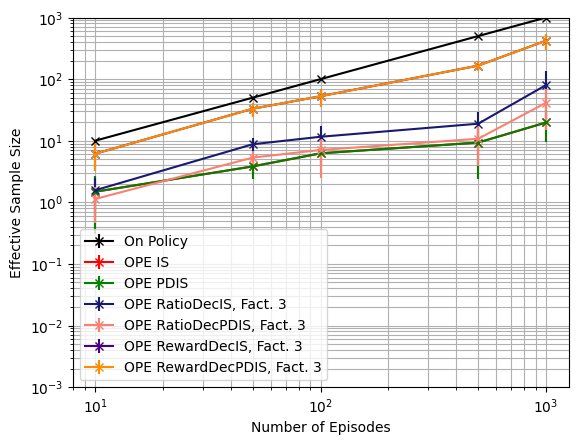

In [ ]:
plot_graphs(ESS_means, ESS_stds, label, 10**(-3), 10**3, shorter_D, factorisation=3)

On Policy-----[  10.   50.  100.  500. 1000.]
OPE IS-----[ 1.48386478  3.82974347  6.24621615  9.33284637 19.76553735]
OPE PDIS-----[ 1.48386478  3.82974347  6.24621615  9.33284637 19.76553735]
OPE RatioDecIS, Fact. 4-----[ 1.5842289   6.0357606   9.37139248 38.23907552 67.08803682]
OPE RatioDecPDIS, Fact. 4-----[ 1.91108087  7.42339637 12.8733712  40.45567632 94.2448026 ]
OPE RewardDecIS, Fact. 4-----[ 13.82481237  74.36529641 118.78287883 372.82818642 947.65530388]
OPE RewardDecPDIS, Fact. 4-----[ 13.82481237  74.36529641 118.78287883 372.82818642 947.65530388]


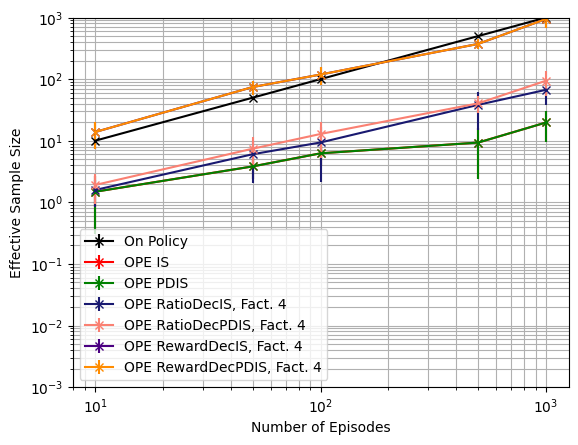

In [ ]:
plot_graphs(ESS_means, ESS_stds, label, 10**(-3), 10**3, shorter_D, factorisation=4)

### Varying Episodes $\epsilon_{e} = 0.8$ (Policy Divergence $1.6^{20}$)



Set up evaluation policy, generate data and convert into factored format

In [ ]:
EVAL_EPSILON = 0.8

evalPolSoft = np.copy(fullPol)
evalPolSoft[evalPolSoft == 1] = 1 - EVAL_EPSILON
evalPolSoft[evalPolSoft == 0] = EVAL_EPSILON / (n_actions - 1)

In [ ]:
# Calculate policy divergence from Voloshin et al.
D = 0
for state in range(randPol.shape[0] - 1):
    for action in range(randPol.shape[1] - 1):
        difference = evalPolSoft[state, action]/randPol[state, action]
        D = max(D, difference)
print(D)
shorter_D = round(D,2)

1.5999999999999996


In [ ]:
dgen = DataGenerator()
states, actions, lengths, rewards, diab, emp_tx_totals, emp_r_totals = dgen.simulate(
    NSIMSAMPS, NSTEPS, policy=evalPolSoft, policy_idx_type='full',
    p_diabetes=PROB_DIAB, use_tqdm=False) #True, tqdm_desc='Behaviour Policy Simulation')

obs_samps = utils.format_dgen_samps(
    states, actions, rewards, diab, NSTEPS, NSIMSAMPS)

In [ ]:
time = np.arange(NSTEPS)
times = np.stack(axis=0, arrays=[time]*NSIMSAMPS)
times = times[..., np.newaxis]

nf_tr_e = np.concatenate((times, states[:, 0:NSTEPS, :], actions, rewards, states[:, 1:, :]), axis=2)
nf_tr_e.shape

(100000, 20, 5)

In [ ]:
f_tr_e1, f_tr_e2, f_tr_e3, f_tr_e4 = factorise_dataset(nf_tr_e)

In [ ]:
factored_evalPolSoft1 = factor_policy_1(evalPolSoft)
factored_evalPolSoft2 = factor_policy_2(evalPolSoft)
factored_evalPolSoft3 = factor_policy_3(evalPolSoft)
factored_evalPolSoft4 = factor_policy_4(evalPolSoft)

In [ ]:
evalPolSoft = pad_policy(evalPolSoft)

factored_evalPolSoft1[0] = pad_policy(factored_evalPolSoft1[0])
factored_evalPolSoft1[1] = pad_policy(factored_evalPolSoft1[1])

factored_evalPolSoft2[0] = pad_policy(factored_evalPolSoft2[0])
factored_evalPolSoft2[1] = pad_policy(factored_evalPolSoft2[1])

factored_evalPolSoft3[0] = pad_policy(factored_evalPolSoft3[0])
factored_evalPolSoft3[1] = pad_policy(factored_evalPolSoft3[1])

factored_evalPolSoft4[0] = pad_policy(factored_evalPolSoft4[0])
factored_evalPolSoft4[1] = pad_policy(factored_evalPolSoft4[1])
factored_evalPolSoft4[2] = pad_policy(factored_evalPolSoft4[2])

In [ ]:
import policy_estimators as pe
import gc

def evaluate_PE(RUNS, EPISODES, SHORTER_D, STEPS=NSTEPS):

  biases = np.zeros((5, 20))
  variances = np.zeros((5, 20))
  MSEs = np.zeros((5, 20))
  ESSs = np.zeros((5, 20))

  # Reshape data for processing
  T, ldim = nf_tr_b.shape[-2], nf_tr_b.shape[-1]
  nfb = nf_tr_b.reshape((-1, RUNS, EPISODES, T, ldim))
  nfe = nf_tr_e.reshape((-1, RUNS, EPISODES, T, ldim))

  T, D1, ldim = f_tr_b1.shape[-3], f_tr_b1.shape[-2], f_tr_b1.shape[-1]
  fb1 = f_tr_b1.reshape((-1, RUNS, EPISODES, T, D1, ldim))
  fe1 = f_tr_e1.reshape((-1, RUNS, EPISODES, T, D1, ldim))

  T, D2, ldim = f_tr_b2.shape[-3], f_tr_b2.shape[-2], f_tr_b2.shape[-1]
  fb2 = f_tr_b2.reshape((-1, RUNS, EPISODES, T, D2, ldim))
  fe2 = f_tr_e2.reshape((-1, RUNS, EPISODES, T, D2, ldim))

  T, D3, ldim = f_tr_b3.shape[-3], f_tr_b3.shape[-2], f_tr_b3.shape[-1]
  fb3 = f_tr_b3.reshape((-1, RUNS, EPISODES, T, D3, ldim))
  fe3 = f_tr_e3.reshape((-1, RUNS, EPISODES, T, D3, ldim))

  T, D4, ldim = f_tr_b4.shape[-3], f_tr_b4.shape[-2], f_tr_b4.shape[-1]
  fb4 = f_tr_b4.reshape((-1, RUNS, EPISODES, T, D4, ldim))
  fe4 = f_tr_e4.reshape((-1, RUNS, EPISODES, T, D4, ldim))

  for t in range(5):
    print()

    lower_index = 0
    estimates_on_policy = np.zeros(RUNS)
    estimates_OPE_IS = np.zeros(RUNS)
    estimates_OPE_PDIS = np.zeros(RUNS)
    estimates_OPE_PDWIS = np.zeros(RUNS)

    estimates_OPE_RatioDecIS1 = np.zeros(RUNS)
    estimates_OPE_RatioDecPDIS1 = np.zeros(RUNS)
    estimates_OPE_RewardDecIS1 = np.zeros(RUNS)
    estimates_OPE_RewardDecPDIS1 = np.zeros(RUNS)

    estimates_OPE_RatioDecIS2 = np.zeros(RUNS)
    estimates_OPE_RatioDecPDIS2 = np.zeros(RUNS)
    estimates_OPE_RewardDecIS2 = np.zeros(RUNS)
    estimates_OPE_RewardDecPDIS2 = np.zeros(RUNS)

    estimates_OPE_RatioDecIS3 = np.zeros(RUNS)
    estimates_OPE_RatioDecPDIS3 = np.zeros(RUNS)
    estimates_OPE_RewardDecIS3 = np.zeros(RUNS)
    estimates_OPE_RewardDecPDIS3 = np.zeros(RUNS)

    estimates_OPE_RatioDecIS4 = np.zeros(RUNS)
    estimates_OPE_RatioDecPDIS4 = np.zeros(RUNS)
    estimates_OPE_RewardDecIS4 = np.zeros(RUNS)
    estimates_OPE_RewardDecPDIS4 = np.zeros(RUNS)

    for r in range(RUNS):
        #On policy Q estimate
        estimates_on_policy[r] = pe.on_policy_Q_estimate(nfe[t, r, :, :STEPS, :], DISCOUNT_Pol)
        #Off policy IS estimate
        estimates_OPE_IS[r] = pe.off_policy_IS_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, randPol, evalPolSoft)
        #Off policy PDIS estimate
        estimates_OPE_PDIS[r] = pe.off_policy_PDIS_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, randPol, evalPolSoft)
        #Off policy PDWIS estimate
        estimates_OPE_PDWIS[r] = pe.off_policy_PDWIS_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, randPol, evalPolSoft)

        #Factorisation 1----------------------------------

        #Off policy half decomposed IS estimate
        estimates_OPE_RatioDecIS1[r] = off_policy_RatioDecIS_estimator(nfb[t, r, :, :STEPS, :], fb1[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol1, factored_evalPolSoft1)
        #Off policy half decomposed PDIS estimate
        estimates_OPE_RatioDecPDIS1[r] = off_policy_RatioDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb1[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol1, factored_evalPolSoft1)
        #Off policy half decomposed IS estimate
        estimates_OPE_RewardDecIS1[r] = off_policy_RewardDecIS_estimator(nfb[t, r, :, :STEPS, :], fb1[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)
        #Off policy half decomposed PDIS estimate
        estimates_OPE_RewardDecPDIS1[r] = off_policy_RewardDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb1[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)

        #Factorisation 2----------------------------------

        #Off policy half decomposed IS estimate
        estimates_OPE_RatioDecIS2[r] = off_policy_RatioDecIS_estimator(nfb[t, r, :, :STEPS, :], fb2[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol2, factored_evalPolSoft2)
        #Off policy half decomposed PDIS estimate
        estimates_OPE_RatioDecPDIS2[r] = off_policy_RatioDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb2[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol2, factored_evalPolSoft2)
        #Off policy half decomposed IS estimate
        estimates_OPE_RewardDecIS2[r] = off_policy_RewardDecIS_estimator(nfb[t, r, :, :STEPS, :], fb2[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)
        #Off policy half decomposed PDIS estimate
        estimates_OPE_RewardDecPDIS2[r] = off_policy_RewardDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb2[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)

        #Factorisation 3----------------------------------

        #Off policy decomposed IS estimate
        estimates_OPE_RatioDecIS3[r] = off_policy_RatioDecIS_estimator(nfb[t, r, :, :STEPS, :], fb3[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol3, factored_evalPolSoft3)
        #Off policy decomposed PDIS estimate
        estimates_OPE_RatioDecPDIS3[r] = off_policy_RatioDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb3[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol3, factored_evalPolSoft3)
        #Off policy half decomposed IS estimate
        estimates_OPE_RewardDecIS3[r] = off_policy_RewardDecIS_estimator(nfb[t, r, :, :STEPS, :], fb3[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)
        #Off policy half decomposed PDIS estimate
        estimates_OPE_RewardDecPDIS3[r] = off_policy_RewardDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb3[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)

        #Factorisation 4----------------------------------

        #Off policy decomposed IS estimate
        estimates_OPE_RatioDecIS4[r] = off_policy_RatioDecIS_estimator(nfb[t, r, :, :STEPS, :], fb4[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1,2], factored_randPol4, factored_evalPolSoft4)
        #Off policy decomposed PDIS estimate
        estimates_OPE_RatioDecPDIS4[r] = off_policy_RatioDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb4[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1,2], factored_randPol4, factored_evalPolSoft4)
        #Off policy half decomposed IS estimate
        estimates_OPE_RewardDecIS4[r] = off_policy_RewardDecIS_estimator(nfb[t, r, :, :STEPS, :], fb4[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)
        #Off policy half decomposed PDIS estimate
        estimates_OPE_RewardDecPDIS4[r] = off_policy_RewardDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb4[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)

    mean_on_policy = np.mean(estimates_on_policy)
    var_on_policy = np.var(estimates_on_policy, ddof=0)
    print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

    from sklearn.metrics import mean_squared_error

    #For on policy
    biases[t, 0] = 0.0
    variances[t, 0] = var_on_policy
    MSEs[t, 0] = var_on_policy
    ESSs[t, 0] = EPISODES

    def generate_results(estimates, mean_true, label):
      MSE = mean_squared_error(estimates, [mean_true]*RUNS)
      mean = np.mean(estimates)
      var = np.var(estimates, ddof=0)
      bias1 = np.sqrt(MSE - var)
      bias2 = abs(mean - mean_true)
      print(f'Mean {label} estimate: {mean}. Bias1: {bias1}. Bias2: {bias2}. Variance: {var}. MSE: {MSE}')
      return bias1, var, MSE

    label_list = ['OPE IS', 'OPE PDIS', 'OPE PDWIS',
                  'OPE RatioDecIS: Fact. 1', 'OPE RatioDecPDIS: Fact. 1',
                  'OPE RewardDecIS: Fact. 1', 'OPE RewardDecPDIS: Fact. 1',
                  'OPE RatioDecIS: Fact. 2', 'OPE RatioDecPDIS: Fact. 2',
                  'OPE RewardDecIS: Fact. 2', 'OPE RewardDecPDIS: Fact. 2',
                  'OPE RatioDecIS: Fact. 3', 'OPE RatioDecPDIS: Fact. 3',
                  'OPE RewardDecIS: Fact. 3', 'OPE RewardDecPDIS: Fact. 3',
                  'OPE RatioDecIS: Fact. 4', 'OPE RatioDecPDIS: Fact. 4',
                  'OPE RewardDecIS: Fact. 4', 'OPE RewardDecPDIS: Fact. 4'
                  ]

    estimates = [estimates_OPE_IS, estimates_OPE_PDIS, estimates_OPE_PDWIS,
                estimates_OPE_RatioDecIS1, estimates_OPE_RatioDecPDIS1,
                estimates_OPE_RewardDecIS1, estimates_OPE_RewardDecPDIS1,
                estimates_OPE_RatioDecIS2, estimates_OPE_RatioDecPDIS2,
                estimates_OPE_RewardDecIS2, estimates_OPE_RewardDecPDIS2,
                estimates_OPE_RatioDecIS3, estimates_OPE_RatioDecPDIS3,
                estimates_OPE_RewardDecIS3, estimates_OPE_RewardDecPDIS3,
                estimates_OPE_RatioDecIS4, estimates_OPE_RatioDecPDIS4,
                estimates_OPE_RewardDecIS4, estimates_OPE_RewardDecPDIS4,
                ]


    for (id, val) in enumerate(label_list):
      biases[t, 1+id], variances[t, 1+id], MSEs[t, 1+id] = generate_results(estimates[id], mean_on_policy, label_list[id])
      ESSs[t, 1+id] = (EPISODES*variances[t, 0])/variances[t, 1+id]
      gc.collect()

  return np.mean(biases, axis=0), np.std(biases, axis=0), np.mean(variances, axis=0), np.std(variances, axis=0), np.mean(MSEs, axis=0), np.std(MSEs, axis=0), np.mean(ESSs, axis=0), np.std(ESSs, axis=0)

#### Run Everything

In [ ]:
EPISODES = [10, 50, 100, 500, 1000]

bias_means = np.zeros((len(EPISODES), 20))
bias_stds = np.zeros((len(EPISODES), 20))
var_means = np.zeros((len(EPISODES), 20))
var_stds = np.zeros((len(EPISODES), 20))
MSE_means = np.zeros((len(EPISODES), 20))
MSE_stds = np.zeros((len(EPISODES), 20))
ESS_means = np.zeros((len(EPISODES), 20))
ESS_stds = np.zeros((len(EPISODES), 20))

RUNS = 20

for id in range(len(EPISODES)):
  e = EPISODES[id]
  print(f'{e} Episodes, {RUNS} ----------------------------------')
  bias_means[id, :], bias_stds[id, :], var_means[id, :], var_stds[id, :], MSE_means[id, :], MSE_stds[id, :], ESS_means[id, :], ESS_stds[id, :] = evaluate_PE(RUNS=RUNS, EPISODES=e, SHORTER_D=shorter_D)
  print()
  gc.collect()

print('BIAS MEANS')
print(list(bias_means))
print('\nBIAS STDS')
print(list(bias_stds))
print('\nVAR MEANS')
print(list(var_means))
print('\nVAR STDS')
print(list(var_stds))
print('\nMSE MEANS')
print(list(MSE_means))
print('\nMSE STDS')
print(list(MSE_stds))
print('\nESS MEANS')
print(list(ESS_means))
print('\nESS STDS')
print(list(ESS_stds))

10 Episodes, 20 ----------------------------------

Mean on policy Q estimate: -0.9598464867758734. Variance of on policy Q estimate: 0.0034897469757337782
Mean OPE IS estimate: -0.9318861414106937. Bias1: 0.02796034536517988. Bias2: 0.027960345365179662. Variance: 0.00694967768782836. MSE: 0.007731458600768496
Mean OPE PDIS estimate: -0.9318861414106937. Bias1: 0.02796034536517988. Bias2: 0.027960345365179662. Variance: 0.00694967768782836. MSE: 0.007731458600768496
Mean OPE PDWIS estimate: -0.04826958059550411. Bias1: 0.9115769061803694. Bias2: 0.9115769061803692. Variance: 8.664358025876099e-06. MSE: 0.8309811202393996
Mean OPE RatioDecIS: Fact. 1 estimate: -1.0556972990522664. Bias1: 0.09585081227639311. Bias2: 0.09585081227639303. Variance: 0.00789066676518126. MSE: 0.01707804497922561
Mean OPE RatioDecPDIS: Fact. 1 estimate: -0.9286107770866059. Bias1: 0.03123570968926742. Bias2: 0.031235709689267477. Variance: 0.0064034675503095466. MSE: 0.007379137110101741
Mean OPE RewardDecIS

#### Plot Graphs

##### Plot Bias

OPE IS-----[0.02933662 0.00885135 0.00540145 0.00719161 0.00613445]
OPE PDIS-----[0.02933662 0.00885135 0.00540145 0.00719161 0.00613445]
OPE RatioDecIS, Fact. 1-----[0.12263742 0.14252163 0.13357214 0.14063097 0.13895189]
OPE RatioDecPDIS, Fact. 1-----[0.03361147 0.01372452 0.00510328 0.00893653 0.00728552]
OPE RewardDecIS, Fact. 1-----[0.02614853 0.00869324 0.00938162 0.00491323 0.00534105]
OPE RewardDecPDIS, Fact. 1-----[0.02614853 0.00869324 0.00938162 0.00491323 0.00534105]


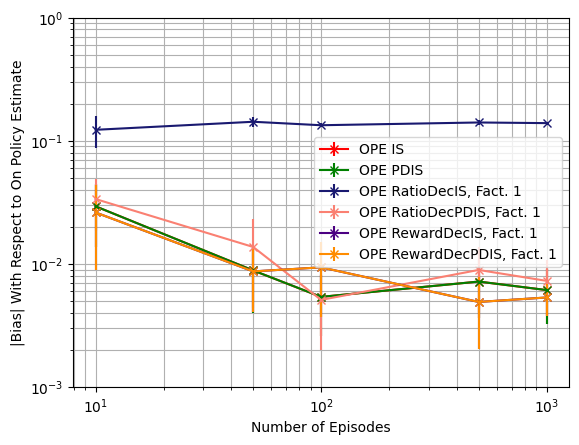

In [ ]:
label = 'bias'
plot_graphs(bias_means, bias_stds, label, 10**-3, 10**0, shorter_D, factorisation=1)

OPE IS-----[0.02933662 0.00885135 0.00540145 0.00719161 0.00613445]
OPE PDIS-----[0.02933662 0.00885135 0.00540145 0.00719161 0.00613445]
OPE RatioDecIS, Fact. 2-----[0.12105528 0.10769628 0.11158114 0.10619038 0.10596263]
OPE RatioDecPDIS, Fact. 2-----[0.03633358 0.00939294 0.00516205 0.00775838 0.00744811]
OPE RewardDecIS, Fact. 2-----[0.02614853 0.00869324 0.00938162 0.00491323 0.00534105]
OPE RewardDecPDIS, Fact. 2-----[0.02614853 0.00869324 0.00938162 0.00491323 0.00534105]


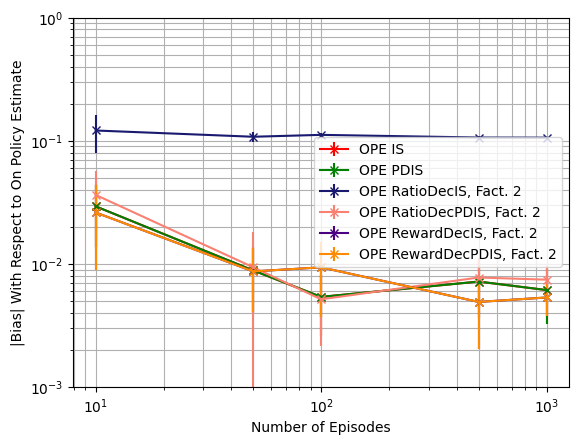

In [ ]:
plot_graphs(bias_means, bias_stds, label, 10**(-3), 10**0, shorter_D, factorisation=2)

OPE IS-----[0.02933662 0.00885135 0.00540145 0.00719161 0.00613445]
OPE PDIS-----[0.02933662 0.00885135 0.00540145 0.00719161 0.00613445]
OPE RatioDecIS, Fact. 3-----[0.06673765 0.0509256  0.05652406 0.05365659 0.05418532]
OPE RatioDecPDIS, Fact. 3-----[0.02686278 0.01198704 0.0039004  0.00456444 0.00366172]
OPE RewardDecIS, Fact. 3-----[0.02614853 0.00869324 0.00938162 0.00491323 0.00534105]
OPE RewardDecPDIS, Fact. 3-----[0.02614853 0.00869324 0.00938162 0.00491323 0.00534105]


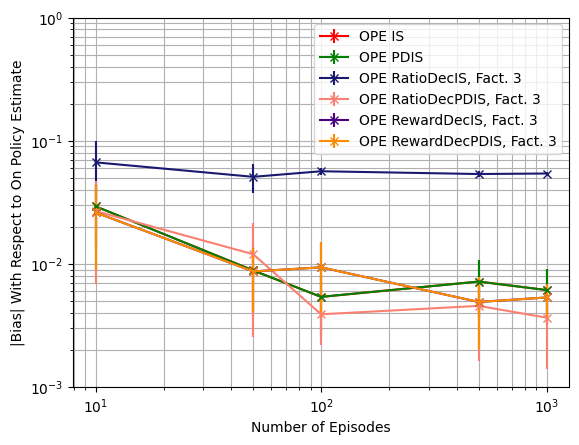

In [ ]:
plot_graphs(bias_means, bias_stds, label, 10**(-3), 10**0, shorter_D, factorisation=3)

OPE IS-----[0.02933662 0.00885135 0.00540145 0.00719161 0.00613445]
OPE PDIS-----[0.02933662 0.00885135 0.00540145 0.00719161 0.00613445]
OPE RatioDecIS, Fact. 4-----[0.02575223 0.02089564 0.01430859 0.01935402 0.01873442]
OPE RatioDecPDIS, Fact. 4-----[0.02789156 0.01208982 0.00473078 0.00752357 0.006564  ]
OPE RewardDecIS, Fact. 4-----[0.32668944 0.31733147 0.32130397 0.31722529 0.31752271]
OPE RewardDecPDIS, Fact. 4-----[0.32668944 0.31733147 0.32130397 0.31722529 0.31752271]


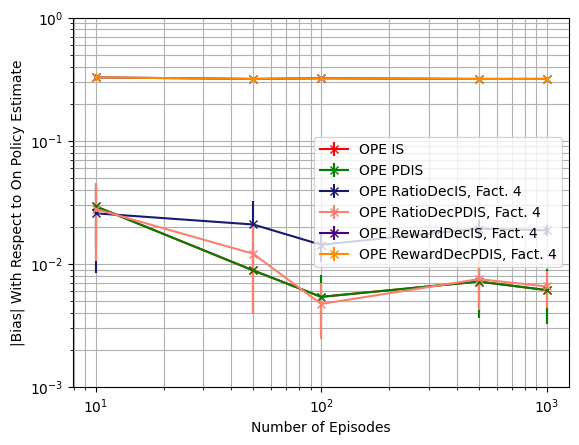

In [ ]:
plot_graphs(bias_means, bias_stds, label, 10**(-3), 10**0, shorter_D, factorisation=4)

##### Plot Variance

On Policy-----[3.55780576e-03 1.07436582e-03 4.77848678e-04 7.57493173e-05
 5.10322610e-05]
OPE IS-----[0.01643139 0.0025855  0.00155109 0.00044013 0.0002508 ]
OPE PDIS-----[0.01643139 0.0025855  0.00155109 0.00044013 0.0002508 ]
OPE RatioDecIS, Fact. 1-----[0.0133296  0.00294524 0.00157729 0.00030933 0.00019753]
OPE RatioDecPDIS, Fact. 1-----[0.01070679 0.00227369 0.0012593  0.00026227 0.00016678]
OPE RewardDecIS, Fact. 1-----[5.35378413e-03 8.98359636e-04 5.73930889e-04 1.42612579e-04
 7.76955068e-05]
OPE RewardDecPDIS, Fact. 1-----[5.35378413e-03 8.98359636e-04 5.73930889e-04 1.42612579e-04
 7.76955068e-05]


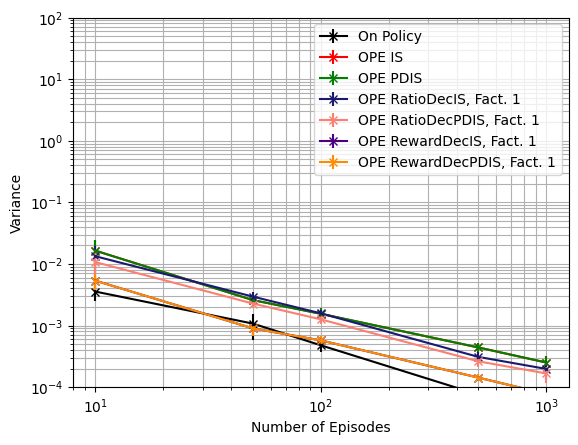

In [ ]:
label = 'var'
plot_graphs(var_means, var_stds, label, 10**(-4), 10**2, shorter_D, factorisation=1)

On Policy-----[3.55780576e-03 1.07436582e-03 4.77848678e-04 7.57493173e-05
 5.10322610e-05]
OPE IS-----[0.01643139 0.0025855  0.00155109 0.00044013 0.0002508 ]
OPE PDIS-----[0.01643139 0.0025855  0.00155109 0.00044013 0.0002508 ]
OPE RatioDecIS, Fact. 2-----[0.00988768 0.00208151 0.00113064 0.00031116 0.0001588 ]
OPE RatioDecPDIS, Fact. 2-----[0.01253789 0.00233821 0.00133494 0.00038389 0.00019452]
OPE RewardDecIS, Fact. 2-----[5.35378413e-03 8.98359636e-04 5.73930889e-04 1.42612579e-04
 7.76955068e-05]
OPE RewardDecPDIS, Fact. 2-----[5.35378413e-03 8.98359636e-04 5.73930889e-04 1.42612579e-04
 7.76955068e-05]


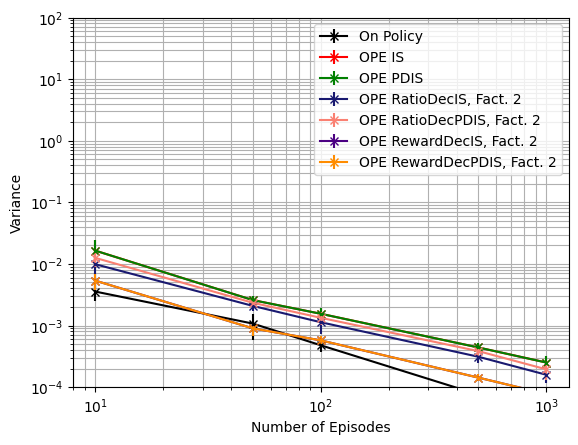

In [ ]:
plot_graphs(var_means, var_stds, label, 10**(-4), 10**2, shorter_D, factorisation=2)

On Policy-----[3.55780576e-03 1.07436582e-03 4.77848678e-04 7.57493173e-05
 5.10322610e-05]
OPE IS-----[0.01643139 0.0025855  0.00155109 0.00044013 0.0002508 ]
OPE PDIS-----[0.01643139 0.0025855  0.00155109 0.00044013 0.0002508 ]
OPE RatioDecIS, Fact. 3-----[0.01243077 0.00230112 0.00126364 0.0003807  0.00017627]
OPE RatioDecPDIS, Fact. 3-----[0.01381608 0.00250149 0.00144862 0.00042384 0.00019736]
OPE RewardDecIS, Fact. 3-----[5.35378413e-03 8.98359636e-04 5.73930889e-04 1.42612579e-04
 7.76955068e-05]
OPE RewardDecPDIS, Fact. 3-----[5.35378413e-03 8.98359636e-04 5.73930889e-04 1.42612579e-04
 7.76955068e-05]


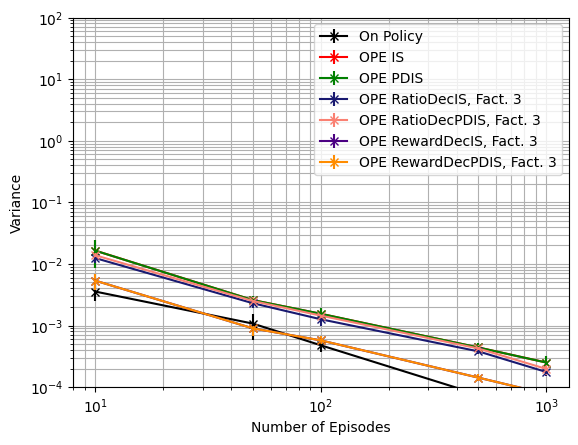

In [ ]:
plot_graphs(var_means, var_stds, label, 10**(-4), 10**2, shorter_D, factorisation=3)

On Policy-----[3.55780576e-03 1.07436582e-03 4.77848678e-04 7.57493173e-05
 5.10322610e-05]
OPE IS-----[0.01643139 0.0025855  0.00155109 0.00044013 0.0002508 ]
OPE PDIS-----[0.01643139 0.0025855  0.00155109 0.00044013 0.0002508 ]
OPE RatioDecIS, Fact. 4-----[0.0085698  0.00196748 0.00097285 0.00024008 0.00011817]
OPE RatioDecPDIS, Fact. 4-----[0.00900244 0.00182073 0.0009501  0.00025421 0.00012189]
OPE RewardDecIS, Fact. 4-----[2.37945962e-03 3.99270949e-04 2.55080395e-04 6.33833685e-05
 3.45313363e-05]
OPE RewardDecPDIS, Fact. 4-----[2.37945962e-03 3.99270949e-04 2.55080395e-04 6.33833685e-05
 3.45313363e-05]


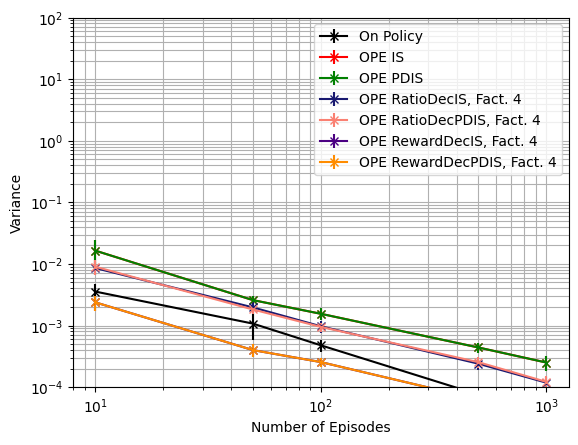

In [ ]:
plot_graphs(var_means, var_stds, label, 10**(-4), 10**2, shorter_D, factorisation=4)

##### Plot MSE

On Policy-----[3.55780576e-03 1.07436582e-03 4.77848678e-04 7.57493173e-05
 5.10322610e-05]
OPE IS-----[0.01753552 0.00268726 0.00158813 0.00050432 0.00029674]
OPE PDIS-----[0.01753552 0.00268726 0.00158813 0.00050432 0.00029674]
OPE RatioDecIS, Fact. 1-----[0.02965057 0.02343799 0.01944698 0.02011615 0.01951974]
OPE RatioDecPDIS, Fact. 1-----[0.0120655  0.00254993 0.00129505 0.00036605 0.00023153]
OPE RewardDecIS, Fact. 1-----[0.00633243 0.00099554 0.00069409 0.00017497 0.00010874]
OPE RewardDecPDIS, Fact. 1-----[0.00633243 0.00099554 0.00069409 0.00017497 0.00010874]


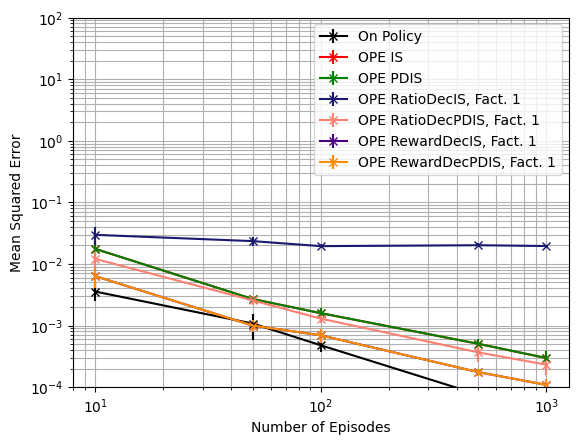

In [ ]:
label = 'MSE'
plot_graphs(MSE_means, MSE_stds, label, 10**(-4), 10**2, shorter_D, factorisation=1)

On Policy-----[3.55780576e-03 1.07436582e-03 4.77848678e-04 7.57493173e-05
 5.10322610e-05]
OPE IS-----[0.01753552 0.00268726 0.00158813 0.00050432 0.00029674]
OPE PDIS-----[0.01753552 0.00268726 0.00158813 0.00050432 0.00029674]
OPE RatioDecIS, Fact. 2-----[0.02622772 0.01379089 0.01360149 0.01159912 0.01139055]
OPE RatioDecPDIS, Fact. 2-----[0.01428651 0.00250468 0.00137051 0.00045549 0.00025475]
OPE RewardDecIS, Fact. 2-----[0.00633243 0.00099554 0.00069409 0.00017497 0.00010874]
OPE RewardDecPDIS, Fact. 2-----[0.00633243 0.00099554 0.00069409 0.00017497 0.00010874]


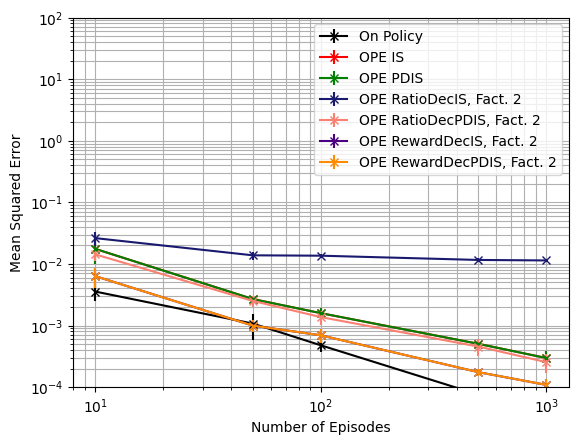

In [ ]:
plot_graphs(MSE_means, MSE_stds, label, 10**(-4), 10**2, shorter_D, factorisation=2)

On Policy-----[3.55780576e-03 1.07436582e-03 4.77848678e-04 7.57493173e-05
 5.10322610e-05]
OPE IS-----[0.01753552 0.00268726 0.00158813 0.00050432 0.00029674]
OPE PDIS-----[0.01753552 0.00268726 0.00158813 0.00050432 0.00029674]
OPE RatioDecIS, Fact. 3-----[0.01801589 0.00507743 0.00447066 0.00326768 0.00311544]
OPE RatioDecPDIS, Fact. 3-----[0.01493943 0.00273406 0.00146677 0.0004533  0.00021584]
OPE RewardDecIS, Fact. 3-----[0.00633243 0.00099554 0.00069409 0.00017497 0.00010874]
OPE RewardDecPDIS, Fact. 3-----[0.00633243 0.00099554 0.00069409 0.00017497 0.00010874]


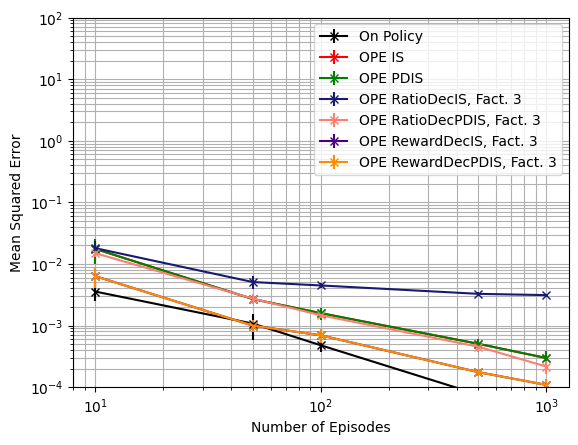

In [ ]:
plot_graphs(MSE_means, MSE_stds, label, 10**(-4), 10**2, shorter_D, factorisation=3)

On Policy-----[3.55780576e-03 1.07436582e-03 4.77848678e-04 7.57493173e-05
 5.10322610e-05]
OPE IS-----[0.01753552 0.00268726 0.00158813 0.00050432 0.00029674]
OPE PDIS-----[0.01753552 0.00268726 0.00158813 0.00050432 0.00029674]
OPE RatioDecIS, Fact. 4-----[0.00953538 0.00254134 0.00119264 0.00062659 0.00047318]
OPE RatioDecPDIS, Fact. 4-----[0.01007826 0.00203358 0.00097772 0.00032175 0.00016955]
OPE RewardDecIS, Fact. 4-----[0.1095995  0.10115006 0.10351212 0.10070383 0.10085684]
OPE RewardDecPDIS, Fact. 4-----[0.1095995  0.10115006 0.10351212 0.10070383 0.10085684]


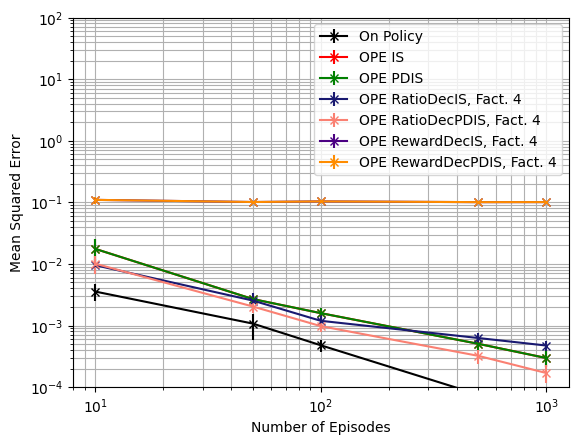

In [ ]:
plot_graphs(MSE_means, MSE_stds, label, 10**(-4), 10**2, shorter_D, factorisation=4)

##### Plot ESS

On Policy-----[  10.   50.  100.  500. 1000.]
OPE IS-----[  2.60516234  20.08313225  32.1146403   84.52166245 222.93578628]
OPE PDIS-----[  2.60516234  20.08313225  32.1146403   84.52166245 222.93578628]
OPE RatioDecIS, Fact. 1-----[  3.2218496   17.82256536  30.90041036 133.63663907 275.72086884]
OPE RatioDecPDIS, Fact. 1-----[  4.07886045  23.20949997  39.07130406 154.09541453 320.43820495]
OPE RewardDecIS, Fact. 1-----[  7.04392069  58.37180017  84.30237086 262.39251216 686.06164307]
OPE RewardDecPDIS, Fact. 1-----[  7.04392069  58.37180017  84.30237086 262.39251216 686.06164307]


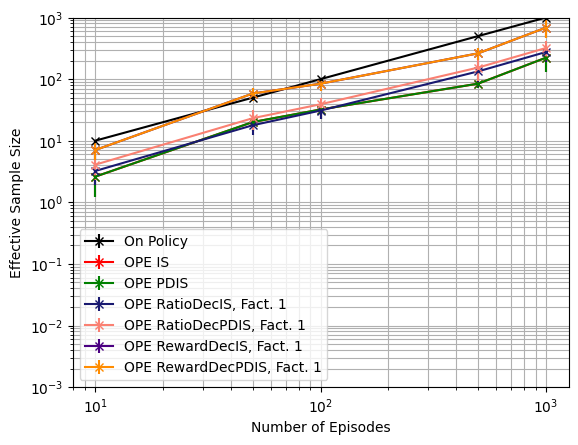

In [ ]:
label = 'ESS'
plot_graphs(ESS_means, ESS_stds, label, 10**(-3), 10**3, shorter_D, factorisation=1)

On Policy-----[  10.   50.  100.  500. 1000.]
OPE IS-----[  2.60516234  20.08313225  32.1146403   84.52166245 222.93578628]
OPE PDIS-----[  2.60516234  20.08313225  32.1146403   84.52166245 222.93578628]
OPE RatioDecIS, Fact. 2-----[  3.68722353  26.65330629  45.81184237 121.43382863 336.41791548]
OPE RatioDecPDIS, Fact. 2-----[  2.91754519  23.67014939  38.17486867 101.03690186 279.30777021]
OPE RewardDecIS, Fact. 2-----[  7.04392069  58.37180017  84.30237086 262.39251216 686.06164307]
OPE RewardDecPDIS, Fact. 2-----[  7.04392069  58.37180017  84.30237086 262.39251216 686.06164307]


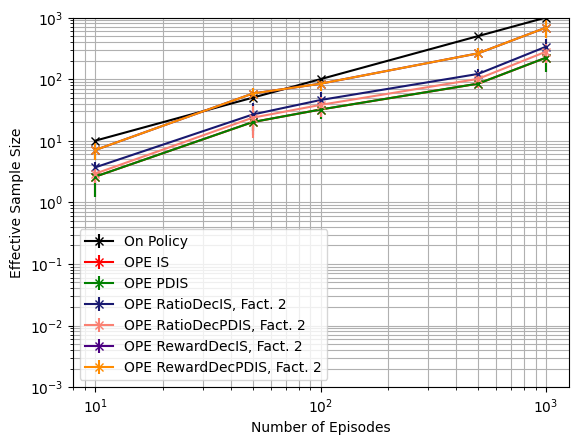

In [ ]:
plot_graphs(ESS_means, ESS_stds, label, 10**(-3), 10**3, shorter_D, factorisation=2)

On Policy-----[  10.   50.  100.  500. 1000.]
OPE IS-----[  2.60516234  20.08313225  32.1146403   84.52166245 222.93578628]
OPE PDIS-----[  2.60516234  20.08313225  32.1146403   84.52166245 222.93578628]
OPE RatioDecIS, Fact. 3-----[  2.99020556  23.42731917  38.1175201   99.58433381 296.36018357]
OPE RatioDecPDIS, Fact. 3-----[  2.66224391  21.36336493  32.80746856  90.71012363 269.92909879]
OPE RewardDecIS, Fact. 3-----[  7.04392069  58.37180017  84.30237086 262.39251216 686.06164307]
OPE RewardDecPDIS, Fact. 3-----[  7.04392069  58.37180017  84.30237086 262.39251216 686.06164307]


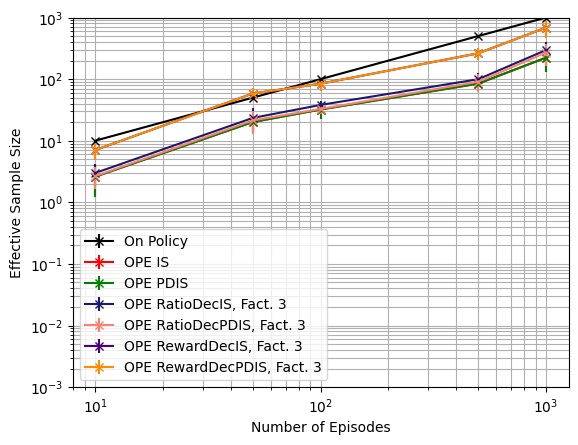

In [ ]:
plot_graphs(ESS_means, ESS_stds, label, 10**(-3), 10**3, shorter_D, factorisation=3)

On Policy-----[  10.   50.  100.  500. 1000.]
OPE IS-----[  2.60516234  20.08313225  32.1146403   84.52166245 222.93578628]
OPE PDIS-----[  2.60516234  20.08313225  32.1146403   84.52166245 222.93578628]
OPE RatioDecIS, Fact. 4-----[  4.38569593  27.90880506  49.81022089 169.17876178 428.78716815]
OPE RatioDecPDIS, Fact. 4-----[  4.32418221  30.22430619  50.7673266  157.20747504 420.27242579]
OPE RewardDecIS, Fact. 4-----[  15.84882154  131.33655038  189.68033444  590.38315237 1543.63869691]
OPE RewardDecPDIS, Fact. 4-----[  15.84882154  131.33655038  189.68033444  590.38315237 1543.63869691]


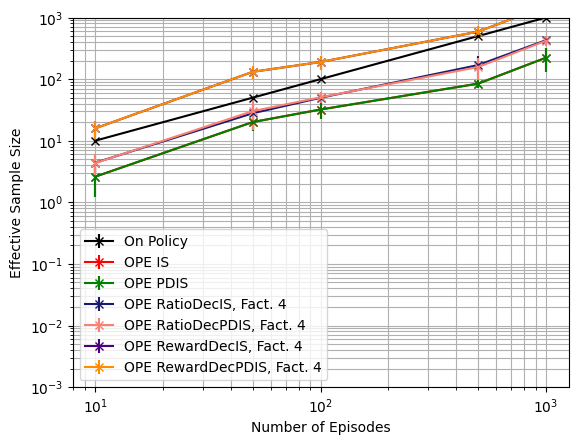

In [ ]:
plot_graphs(ESS_means, ESS_stds, label, 10**(-3), 10**3, shorter_D, factorisation=4)

### Varying Episode Length $T$ With $\epsilon_{e} = 0.8$ (Policy Divergence $1.6^{T}$)

Set up evaluation policy, generate data and convert into factored format

In [ ]:
EVAL_EPSILON = 0.8

evalPolSoft = np.copy(fullPol)
evalPolSoft[evalPolSoft == 1] = 1 - EVAL_EPSILON
evalPolSoft[evalPolSoft == 0] = EVAL_EPSILON / (n_actions - 1)

In [ ]:
# Calculate policy divergence from Voloshin et al.
D = 0
for state in range(randPol.shape[0] - 1):
    for action in range(randPol.shape[1] - 1):
        difference = evalPolSoft[state, action]/randPol[state, action]
        D = max(D, difference)
print(D)
shorter_D = round(D,2)

1.5999999999999996


In [ ]:
dgen = DataGenerator()
states, actions, lengths, rewards, diab, emp_tx_totals, emp_r_totals = dgen.simulate(
    NSIMSAMPS, NSTEPS, policy=evalPolSoft, policy_idx_type='full',
    p_diabetes=PROB_DIAB, use_tqdm=False) #True, tqdm_desc='Behaviour Policy Simulation')

obs_samps = utils.format_dgen_samps(
    states, actions, rewards, diab, NSTEPS, NSIMSAMPS)

In [ ]:
time = np.arange(NSTEPS)
times = np.stack(axis=0, arrays=[time]*NSIMSAMPS)
times = times[..., np.newaxis]

nf_tr_e = np.concatenate((times, states[:, 0:NSTEPS, :], actions, rewards, states[:, 1:, :]), axis=2)
nf_tr_e.shape

(100000, 20, 5)

In [ ]:
f_tr_e1, f_tr_e2, f_tr_e3, f_tr_e4 = factorise_dataset(nf_tr_e)

In [ ]:
factored_evalPolSoft1 = factor_policy_1(evalPolSoft)
factored_evalPolSoft2 = factor_policy_2(evalPolSoft)
factored_evalPolSoft3 = factor_policy_3(evalPolSoft)
factored_evalPolSoft4 = factor_policy_4(evalPolSoft)

In [ ]:
evalPolSoft = pad_policy(evalPolSoft)

factored_evalPolSoft1[0] = pad_policy(factored_evalPolSoft1[0])
factored_evalPolSoft1[1] = pad_policy(factored_evalPolSoft1[1])

factored_evalPolSoft2[0] = pad_policy(factored_evalPolSoft2[0])
factored_evalPolSoft2[1] = pad_policy(factored_evalPolSoft2[1])

factored_evalPolSoft3[0] = pad_policy(factored_evalPolSoft3[0])
factored_evalPolSoft3[1] = pad_policy(factored_evalPolSoft3[1])

factored_evalPolSoft4[0] = pad_policy(factored_evalPolSoft4[0])
factored_evalPolSoft4[1] = pad_policy(factored_evalPolSoft4[1])
factored_evalPolSoft4[2] = pad_policy(factored_evalPolSoft4[2])

In [ ]:
import policy_estimators as pe
import gc

def evaluate_PE(RUNS, EPISODES, SHORTER_D, STEPS=NSTEPS):

  biases = np.zeros((5, 20))
  variances = np.zeros((5, 20))
  MSEs = np.zeros((5, 20))
  ESSs = np.zeros((5, 20))

  # Reshape data for processing
  T, ldim = nf_tr_b.shape[-2], nf_tr_b.shape[-1]
  nfb = nf_tr_b.reshape((-1, RUNS, EPISODES, T, ldim))
  nfe = nf_tr_e.reshape((-1, RUNS, EPISODES, T, ldim))

  T, D1, ldim = f_tr_b1.shape[-3], f_tr_b1.shape[-2], f_tr_b1.shape[-1]
  fb1 = f_tr_b1.reshape((-1, RUNS, EPISODES, T, D1, ldim))
  fe1 = f_tr_e1.reshape((-1, RUNS, EPISODES, T, D1, ldim))

  T, D2, ldim = f_tr_b2.shape[-3], f_tr_b2.shape[-2], f_tr_b2.shape[-1]
  fb2 = f_tr_b2.reshape((-1, RUNS, EPISODES, T, D2, ldim))
  fe2 = f_tr_e2.reshape((-1, RUNS, EPISODES, T, D2, ldim))

  T, D3, ldim = f_tr_b3.shape[-3], f_tr_b3.shape[-2], f_tr_b3.shape[-1]
  fb3 = f_tr_b3.reshape((-1, RUNS, EPISODES, T, D3, ldim))
  fe3 = f_tr_e3.reshape((-1, RUNS, EPISODES, T, D3, ldim))

  T, D4, ldim = f_tr_b4.shape[-3], f_tr_b4.shape[-2], f_tr_b4.shape[-1]
  fb4 = f_tr_b4.reshape((-1, RUNS, EPISODES, T, D4, ldim))
  fe4 = f_tr_e4.reshape((-1, RUNS, EPISODES, T, D4, ldim))

  for t in range(5):
    print()

    lower_index = 0
    estimates_on_policy = np.zeros(RUNS)
    estimates_OPE_IS = np.zeros(RUNS)
    estimates_OPE_PDIS = np.zeros(RUNS)
    estimates_OPE_PDWIS = np.zeros(RUNS)

    estimates_OPE_RatioDecIS1 = np.zeros(RUNS)
    estimates_OPE_RatioDecPDIS1 = np.zeros(RUNS)
    estimates_OPE_RewardDecIS1 = np.zeros(RUNS)
    estimates_OPE_RewardDecPDIS1 = np.zeros(RUNS)

    estimates_OPE_RatioDecIS2 = np.zeros(RUNS)
    estimates_OPE_RatioDecPDIS2 = np.zeros(RUNS)
    estimates_OPE_RewardDecIS2 = np.zeros(RUNS)
    estimates_OPE_RewardDecPDIS2 = np.zeros(RUNS)

    estimates_OPE_RatioDecIS3 = np.zeros(RUNS)
    estimates_OPE_RatioDecPDIS3 = np.zeros(RUNS)
    estimates_OPE_RewardDecIS3 = np.zeros(RUNS)
    estimates_OPE_RewardDecPDIS3 = np.zeros(RUNS)

    estimates_OPE_RatioDecIS4 = np.zeros(RUNS)
    estimates_OPE_RatioDecPDIS4 = np.zeros(RUNS)
    estimates_OPE_RewardDecIS4 = np.zeros(RUNS)
    estimates_OPE_RewardDecPDIS4 = np.zeros(RUNS)

    for r in range(RUNS):
        #On policy Q estimate
        estimates_on_policy[r] = pe.on_policy_Q_estimate(nfe[t, r, :, :STEPS, :], DISCOUNT_Pol)
        #Off policy IS estimate
        estimates_OPE_IS[r] = pe.off_policy_IS_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, randPol, evalPolSoft)
        #Off policy PDIS estimate
        estimates_OPE_PDIS[r] = pe.off_policy_PDIS_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, randPol, evalPolSoft)
        #Off policy PDWIS estimate
        estimates_OPE_PDWIS[r] = pe.off_policy_PDWIS_estimator(nfb[t, r, :, :STEPS, :], DISCOUNT_Pol, randPol, evalPolSoft)

        #Factorisation 1----------------------------------

        #Off policy half decomposed IS estimate
        estimates_OPE_RatioDecIS1[r] = off_policy_RatioDecIS_estimator(nfb[t, r, :, :STEPS, :], fb1[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol1, factored_evalPolSoft1)
        #Off policy half decomposed PDIS estimate
        estimates_OPE_RatioDecPDIS1[r] = off_policy_RatioDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb1[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol1, factored_evalPolSoft1)
        #Off policy half decomposed IS estimate
        estimates_OPE_RewardDecIS1[r] = off_policy_RewardDecIS_estimator(nfb[t, r, :, :STEPS, :], fb1[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)
        #Off policy half decomposed PDIS estimate
        estimates_OPE_RewardDecPDIS1[r] = off_policy_RewardDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb1[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)

        #Factorisation 2----------------------------------

        #Off policy half decomposed IS estimate
        estimates_OPE_RatioDecIS2[r] = off_policy_RatioDecIS_estimator(nfb[t, r, :, :STEPS, :], fb2[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol2, factored_evalPolSoft2)
        #Off policy half decomposed PDIS estimate
        estimates_OPE_RatioDecPDIS2[r] = off_policy_RatioDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb2[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol2, factored_evalPolSoft2)
        #Off policy half decomposed IS estimate
        estimates_OPE_RewardDecIS2[r] = off_policy_RewardDecIS_estimator(nfb[t, r, :, :STEPS, :], fb2[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)
        #Off policy half decomposed PDIS estimate
        estimates_OPE_RewardDecPDIS2[r] = off_policy_RewardDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb2[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)

        #Factorisation 3----------------------------------

        #Off policy decomposed IS estimate
        estimates_OPE_RatioDecIS3[r] = off_policy_RatioDecIS_estimator(nfb[t, r, :, :STEPS, :], fb3[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol3, factored_evalPolSoft3)
        #Off policy decomposed PDIS estimate
        estimates_OPE_RatioDecPDIS3[r] = off_policy_RatioDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb3[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], factored_randPol3, factored_evalPolSoft3)
        #Off policy half decomposed IS estimate
        estimates_OPE_RewardDecIS3[r] = off_policy_RewardDecIS_estimator(nfb[t, r, :, :STEPS, :], fb3[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)
        #Off policy half decomposed PDIS estimate
        estimates_OPE_RewardDecPDIS3[r] = off_policy_RewardDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb3[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)

        #Factorisation 4----------------------------------

        #Off policy decomposed IS estimate
        estimates_OPE_RatioDecIS4[r] = off_policy_RatioDecIS_estimator(nfb[t, r, :, :STEPS, :], fb4[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1,2], factored_randPol4, factored_evalPolSoft4)
        #Off policy decomposed PDIS estimate
        estimates_OPE_RatioDecPDIS4[r] = off_policy_RatioDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb4[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1,2], factored_randPol4, factored_evalPolSoft4)
        #Off policy half decomposed IS estimate
        estimates_OPE_RewardDecIS4[r] = off_policy_RewardDecIS_estimator(nfb[t, r, :, :STEPS, :], fb4[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)
        #Off policy half decomposed PDIS estimate
        estimates_OPE_RewardDecPDIS4[r] = off_policy_RewardDecPDIS_estimator(nfb[t, r, :, :STEPS, :], fb4[t, r, :, :STEPS, :, :], DISCOUNT_Pol, [0,1], randPol, evalPolSoft)

    mean_on_policy = np.mean(estimates_on_policy)
    var_on_policy = np.var(estimates_on_policy, ddof=0)
    print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

    from sklearn.metrics import mean_squared_error

    #For on policy
    biases[t, 0] = 0.0
    variances[t, 0] = var_on_policy
    MSEs[t, 0] = var_on_policy
    ESSs[t, 0] = EPISODES

    def generate_results(estimates, mean_true, label):
      MSE = mean_squared_error(estimates, [mean_true]*RUNS)
      mean = np.mean(estimates)
      var = np.var(estimates, ddof=0)
      bias1 = np.sqrt(MSE - var)
      bias2 = abs(mean - mean_true)
      print(f'Mean {label} estimate: {mean}. Bias1: {bias1}. Bias2: {bias2}. Variance: {var}. MSE: {MSE}')
      return bias1, var, MSE

    label_list = ['OPE IS', 'OPE PDIS', 'OPE PDWIS',
                  'OPE RatioDecIS: Fact. 1', 'OPE RatioDecPDIS: Fact. 1',
                  'OPE RewardDecIS: Fact. 1', 'OPE RewardDecPDIS: Fact. 1',
                  'OPE RatioDecIS: Fact. 2', 'OPE RatioDecPDIS: Fact. 2',
                  'OPE RewardDecIS: Fact. 2', 'OPE RewardDecPDIS: Fact. 2',
                  'OPE RatioDecIS: Fact. 3', 'OPE RatioDecPDIS: Fact. 3',
                  'OPE RewardDecIS: Fact. 3', 'OPE RewardDecPDIS: Fact. 3',
                  'OPE RatioDecIS: Fact. 4', 'OPE RatioDecPDIS: Fact. 4',
                  'OPE RewardDecIS: Fact. 4', 'OPE RewardDecPDIS: Fact. 4'
                  ]

    estimates = [estimates_OPE_IS, estimates_OPE_PDIS, estimates_OPE_PDWIS,
                estimates_OPE_RatioDecIS1, estimates_OPE_RatioDecPDIS1,
                estimates_OPE_RewardDecIS1, estimates_OPE_RewardDecPDIS1,
                estimates_OPE_RatioDecIS2, estimates_OPE_RatioDecPDIS2,
                estimates_OPE_RewardDecIS2, estimates_OPE_RewardDecPDIS2,
                estimates_OPE_RatioDecIS3, estimates_OPE_RatioDecPDIS3,
                estimates_OPE_RewardDecIS3, estimates_OPE_RewardDecPDIS3,
                estimates_OPE_RatioDecIS4, estimates_OPE_RatioDecPDIS4,
                estimates_OPE_RewardDecIS4, estimates_OPE_RewardDecPDIS4,
                ]


    for (id, val) in enumerate(label_list):
      biases[t, 1+id], variances[t, 1+id], MSEs[t, 1+id] = generate_results(estimates[id], mean_on_policy, label_list[id])
      ESSs[t, 1+id] = (EPISODES*variances[t, 0])/variances[t, 1+id]
      gc.collect()

  return np.mean(biases, axis=0), np.std(biases, axis=0), np.mean(variances, axis=0), np.std(variances, axis=0), np.mean(MSEs, axis=0), np.std(MSEs, axis=0), np.mean(ESSs, axis=0), np.std(ESSs, axis=0)

#### Run Everything

In [ ]:
EPISODES = [10, 50, 100, 500, 1000]

bias_means = np.zeros((len(EPISODES), 20))
bias_stds = np.zeros((len(EPISODES), 20))
var_means = np.zeros((len(EPISODES), 20))
var_stds = np.zeros((len(EPISODES), 20))
MSE_means = np.zeros((len(EPISODES), 20))
MSE_stds = np.zeros((len(EPISODES), 20))
ESS_means = np.zeros((len(EPISODES), 20))
ESS_stds = np.zeros((len(EPISODES), 20))

RUNS = 20

for id in range(len(EPISODES)):
  e = EPISODES[id]
  print(f'{e} Episodes, {RUNS} ----------------------------------')
  bias_means[id, :], bias_stds[id, :], var_means[id, :], var_stds[id, :], MSE_means[id, :], MSE_stds[id, :], ESS_means[id, :], ESS_stds[id, :] = evaluate_PE(RUNS=RUNS, EPISODES=e, SHORTER_D=shorter_D)
  print()
  gc.collect()

print('BIAS MEANS')
print(list(bias_means))
print('\nBIAS STDS')
print(list(bias_stds))
print('\nVAR MEANS')
print(list(var_means))
print('\nVAR STDS')
print(list(var_stds))
print('\nMSE MEANS')
print(list(MSE_means))
print('\nMSE STDS')
print(list(MSE_stds))
print('\nESS MEANS')
print(list(ESS_means))
print('\nESS STDS')
print(list(ESS_stds))

10 Episodes, 20 ----------------------------------

Mean on policy Q estimate: -0.9457439038662411. Variance of on policy Q estimate: 0.003978863233407559
Mean OPE IS estimate: -0.9318861414106937. Bias1: 0.013857762455547578. Bias2: 0.013857762455547373. Variance: 0.00694967768782836. MSE: 0.007141715268102744
Mean OPE PDIS estimate: -0.9318861414106937. Bias1: 0.013857762455547578. Bias2: 0.013857762455547373. Variance: 0.00694967768782836. MSE: 0.007141715268102744
Mean OPE PDWIS estimate: -0.04826958059550411. Bias1: 0.897474323270737. Bias2: 0.897474323270737. Variance: 8.664358025876099e-06. MSE: 0.8054688252882931
Mean OPE RatioDecIS: Fact. 1 estimate: -1.0556972990522664. Bias1: 0.10995339518602538. Bias2: 0.10995339518602532. Variance: 0.00789066676518126. MSE: 0.01998041587811553
Mean OPE RatioDecPDIS: Fact. 1 estimate: -0.9286107770866059. Bias1: 0.017133126779635136. Bias2: 0.017133126779635188. Variance: 0.0064034675503095466. MSE: 0.006697011583556597
Mean OPE RewardDecIS

#### Plot Graphs

##### Plot Bias

OPE IS-----[0.02291979 0.00741952 0.00519439 0.00676744 0.00675038]
OPE PDIS-----[0.02291979 0.00741952 0.00519439 0.00676744 0.00675038]
OPE RatioDecIS, Fact. 1-----[0.13911786 0.14053346 0.13398065 0.1403702  0.13956783]
OPE RatioDecPDIS, Fact. 1-----[0.02820631 0.00924784 0.00503975 0.00867576 0.00790145]
OPE RewardDecIS, Fact. 1-----[0.02150092 0.0082945  0.0096194  0.005174   0.00472512]
OPE RewardDecPDIS, Fact. 1-----[0.02150092 0.0082945  0.0096194  0.005174   0.00472512]


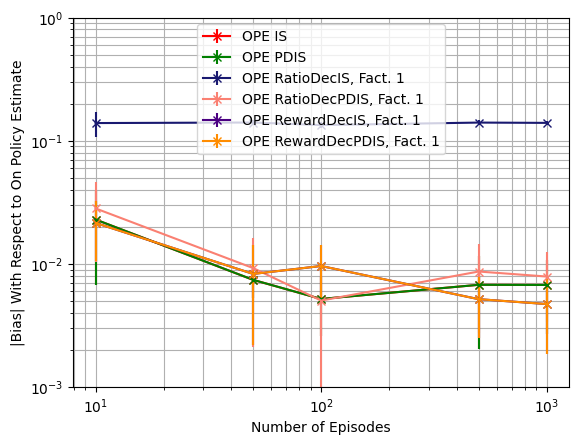

In [ ]:
label = 'bias'
plot_graphs(bias_means, bias_stds, label, 10**-3, 10**0, shorter_D, factorisation=1)

OPE IS-----[0.02291979 0.00741952 0.00519439 0.00676744 0.00675038]
OPE PDIS-----[0.02291979 0.00741952 0.00519439 0.00676744 0.00675038]
OPE RatioDecIS, Fact. 2-----[0.10457485 0.10968445 0.11117263 0.10645115 0.1053467 ]
OPE RatioDecPDIS, Fact. 2-----[0.03433752 0.00972199 0.00595909 0.00749761 0.00806404]
OPE RewardDecIS, Fact. 2-----[0.02150092 0.0082945  0.0096194  0.005174   0.00472512]
OPE RewardDecPDIS, Fact. 2-----[0.02150092 0.0082945  0.0096194  0.005174   0.00472512]


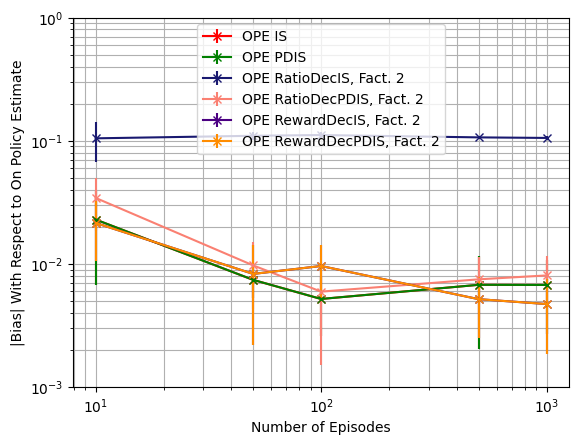

In [ ]:
plot_graphs(bias_means, bias_stds, label, 10**(-3), 10**0, shorter_D, factorisation=2)

OPE IS-----[0.02291979 0.00741952 0.00519439 0.00676744 0.00675038]
OPE PDIS-----[0.02291979 0.00741952 0.00519439 0.00676744 0.00675038]
OPE RatioDecIS, Fact. 3-----[0.05025721 0.05291377 0.05611555 0.05391736 0.05356939]
OPE RatioDecPDIS, Fact. 3-----[0.02647923 0.00829402 0.00392249 0.00430367 0.00427765]
OPE RewardDecIS, Fact. 3-----[0.02150092 0.0082945  0.0096194  0.005174   0.00472512]
OPE RewardDecPDIS, Fact. 3-----[0.02150092 0.0082945  0.0096194  0.005174   0.00472512]


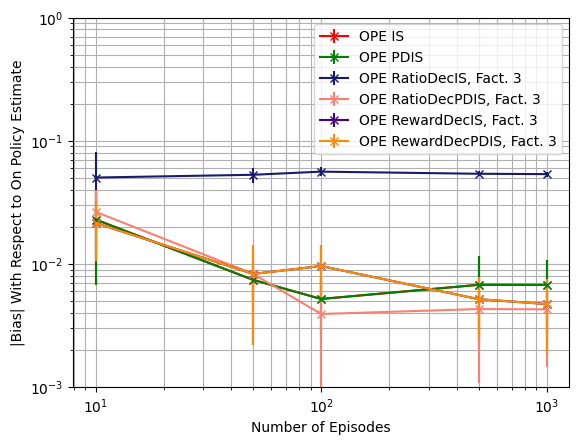

In [ ]:
plot_graphs(bias_means, bias_stds, label, 10**(-3), 10**0, shorter_D, factorisation=3)

OPE IS-----[0.02291979 0.00741952 0.00519439 0.00676744 0.00675038]
OPE PDIS-----[0.02291979 0.00741952 0.00519439 0.00676744 0.00675038]
OPE RatioDecIS, Fact. 4-----[0.0299745  0.01890746 0.0147171  0.01909325 0.01935035]
OPE RatioDecPDIS, Fact. 4-----[0.02642849 0.0093018  0.00490287 0.0072628  0.00717993]
OPE RewardDecIS, Fact. 4-----[0.31020901 0.31931964 0.32089546 0.31748606 0.31690678]
OPE RewardDecPDIS, Fact. 4-----[0.31020901 0.31931964 0.32089546 0.31748606 0.31690678]


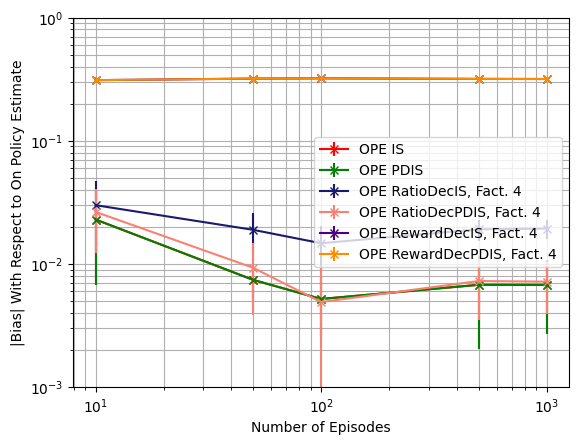

In [ ]:
plot_graphs(bias_means, bias_stds, label, 10**(-3), 10**0, shorter_D, factorisation=4)

##### Plot Variance

On Policy-----[6.60549152e-03 8.13293176e-04 3.89929595e-04 9.24533609e-05
 5.10652997e-05]
OPE IS-----[0.01643139 0.0025855  0.00155109 0.00044013 0.0002508 ]
OPE PDIS-----[0.01643139 0.0025855  0.00155109 0.00044013 0.0002508 ]
OPE RatioDecIS, Fact. 1-----[0.0133296  0.00294524 0.00157729 0.00030933 0.00019753]
OPE RatioDecPDIS, Fact. 1-----[0.01070679 0.00227369 0.0012593  0.00026227 0.00016678]
OPE RewardDecIS, Fact. 1-----[5.35378413e-03 8.98359636e-04 5.73930889e-04 1.42612579e-04
 7.76955068e-05]
OPE RewardDecPDIS, Fact. 1-----[5.35378413e-03 8.98359636e-04 5.73930889e-04 1.42612579e-04
 7.76955068e-05]


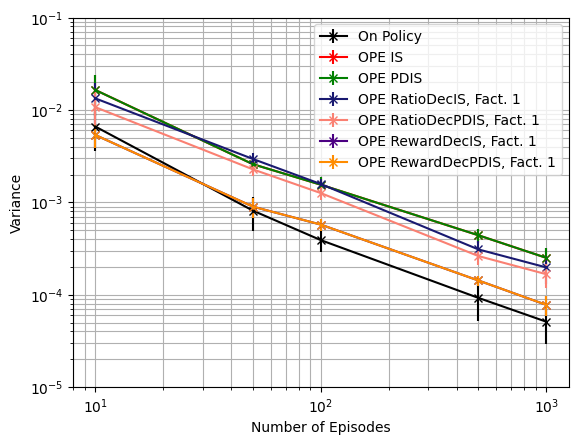

In [ ]:
label = 'var'
plot_graphs(var_means, var_stds, label, 10**(-5), 10**(-1), shorter_D, factorisation=1)

On Policy-----[6.60549152e-03 8.13293176e-04 3.89929595e-04 9.24533609e-05
 5.10652997e-05]
OPE IS-----[0.01643139 0.0025855  0.00155109 0.00044013 0.0002508 ]
OPE PDIS-----[0.01643139 0.0025855  0.00155109 0.00044013 0.0002508 ]
OPE RatioDecIS, Fact. 2-----[0.00988768 0.00208151 0.00113064 0.00031116 0.0001588 ]
OPE RatioDecPDIS, Fact. 2-----[0.01253789 0.00233821 0.00133494 0.00038389 0.00019452]
OPE RewardDecIS, Fact. 2-----[5.35378413e-03 8.98359636e-04 5.73930889e-04 1.42612579e-04
 7.76955068e-05]
OPE RewardDecPDIS, Fact. 2-----[5.35378413e-03 8.98359636e-04 5.73930889e-04 1.42612579e-04
 7.76955068e-05]


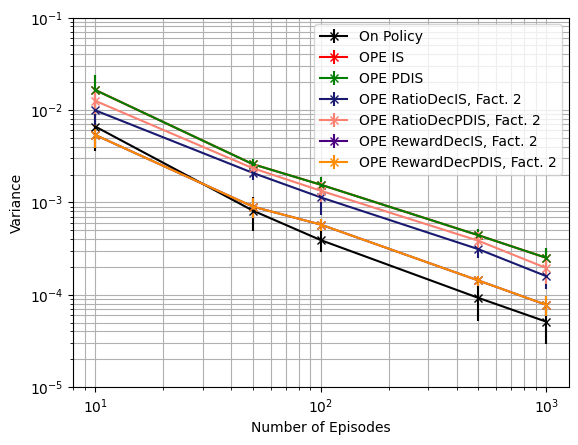

In [ ]:
plot_graphs(var_means, var_stds, label, 10**(-5), 10**(-1), shorter_D, factorisation=2)

On Policy-----[6.60549152e-03 8.13293176e-04 3.89929595e-04 9.24533609e-05
 5.10652997e-05]
OPE IS-----[0.01643139 0.0025855  0.00155109 0.00044013 0.0002508 ]
OPE PDIS-----[0.01643139 0.0025855  0.00155109 0.00044013 0.0002508 ]
OPE RatioDecIS, Fact. 3-----[0.01243077 0.00230112 0.00126364 0.0003807  0.00017627]
OPE RatioDecPDIS, Fact. 3-----[0.01381608 0.00250149 0.00144862 0.00042384 0.00019736]
OPE RewardDecIS, Fact. 3-----[5.35378413e-03 8.98359636e-04 5.73930889e-04 1.42612579e-04
 7.76955068e-05]
OPE RewardDecPDIS, Fact. 3-----[5.35378413e-03 8.98359636e-04 5.73930889e-04 1.42612579e-04
 7.76955068e-05]


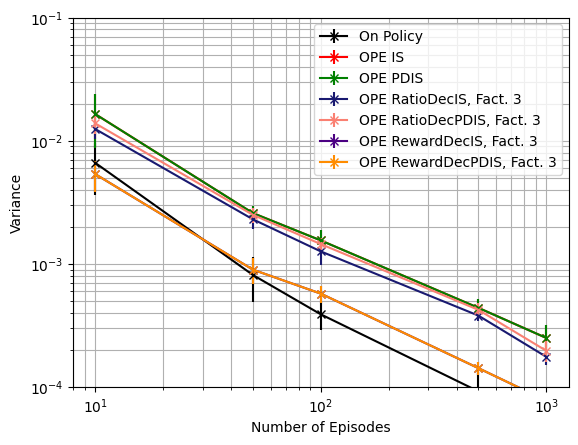

In [ ]:
plot_graphs(var_means, var_stds, label, 10**(-4), 10**(-1), shorter_D, factorisation=3)

On Policy-----[6.60549152e-03 8.13293176e-04 3.89929595e-04 9.24533609e-05
 5.10652997e-05]
OPE IS-----[0.01643139 0.0025855  0.00155109 0.00044013 0.0002508 ]
OPE PDIS-----[0.01643139 0.0025855  0.00155109 0.00044013 0.0002508 ]
OPE RatioDecIS, Fact. 4-----[0.0085698  0.00196748 0.00097285 0.00024008 0.00011817]
OPE RatioDecPDIS, Fact. 4-----[0.00900244 0.00182073 0.0009501  0.00025421 0.00012189]
OPE RewardDecIS, Fact. 4-----[2.37945962e-03 3.99270949e-04 2.55080395e-04 6.33833685e-05
 3.45313363e-05]
OPE RewardDecPDIS, Fact. 4-----[2.37945962e-03 3.99270949e-04 2.55080395e-04 6.33833685e-05
 3.45313363e-05]


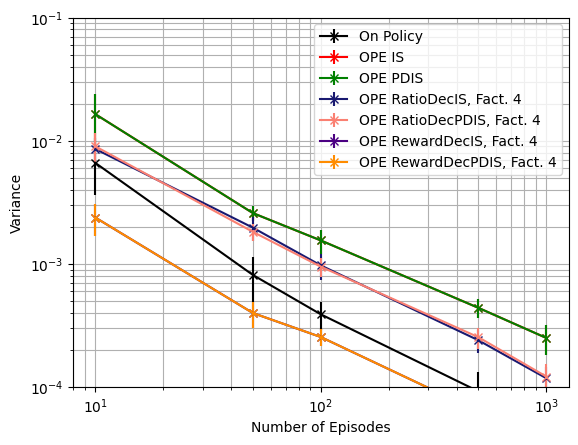

In [ ]:
plot_graphs(var_means, var_stds, label, 10**(-4), 10**(-1), shorter_D, factorisation=4)

##### Plot MSE

On Policy-----[6.60549152e-03 8.13293176e-04 3.89929595e-04 9.24533609e-05
 5.10652997e-05]
OPE IS-----[0.01721897 0.00264529 0.00158471 0.00050822 0.00031285]
OPE PDIS-----[0.01721897 0.00264529 0.00158471 0.00050822 0.00031285]
OPE RatioDecIS, Fact. 1-----[0.03369293 0.02275246 0.0195784  0.02005658 0.01970042]
OPE RatioDecPDIS, Fact. 1-----[0.01181965 0.00241005 0.00131602 0.00037246 0.00024946]
OPE RewardDecIS, Fact. 1-----[0.00593653 0.00100412 0.00068751 0.00017654 0.00010817]
OPE RewardDecPDIS, Fact. 1-----[0.00593653 0.00100412 0.00068751 0.00017654 0.00010817]


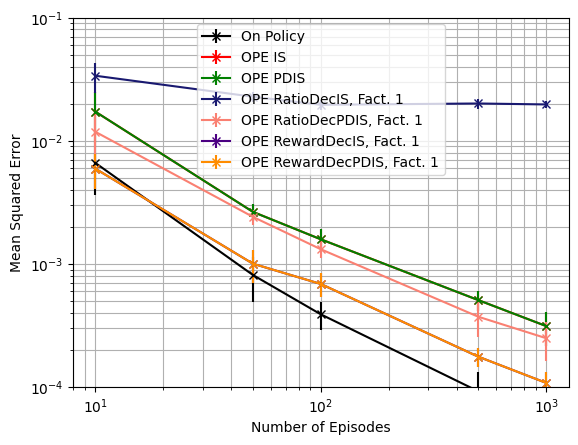

In [ ]:
label = 'MSE'
plot_graphs(MSE_means, MSE_stds, label, 10**(-4), 10**(-1), shorter_D, factorisation=1)

On Policy-----[6.60549152e-03 8.13293176e-04 3.89929595e-04 9.24533609e-05
 5.10652997e-05]
OPE IS-----[0.01721897 0.00264529 0.00158471 0.00050822 0.00031285]
OPE PDIS-----[0.01721897 0.00264529 0.00158471 0.00050822 0.00031285]
OPE RatioDecIS, Fact. 2-----[0.02222436 0.01418384 0.01352714 0.01165519 0.01126894]
OPE RatioDecPDIS, Fact. 2-----[0.01397054 0.00246245 0.00139017 0.00045601 0.00027187]
OPE RewardDecIS, Fact. 2-----[0.00593653 0.00100412 0.00068751 0.00017654 0.00010817]
OPE RewardDecPDIS, Fact. 2-----[0.00593653 0.00100412 0.00068751 0.00017654 0.00010817]


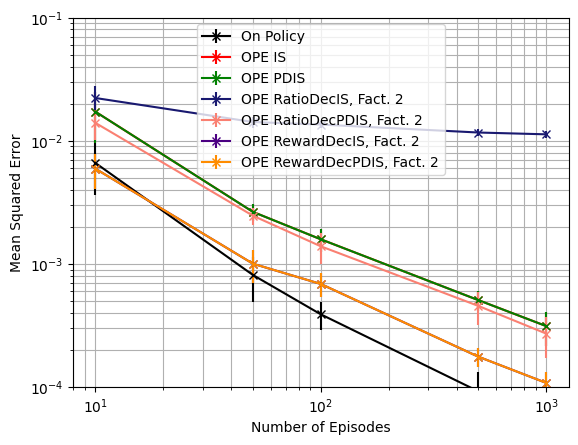

In [ ]:
plot_graphs(MSE_means, MSE_stds, label, 10**(-4), 10**(-1), shorter_D, factorisation=2)

On Policy-----[6.60549152e-03 8.13293176e-04 3.89929595e-04 9.24533609e-05
 5.10652997e-05]
OPE IS-----[0.01721897 0.00264529 0.00158471 0.00050822 0.00031285]
OPE PDIS-----[0.01721897 0.00264529 0.00158471 0.00050822 0.00031285]
OPE RatioDecIS, Fact. 3-----[0.01591229 0.00515652 0.00443465 0.0032937  0.00305293]
OPE RatioDecPDIS, Fact. 3-----[0.01468883 0.00259003 0.00147725 0.00045273 0.00022359]
OPE RewardDecIS, Fact. 3-----[0.00593653 0.00100412 0.00068751 0.00017654 0.00010817]
OPE RewardDecPDIS, Fact. 3-----[0.00593653 0.00100412 0.00068751 0.00017654 0.00010817]


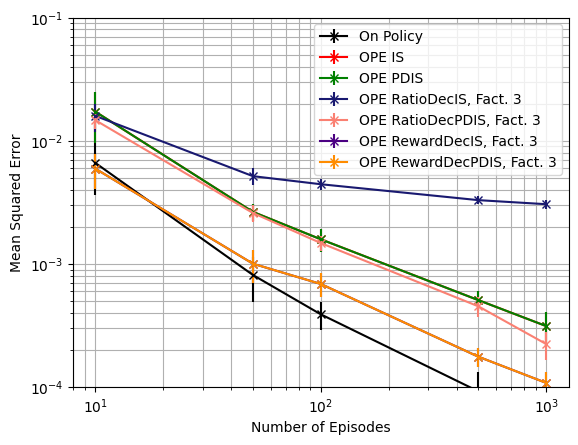

In [ ]:
plot_graphs(MSE_means, MSE_stds, label, 10**(-4), 10**(-1), shorter_D, factorisation=3)

On Policy-----[6.60549152e-03 8.13293176e-04 3.89929595e-04 9.24533609e-05
 5.10652997e-05]
OPE IS-----[0.01721897 0.00264529 0.00158471 0.00050822 0.00031285]
OPE PDIS-----[0.01721897 0.00264529 0.00158471 0.00050822 0.00031285]
OPE RatioDecIS, Fact. 4-----[0.00976159 0.0023709  0.00122244 0.00061915 0.00050355]
OPE RatioDecPDIS, Fact. 4-----[0.00990392 0.00193679 0.00099655 0.00032127 0.00018391]
OPE RewardDecIS, Fact. 4-----[0.09896301 0.10240628 0.10325085 0.10086599 0.10047102]
OPE RewardDecPDIS, Fact. 4-----[0.09896301 0.10240628 0.10325085 0.10086599 0.10047102]


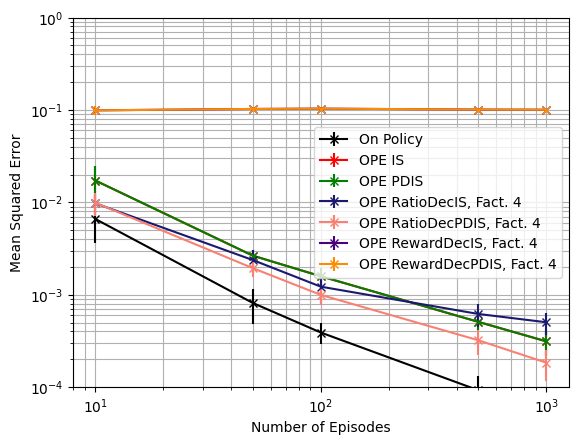

In [ ]:
plot_graphs(MSE_means, MSE_stds, label, 10**(-4), 10**(0), shorter_D, factorisation=4)

##### Plot ESS

On Policy-----[  10.   50.  100.  500. 1000.]
OPE IS-----[  4.3882656   16.12250409  25.48812939 105.61255363 214.60795575]
OPE PDIS-----[  4.3882656   16.12250409  25.48812939 105.61255363 214.60795575]
OPE RatioDecIS, Fact. 1-----[  5.76205072  13.93107341  24.83348066 162.07117125 277.15717505]
OPE RatioDecPDIS, Fact. 1-----[  7.34157398  17.88301322  31.50233076 193.42290616 323.82221794]
OPE RewardDecIS, Fact. 1-----[ 12.63828808  48.41074338  67.38590213 337.69304978 680.76077364]
OPE RewardDecPDIS, Fact. 1-----[ 12.63828808  48.41074338  67.38590213 337.69304978 680.76077364]


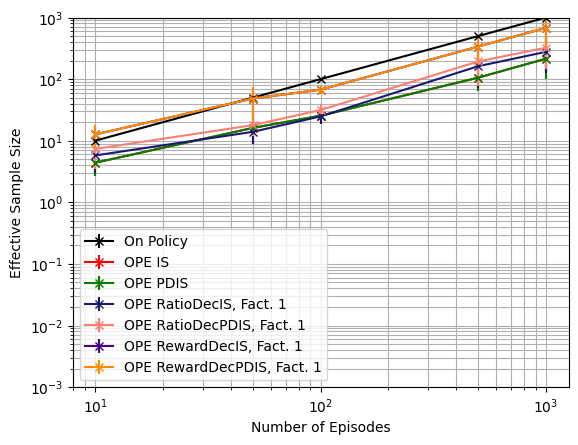

In [ ]:
label = 'ESS'
plot_graphs(ESS_means, ESS_stds, label, 10**(-3), 10**3, shorter_D, factorisation=1)

On Policy-----[  10.   50.  100.  500. 1000.]
OPE IS-----[  4.3882656   16.12250409  25.48812939 105.61255363 214.60795575]
OPE PDIS-----[  4.3882656   16.12250409  25.48812939 105.61255363 214.60795575]
OPE RatioDecIS, Fact. 2-----[  6.40935761  20.37003151  39.0561305  151.78325806 331.74122006]
OPE RatioDecPDIS, Fact. 2-----[  5.12050818  17.53113157  31.67487128 125.01047071 275.23929663]
OPE RewardDecIS, Fact. 2-----[ 12.63828808  48.41074338  67.38590213 337.69304978 680.76077364]
OPE RewardDecPDIS, Fact. 2-----[ 12.63828808  48.41074338  67.38590213 337.69304978 680.76077364]


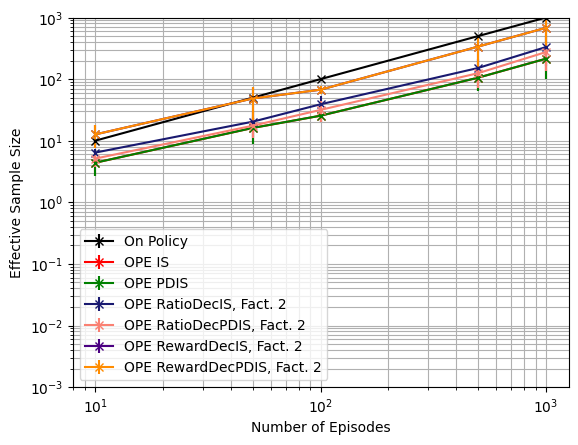

In [ ]:
plot_graphs(ESS_means, ESS_stds, label, 10**(-3), 10**3, shorter_D, factorisation=2)

On Policy-----[  10.   50.  100.  500. 1000.]
OPE IS-----[  4.3882656   16.12250409  25.48812939 105.61255363 214.60795575]
OPE PDIS-----[  4.3882656   16.12250409  25.48812939 105.61255363 214.60795575]
OPE RatioDecIS, Fact. 3-----[  5.69765786  18.40581549  32.60623099 122.27128416 301.20454709]
OPE RatioDecPDIS, Fact. 3-----[  5.01007938  16.82455623  27.09401492 110.45987604 272.55832504]
OPE RewardDecIS, Fact. 3-----[ 12.63828808  48.41074338  67.38590213 337.69304978 680.76077364]
OPE RewardDecPDIS, Fact. 3-----[ 12.63828808  48.41074338  67.38590213 337.69304978 680.76077364]


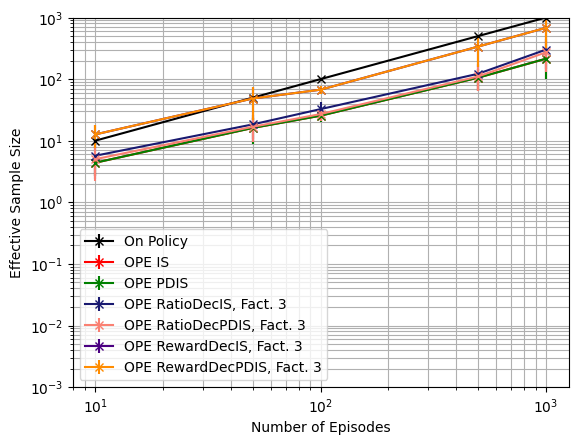

In [ ]:
plot_graphs(ESS_means, ESS_stds, label, 10**(-3), 10**3, shorter_D, factorisation=3)

On Policy-----[  10.   50.  100.  500. 1000.]
OPE IS-----[  4.3882656   16.12250409  25.48812939 105.61255363 214.60795575]
OPE PDIS-----[  4.3882656   16.12250409  25.48812939 105.61255363 214.60795575]
OPE RatioDecIS, Fact. 4-----[  8.10448492  21.78279487  42.74827652 199.93022636 452.01781045]
OPE RatioDecPDIS, Fact. 4-----[  8.06717078  22.78444498  42.83028831 189.98617351 444.07772853]
OPE RewardDecIS, Fact. 4-----[  28.43614818  108.9241726   151.61827978  759.80936201 1531.71174069]
OPE RewardDecPDIS, Fact. 4-----[  28.43614818  108.9241726   151.61827978  759.80936201 1531.71174069]


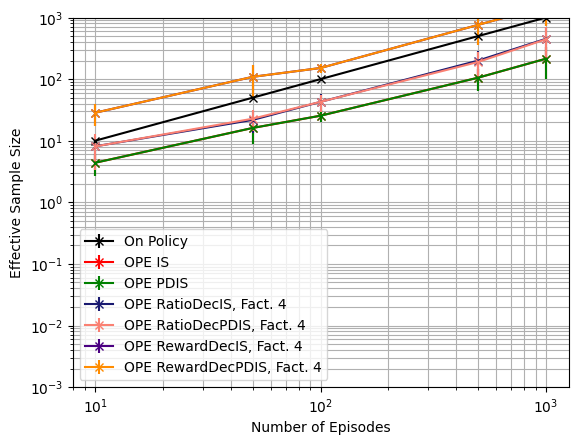

In [ ]:
plot_graphs(ESS_means, ESS_stds, label, 10**(-3), 10**3, shorter_D, factorisation=4)

# Test Out on 1 State MDP

In [ ]:
#Change our working directory
if os.getcwd() == '/content':
  os.chdir('./Factored-Action-Spaces-for-OPE')

## Varying Number of Episodes: Policy Divergence 1.44

**Note**: Restart the runtime before running all code in this section

### Generate Data Set

In [ ]:
!python generate_dataset.py 1-step-MDP 10000000 1

Policy divergence: 1.44
Start state: state, start state no: 0


### Run Estimates on Collected Data Sets

In [ ]:
from load_datasets import load_MDP_transitions

MDP_NAME = '1-step-MDP'
START_STATE_NO = 0
NO_TRAJECTORIES = 10000000
TRAJECTORY_LENGTH = 1
SHORTER_D = 1.44
VERSION_NUMBER = 5

nf_transitions_b, nf_transitions_e, f_transitions_b, f_transitions_e = load_MDP_transitions(MDP_NAME,
                                                                                            START_STATE_NO,
                                                                                            NO_TRAJECTORIES,
                                                                                            TRAJECTORY_LENGTH,
                                                                                            SHORTER_D,
                                                                                            VERSION_NUMBER)

In [ ]:
import sys
sys.argv[1] = MDP_NAME
import numpy as np
import policy_estimators as pe
from load_discrete_MDP import pi_b, pi_e
from load_discrete_MDP import factored_behaviour_policies, factored_evaluation_policies, factored_state_action_maps, factored_state_abstractions, factored_Rs
from load_discrete_MDP import action_spaces, action_space_mapping
import gc

def evaluate_PE(RUNS, NUM_EPISODES):

  # Reshape data for processing
  T, ldim = nf_transitions_b.shape[-2], nf_transitions_b.shape[-1]
  nfb = nf_transitions_b.reshape((-1, NUM_EPISODES, T, ldim))
  nfe = nf_transitions_e.reshape((-1, NUM_EPISODES, T, ldim))
  T, D, ldim = f_transitions_b.shape[-3], f_transitions_b.shape[-2], f_transitions_b.shape[-1]
  fb = f_transitions_b.reshape((-1, NUM_EPISODES, T, D, ldim))
  fe = f_transitions_e.reshape((-1, NUM_EPISODES, T, D, ldim))

  lower_index = 0
  estimates_on_policy = np.zeros(RUNS)
  estimates_OPE_IS = np.zeros(RUNS)
  estimates_OPE_PDIS = np.zeros(RUNS)
  estimates_OPE_RatioDecIS = np.zeros(RUNS)
  estimates_OPE_RewardDecIS = np.zeros(RUNS)
  estimates_OPE_RatioDecPDIS = np.zeros(RUNS)
  estimates_OPE_RewardDecPDIS = np.zeros(RUNS)

  for run in range(RUNS):
      #On policy Q estimate
      estimates_on_policy[run] = pe.on_policy_Q_estimate(nfe[run], 0.7)
      #Off policy IS estimate
      estimates_OPE_IS[run] = pe.off_policy_IS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy PDIS estimate
      estimates_OPE_PDIS[run] = pe.off_policy_PDIS_estimator(nfb[run], 0.7, pi_b, pi_e)
      #Off policy decomposed IS estimate
      estimates_OPE_RatioDecIS[run] = off_policy_RatioDecIS_estimator(nfb[run], fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDIS estimate
      estimates_OPE_RewardDecIS[run] = off_policy_RewardDecIS_estimator(nfb[run], fb[run], 0.7, action_spaces, pi_b, pi_e)
      #Off policy decomposed IS estimate
      estimates_OPE_RatioDecPDIS[run] = off_policy_RatioDecPDIS_estimator(nfb[run], fb[run], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDIS estimate
      estimates_OPE_RewardDecPDIS[run] = off_policy_RewardDecPDIS_estimator(nfb[run], fb[run], 0.7, action_spaces, pi_b, pi_e)

  mean_on_policy = np.mean(estimates_on_policy)
  var_on_policy = np.var(estimates_on_policy, ddof=0)
  print(f'Mean on policy Q estimate: {mean_on_policy}. Variance of on policy Q estimate: {var_on_policy}')

  from sklearn.metrics import mean_squared_error

  MSE_OPE_IS = mean_squared_error(estimates_OPE_IS, [mean_on_policy]*RUNS)
  mean_OPE_IS = np.mean(estimates_OPE_IS)
  var_OPE_IS = np.var(estimates_OPE_IS, ddof=0)
  bias1_OPE_IS = np.sqrt(MSE_OPE_IS - var_OPE_IS)
  bias2_OPE_IS = abs(mean_OPE_IS - mean_on_policy)
  print(f'Mean off policy IS estimate: {mean_OPE_IS}. Bias1: {bias1_OPE_IS}. Bias2: {bias2_OPE_IS}. Variance: {var_OPE_IS}. MSE: {MSE_OPE_IS}')

  MSE_OPE_PDIS = mean_squared_error(estimates_OPE_PDIS, [mean_on_policy]*RUNS)
  mean_OPE_PDIS = np.mean(estimates_OPE_PDIS)
  var_OPE_PDIS = np.var(estimates_OPE_PDIS, ddof=0)
  bias1_OPE_PDIS = np.sqrt(MSE_OPE_PDIS - var_OPE_PDIS)
  bias2_OPE_PDIS = abs(mean_OPE_PDIS - mean_on_policy)
  print(f'Mean off policy PDIS estimate: {mean_OPE_PDIS}. Bias1: {bias1_OPE_PDIS}. Bias2: {bias2_OPE_PDIS} Variance: {var_OPE_PDIS}. MSE: {MSE_OPE_PDIS}')

  MSE_OPE_RatioDecIS = mean_squared_error(estimates_OPE_RatioDecIS, [mean_on_policy]*RUNS)
  mean_OPE_RatioDecIS = np.mean(estimates_OPE_RatioDecIS)
  var_OPE_RatioDecIS = np.var(estimates_OPE_RatioDecIS, ddof=0)
  bias1_OPE_RatioDecIS = np.sqrt(MSE_OPE_RatioDecIS - var_OPE_RatioDecIS)
  bias2_OPE_RatioDecIS = abs(mean_OPE_RatioDecIS - mean_on_policy)
  print(f'Mean off policy RatioDecIS estimate: {mean_OPE_RatioDecIS}. Bias1: {bias1_OPE_RatioDecIS}. Bias2: {bias2_OPE_RatioDecIS}. Variance: {var_OPE_RatioDecIS}. MSE: {MSE_OPE_RatioDecIS}')

  MSE_OPE_RewardDecIS = mean_squared_error(estimates_OPE_RewardDecIS, [mean_on_policy]*RUNS)
  mean_OPE_RewardDecIS = np.mean(estimates_OPE_RewardDecIS)
  var_OPE_RewardDecIS = np.var(estimates_OPE_RewardDecIS, ddof=0)
  bias1_OPE_RewardDecIS = np.sqrt(MSE_OPE_RewardDecIS - var_OPE_RewardDecIS)
  bias2_OPE_RewardDecIS = abs(mean_OPE_RewardDecIS - mean_on_policy)
  print(f'Mean off policy RewardDecIS estimate: {mean_OPE_RewardDecIS}. Bias1: {bias1_OPE_RewardDecIS}. Bias2: {bias2_OPE_RewardDecIS}. Variance: {var_OPE_RewardDecIS}. MSE: {MSE_OPE_RewardDecIS}')

  MSE_OPE_RatioDecPDIS = mean_squared_error(estimates_OPE_RatioDecPDIS, [mean_on_policy]*RUNS)
  mean_OPE_RatioDecPDIS = np.mean(estimates_OPE_RatioDecPDIS)
  var_OPE_RatioDecPDIS = np.var(estimates_OPE_RatioDecPDIS, ddof=0)
  bias1_OPE_RatioDecPDIS = np.sqrt(MSE_OPE_RatioDecPDIS - var_OPE_RatioDecPDIS)
  bias2_OPE_RatioDecPDIS = abs(mean_OPE_RatioDecPDIS - mean_on_policy)
  print(f'Mean off policy RatioDecPDIS estimate: {mean_OPE_RatioDecPDIS}. Bias1: {bias1_OPE_RatioDecPDIS}. Bias2: {bias2_OPE_RatioDecPDIS}. Variance: {var_OPE_RatioDecPDIS}. MSE: {MSE_OPE_RatioDecPDIS}')

  MSE_OPE_RewardDecPDIS = mean_squared_error(estimates_OPE_RewardDecPDIS, [mean_on_policy]*RUNS)
  mean_OPE_RewardDecPDIS = np.mean(estimates_OPE_RewardDecPDIS)
  var_OPE_RewardDecPDIS = np.var(estimates_OPE_RewardDecPDIS, ddof=0)
  bias1_OPE_RewardDecPDIS = np.sqrt(MSE_OPE_RewardDecPDIS - var_OPE_RewardDecPDIS)
  bias2_OPE_RewardDecPDIS = abs(mean_OPE_RewardDecPDIS - mean_on_policy)
  print(f'Mean off policy RewardDecPDIS estimate: {mean_OPE_RewardDecPDIS}. Bias1: {bias1_OPE_RewardDecPDIS}. Bias2: {bias2_OPE_RewardDecPDIS}. Variance: {var_OPE_RewardDecPDIS}. MSE: {MSE_OPE_RewardDecPDIS}')

  means = np.array([mean_on_policy, mean_OPE_IS, mean_OPE_PDIS, mean_OPE_RatioDecIS, mean_OPE_RewardDecIS, mean_OPE_RatioDecPDIS, mean_OPE_RewardDecPDIS])
  MSEs = np.array([var_on_policy, MSE_OPE_IS, MSE_OPE_PDIS, MSE_OPE_RatioDecIS, MSE_OPE_RewardDecIS, MSE_OPE_RatioDecPDIS, MSE_OPE_RewardDecPDIS])
  vars = np.array([var_on_policy, var_OPE_IS, var_OPE_PDIS, var_OPE_RatioDecIS, var_OPE_RewardDecIS, var_OPE_RatioDecPDIS, var_OPE_RewardDecPDIS])
  biases = np.array([0, bias1_OPE_IS, bias1_OPE_PDIS, bias1_OPE_RatioDecIS, bias1_OPE_RewardDecIS, bias1_OPE_RatioDecPDIS, bias1_OPE_RewardDecPDIS])
  return means, biases, vars, MSEs

In [ ]:
means = np.zeros((9, 7))
biases = np.zeros((9, 7))
vars = np.zeros((9, 7))
MSEs = np.zeros((9, 7))

#### 100 runs, 10 episodes

In [ ]:
means[0, :], biases[0, :], vars[0, :], MSEs[0, :] = evaluate_PE(100, 10)
gc.collect()

Mean on policy Q estimate: 1.1770000000000003. Variance of on policy Q estimate: 0.03637099999999999
Mean off policy IS estimate: 1.17024. Bias1: 0.006759999999999368. Bias2: 0.006760000000000321. Variance: 0.11551242240000002. MSE: 0.11555812000000001
Mean off policy PDIS estimate: 1.17024. Bias1: 0.006759999999999368. Bias2: 0.006760000000000321 Variance: 0.11551242240000002. MSE: 0.11555812000000001
Mean off policy RatioDecIS estimate: 1.0761999999999998. Bias1: 0.10080000000000013. Bias2: 0.10080000000000044. Variance: 0.07864555999999999. MSE: 0.08880620000000002
Mean off policy RewardDecIS estimate: 1.065996928042202. Bias1: 0.11100307195779824. Bias2: 0.11100307195779835. Variance: 0.07871176277425199. MSE: 0.09103344475832012
Mean off policy RatioDecPDIS estimate: 1.0761999999999998. Bias1: 0.10080000000000013. Bias2: 0.10080000000000044. Variance: 0.07864555999999999. MSE: 0.08880620000000002
Mean off policy RewardDecPDIS estimate: 1.065996928042202. Bias1: 0.11100307195779824

19589

#### 1000 runs, 50 episodes

In [ ]:
means[1, :], biases[1, :], vars[1, :], MSEs[1, :] = evaluate_PE(100, 50)
gc.collect()

Mean on policy Q estimate: 1.1942. Variance of on policy Q estimate: 0.012482359999999996
Mean off policy IS estimate: 1.205184. Bias1: 0.010984000000000313. Bias2: 0.010984000000000105. Variance: 0.02502958694399998. MSE: 0.025150235199999985
Mean off policy PDIS estimate: 1.205184. Bias1: 0.010984000000000313. Bias2: 0.010984000000000105 Variance: 0.02502958694399998. MSE: 0.025150235199999985
Mean off policy RatioDecIS estimate: 1.10576. Bias1: 0.0884399999999999. Bias2: 0.08843999999999985. Variance: 0.01678826240000001. MSE: 0.024609895999999992
Mean off policy RewardDecIS estimate: 1.0955124790158512. Bias1: 0.09868752098414882. Bias2: 0.09868752098414868. Variance: 0.01683215074971491. MSE: 0.026571377547711723
Mean off policy RatioDecPDIS estimate: 1.10576. Bias1: 0.0884399999999999. Bias2: 0.08843999999999985. Variance: 0.01678826240000001. MSE: 0.024609895999999992
Mean off policy RewardDecPDIS estimate: 1.0955124790158512. Bias1: 0.09868752098414882. Bias2: 0.098687520984148

0

#### 1000 runs, 100 episodes

In [ ]:
means[2, :], biases[2, :], vars[2, :], MSEs[2, :] = evaluate_PE(100, 100)
gc.collect()

Mean on policy Q estimate: 1.2002. Variance of on policy Q estimate: 0.004797960000000001
Mean off policy IS estimate: 1.203552. Bias1: 0.0033519999999999882. Bias2: 0.0033520000000000216. Variance: 0.011547012096000018. MSE: 0.011558248000000017
Mean off policy PDIS estimate: 1.203552. Bias1: 0.0033519999999999882. Bias2: 0.0033520000000000216 Variance: 0.011547012096000018. MSE: 0.011558248000000017
Mean off policy RatioDecIS estimate: 1.1038199999999998. Bias1: 0.09637999999999984. Bias2: 0.09638000000000013. Variance: 0.0076273676000000006. MSE: 0.01691647199999997
Mean off policy RewardDecIS estimate: 1.0936310709142227. Bias1: 0.10656892908577699. Bias2: 0.1065689290857772. Variance: 0.007658483846211634. MSE: 0.019015420492701
Mean off policy RatioDecPDIS estimate: 1.1038199999999998. Bias1: 0.09637999999999984. Bias2: 0.09638000000000013. Variance: 0.0076273676000000006. MSE: 0.01691647199999997
Mean off policy RewardDecPDIS estimate: 1.0936310709142227. Bias1: 0.10656892908577

0

#### 1000 runs, 500 episodes

In [ ]:
means[3, :], biases[3, :], vars[3, :], MSEs[3, :] = evaluate_PE(100, 500)
gc.collect()

Mean on policy Q estimate: 1.1983. Variance of on policy Q estimate: 0.0008923500000000017
Mean off policy IS estimate: 1.2007488. Bias1: 0.0024488000000000925. Bias2: 0.0024488000000000287. Variance: 0.002346090946559999. MSE: 0.0023520875679999996
Mean off policy PDIS estimate: 1.2007488. Bias1: 0.0024488000000000925. Bias2: 0.0024488000000000287 Variance: 0.002346090946559999. MSE: 0.0023520875679999996
Mean off policy RatioDecIS estimate: 1.1005639999999999. Bias1: 0.09773599999999992. Bias2: 0.09773600000000005. Variance: 0.0015430787040000005. MSE: 0.011095404399999984
Mean off policy RewardDecIS estimate: 1.0904680097875017. Bias1: 0.10783199021249824. Bias2: 0.10783199021249823. Variance: 0.0015500850490649829. MSE: 0.013177823162253301
Mean off policy RatioDecPDIS estimate: 1.1005639999999999. Bias1: 0.09773599999999992. Bias2: 0.09773600000000005. Variance: 0.0015430787040000005. MSE: 0.011095404399999984
Mean off policy RewardDecPDIS estimate: 1.0904680097875017. Bias1: 0.10

0

#### 1000 runs, 1000 episodes

In [ ]:
means[4, :], biases[4, :], vars[4, :], MSEs[4, :] = evaluate_PE(100, 1000)
gc.collect()

Mean on policy Q estimate: 1.20043. Variance of on policy Q estimate: 0.0006304851000000005
Mean off policy IS estimate: 1.201152. Bias1: 0.0007220000000000146. Bias2: 0.0007219999999998894. Variance: 0.0009072046080000006. MSE: 0.0009077258920000006
Mean off policy PDIS estimate: 1.201152. Bias1: 0.0007220000000000146. Bias2: 0.0007219999999998894 Variance: 0.0009072046080000006. MSE: 0.0009077258920000006
Mean off policy RatioDecIS estimate: 1.100516. Bias1: 0.0999140000000001. Bias2: 0.09991400000000006. Variance: 0.0005881713439999995. MSE: 0.01057097874000002
Mean off policy RewardDecIS estimate: 1.090458801665044. Bias1: 0.10997119833495593. Bias2: 0.10997119833495606. Variance: 0.0005915044260602984. MSE: 0.012685168889286511
Mean off policy RatioDecPDIS estimate: 1.100516. Bias1: 0.0999140000000001. Bias2: 0.09991400000000006. Variance: 0.0005881713439999995. MSE: 0.01057097874000002
Mean off policy RewardDecPDIS estimate: 1.090458801665044. Bias1: 0.10997119833495593. Bias2: 0

0

#### 1000 runs, 5000 episodes

In [ ]:
means[5, :], biases[5, :], vars[5, :], MSEs[5, :] = evaluate_PE(100, 5000)
gc.collect()

Mean on policy Q estimate: 1.2004039999999998. Variance of on policy Q estimate: 0.00010420958400000018
Mean off policy IS estimate: 1.19800704. Bias1: 0.0023969599999997516. Bias2: 0.0023969599999997815. Variance: 0.00016736977059839995. MSE: 0.00017311518783999876
Mean off policy PDIS estimate: 1.19800704. Bias1: 0.0023969599999997516. Bias2: 0.0023969599999997815 Variance: 0.00016736977059839995. MSE: 0.00017311518783999876
Mean off policy RatioDecIS estimate: 1.0981028000000002. Bias1: 0.10230119999999976. Bias2: 0.10230119999999965. Variance: 0.00010970925615999982. MSE: 0.01057524477759995
Mean off policy RewardDecIS estimate: 1.088024629806248. Bias1: 0.11237937019375203. Bias2: 0.11237937019375188. Variance: 0.00011023278610652185. MSE: 0.012739355631250884
Mean off policy RatioDecPDIS estimate: 1.0981028000000002. Bias1: 0.10230119999999976. Bias2: 0.10230119999999965. Variance: 0.00010970925615999982. MSE: 0.01057524477759995
Mean off policy RewardDecPDIS estimate: 1.08802462

0

#### 1000 runs, 10000 episodes

In [ ]:
means[6, :], biases[6, :], vars[6, :], MSEs[6, :] = evaluate_PE(100, 10000)
gc.collect()

Mean on policy Q estimate: 1.2001219999999997. Variance of on policy Q estimate: 5.286491600000011e-05
Mean off policy IS estimate: 1.19866944. Bias1: 0.001452559999999622. Bias2: 0.001452559999999714. Variance: 7.499299184640013e-05. MSE: 7.710292239999903e-05
Mean off policy PDIS estimate: 1.19866944. Bias1: 0.001452559999999622. Bias2: 0.001452559999999714 Variance: 7.499299184640013e-05. MSE: 7.710292239999903e-05
Mean off policy RatioDecIS estimate: 1.0988396. Bias1: 0.10128239999999966. Bias2: 0.10128239999999966. Variance: 4.803295983999991e-05. MSE: 0.010306157509599932
Mean off policy RewardDecIS estimate: 1.0887427612151803. Bias1: 0.1113792387848193. Bias2: 0.11137923878481937. Variance: 4.83609606839994e-05. MSE: 0.012453695792969796
Mean off policy RatioDecPDIS estimate: 1.0988396. Bias1: 0.10128239999999966. Bias2: 0.10128239999999966. Variance: 4.803295983999991e-05. MSE: 0.010306157509599932
Mean off policy RewardDecPDIS estimate: 1.0887427612151803. Bias1: 0.1113792387

0

#### 1000 runs, 50000 episodes

In [ ]:
means[7, :], biases[7, :], vars[7, :], MSEs[7, :] = evaluate_PE(100, 50000)
gc.collect()

Mean on policy Q estimate: 1.2001414. Variance of on policy Q estimate: 9.41217004000002e-06
Mean off policy IS estimate: 1.1997239040000003. Bias1: 0.0004174959999998351. Bias2: 0.0004174959999996286. Variance: 1.737196668518406e-05. MSE: 1.7546269595199922e-05
Mean off policy PDIS estimate: 1.1997239040000003. Bias1: 0.0004174959999998351. Bias2: 0.0004174959999996286 Variance: 1.737196668518406e-05. MSE: 1.7546269595199922e-05
Mean off policy RatioDecIS estimate: 1.0997392799999999. Bias1: 0.1004021199999999. Bias2: 0.10040212000000004. Variance: 1.130312076159997e-05. MSE: 0.010091888821255978
Mean off policy RewardDecIS estimate: 1.089640323825198. Bias1: 0.11050107617480204. Bias2: 0.11050107617480198. Variance: 1.1359453551045775e-05. MSE: 0.01222184728934045
Mean off policy RatioDecPDIS estimate: 1.0997392799999999. Bias1: 0.1004021199999999. Bias2: 0.10040212000000004. Variance: 1.130312076159997e-05. MSE: 0.010091888821255978
Mean off policy RewardDecPDIS estimate: 1.08964032

0

#### 1000 runs 100000 episodes

In [ ]:
means[8, :], biases[8, :], vars[8, :], MSEs[8, :] = evaluate_PE(100, 100000)
gc.collect()

Mean on policy Q estimate: 1.2001283. Variance of on policy Q estimate: 4.323680110000011e-06
Mean off policy IS estimate: 1.199247456. Bias1: 0.0008808439999999401. Bias2: 0.0008808440000001028. Variance: 9.681372785664003e-06. MSE: 1.0457258937999897e-05
Mean off policy PDIS estimate: 1.199247456. Bias1: 0.0008808439999999401. Bias2: 0.0008808440000001028 Variance: 9.681372785664003e-06. MSE: 1.0457258937999897e-05
Mean off policy RatioDecIS estimate: 1.0993769. Bias1: 0.10075140000000003. Bias2: 0.10075140000000005. Variance: 6.340652909999937e-06. MSE: 0.010157185254870004
Mean off policy RewardDecIS estimate: 1.0892744424541676. Bias1: 0.11085385754583245. Bias2: 0.11085385754583243. Variance: 6.369440684519997e-06. MSE: 0.012294947173476232
Mean off policy RatioDecPDIS estimate: 1.0993769. Bias1: 0.10075140000000003. Bias2: 0.10075140000000005. Variance: 6.340652909999937e-06. MSE: 0.010157185254870004
Mean off policy RewardDecPDIS estimate: 1.0892744424541676. Bias1: 0.110853857

0

#### Write out the readings dict (to copy and paste)

In [ ]:
biases_dict = {
      'On Policy': list(biases[:, 0]),
      'OPE IS': list(biases[:, 1]),
      'OPE PDIS': list(biases[:, 2]),
      'OPE RatioDecIS': list(biases[:, 3]),
      'OPE RewardDecIS': list(biases[:, 4]),
      'OPE RatioDecPDIS': list(biases[:, 5]),
      'OPE RewardDecPDIS': list(biases[:, 6]),
  }

vars_dict = {
      'On Policy': list(vars[:, 0]),
      'OPE IS': list(vars[:, 1]),
      'OPE PDIS': list(vars[:, 2]),
      'OPE RatioDecIS': list(vars[:, 3]),
      'OPE RewardDecIS': list(vars[:, 4]),
      'OPE RatioDecPDIS': list(vars[:, 5]),
      'OPE RewardDecPDIS': list(vars[:, 6]),
  }

MSEs_dict = {
      'On Policy': list(MSEs[:, 0]),
      'OPE IS': list(MSEs[:, 1]),
      'OPE PDIS': list(MSEs[:, 2]),
      'OPE RatioDecIS': list(MSEs[:, 3]),
      'OPE RewardDecIS': list(MSEs[:, 4]),
      'OPE RatioDecPDIS': list(MSEs[:, 5]),
      'OPE RewardDecPDIS': list(MSEs[:, 6]),
  }

print(biases_dict)
print()
print(vars_dict)
print()
print(MSEs_dict)

{'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'OPE IS': [0.006759999999999368, 0.010984000000000313, 0.0033519999999999882, 0.0024488000000000925, 0.0007220000000000146, 0.0023969599999997516, 0.001452559999999622, 0.0004174959999998351, 0.0008808439999999401], 'OPE PDIS': [0.006759999999999368, 0.010984000000000313, 0.0033519999999999882, 0.0024488000000000925, 0.0007220000000000146, 0.0023969599999997516, 0.001452559999999622, 0.0004174959999998351, 0.0008808439999999401], 'OPE RatioDecIS': [0.10080000000000013, 0.0884399999999999, 0.09637999999999984, 0.09773599999999992, 0.0999140000000001, 0.10230119999999976, 0.10128239999999966, 0.1004021199999999, 0.10075140000000003], 'OPE RewardDecIS': [0.11100307195779824, 0.09868752098414882, 0.10656892908577699, 0.10783199021249824, 0.10997119833495593, 0.11237937019375203, 0.1113792387848193, 0.11050107617480204, 0.11085385754583245], 'OPE RatioDecPDIS': [0.10080000000000013, 0.0884399999999999, 0.09637999999999984, 0.09773

### Plot Graphs
<a id='vs_ep_pd_1_44'></a>
<a name="vs_ep_pd_1_44"></a>

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

def calculate_ESS(variances, episodes):
  ESS = {}
  on_policy_vars = variances['On Policy']
  for key in variances.keys():
    ESS[key] = []
    for ind in range(len(on_policy_vars)):
      ESS[key].append(episodes[ind] * on_policy_vars[ind]/variances[key][ind])
  return ESS

def generate_mean_std(readings, legend):
  arrays = None
  for r_dict in readings:
    add_val = np.expand_dims(np.array(r_dict[legend]), axis=0)
    if arrays is None:
      arrays = add_val
    else:
      arrays = np.concatenate((arrays, add_val), axis=0)

  return np.mean(arrays, axis=0), np.std(arrays, axis=0)

def plot_graphs(readings, label, low_ylim, up_ylim):
  EPISODES = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

  colours = {
      'On Policy': 'k',
      'OPE PDIS': 'b',
      'OPE RatioDecPDIS': 'g',
      'OPE RewardDecPDIS': 'r',
  }

  ylabels = {
      'bias': '|Bias| With Respect to On Policy Estimate',
      'var': 'Variance',
      'MSE': 'Mean Squared Error ($Variance \ + \ Bias^2$)',
      'ESS': 'Effective Sample Size'
  }

  legend_list = ['OPE PDIS', 'OPE RatioDecPDIS', 'OPE RewardDecPDIS']

  plt.figure()
  if label != 'bias':
    legend_list.insert(0,'On Policy')
  for legend in legend_list:
    mean_reading, std_reading = generate_mean_std(readings, legend)
    plt.errorbar(EPISODES, mean_reading, yerr=std_reading, color=colours[legend], marker='x')
  plt.yscale("log")
  plt.xscale("log")
  plt.grid(visible=True, which='both', axis='both')
  plt.legend(legend_list)
  plt.xlabel('Number of Episodes')
  plt.ylabel(ylabels[label])
  plt.ylim([low_ylim, up_ylim])
  plt.savefig(f'{label}-vs-episodes-policy-divergence-1-44.pdf', dpi=300)
  plt.show()


#### Bias

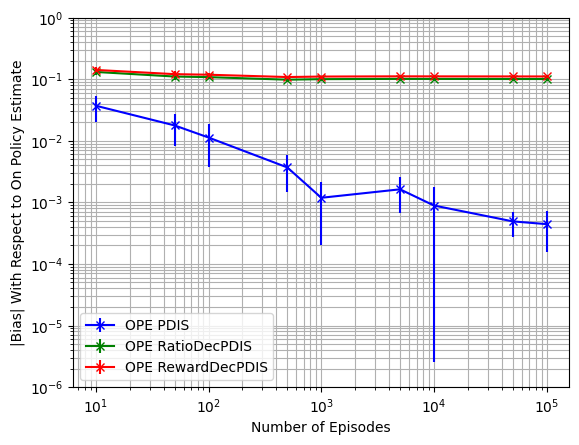

In [ ]:
biases1 = {'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
           'OPE IS': [0.04995999999999992, 0.012031999999999685, 0.0010480000000001165, 0.0048895999999998396, 0.0031512000000000367, 0.0031103999999997464, 0.002350160000000149, 0.0004421439999999933, 0.0006080080000000005],
           'OPE PDIS': [0.04995999999999992, 0.012031999999999685, 0.0010480000000001165, 0.0048895999999998396, 0.0031512000000000367, 0.0031103999999997464, 0.002350160000000149, 0.0004421439999999933, 0.0006080080000000005],
           'OPE RatioDecIS': [0.13940000000000002, 0.10807999999999982, 0.10101999999999978, 0.10481599999999978, 0.10331600000000012, 0.10275919999999973, 0.1022428000000002, 0.10041524000000006, 0.10055474000000005],
           'OPE RewardDecIS': [0.14974450067800513, 0.11843258231915971, 0.1111846841623129, 0.11489703917636196, 0.11339784734047774, 0.1128451689774663, 0.11232707183282427, 0.11051497605317365, 0.11065506399256765],
           'OPE RatioDecPDIS': [0.13940000000000002, 0.10807999999999982, 0.10101999999999978, 0.10481599999999978, 0.10331600000000012, 0.10275919999999973, 0.1022428000000002, 0.10041524000000006, 0.10055474000000005],
           'OPE RewardDecPDIS': [0.14974450067800513, 0.11843258231915971, 0.1111846841623129, 0.11489703917636196, 0.11339784734047774, 0.1128451689774663, 0.11232707183282427, 0.11051497605317365, 0.11065506399256765]}

biases2 = {'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
           'OPE IS': [0.03976000000000016, 0.03661600000000018, 0.01755600000000013, 0.006136000000000012, 0.0007396000000001918, 0.0010379199999998744, 0.0004305599999999851, 0.00039925600000014194, 0.00014753200000020505],
           'OPE PDIS': [0.03976000000000016, 0.03661600000000018, 0.01755600000000013, 0.006136000000000012, 0.0007396000000001918, 0.0010379199999998744, 0.0004305599999999851, 0.00039925600000014194, 0.00014753200000020505],
           'OPE RatioDecIS': [0.1344000000000001, 0.12872000000000008, 0.11365999999999994, 0.09396399999999994, 0.09861600000000002, 0.09902920000000014, 0.10030940000000005, 0.1003616800000002, 0.10015520000000026],
           'OPE RewardDecIS': [0.14454245964913795, 0.13897964344588104, 0.12381458211086968, 0.10407372900246124, 0.10873078002818304, 0.10914389921177162, 0.11042028063632595, 0.11046375164746745, 0.11025616648303965],
           'OPE RatioDecPDIS': [0.1344000000000001, 0.12872000000000008, 0.11365999999999994, 0.09396399999999994, 0.09861600000000002, 0.09902920000000014, 0.10030940000000005, 0.1003616800000002, 0.10015520000000026],
           'OPE RewardDecPDIS': [0.14454245964913795, 0.13897964344588104, 0.12381458211086968, 0.10407372900246124, 0.10873078002818304, 0.10914389921177162, 0.11042028063632595, 0.11046375164746745, 0.11025616648303965]}

biases3 = {'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
           'OPE IS': [0.05600000000000037, 0.015520000000000193, 0.01842400000000006, 1.0400000012998893e-05, 0.0006911999999998177, 0.0010256799999998993, 0.00017391999999972254, 0.0009028720000001075, 0.00046259999999985685],
           'OPE PDIS': [0.05600000000000037, 0.015520000000000193, 0.01842400000000006, 1.0400000012998893e-05, 0.0006911999999998177, 0.0010256799999998993, 0.00017391999999972254, 0.0009028720000001075, 0.00046259999999985685],
           'OPE RatioDecIS': [0.14740000000000017, 0.11391999999999998, 0.11551999999999986, 0.09929199999999987, 0.09967000000000005, 0.10102679999999989, 0.09977580000000034, 0.1007830400000002, 0.10038429999999991],
           'OPE RewardDecIS': [0.1579667458097593, 0.12415135770183951, 0.12580388836934467, 0.10947082703433379, 0.10983933110597723, 0.11113992329174621, 0.10988700390197242, 0.11088922520281523, 0.1104896548141863],
           'OPE RatioDecPDIS': [0.14740000000000017, 0.11391999999999998, 0.11551999999999986, 0.09929199999999987, 0.09967000000000005, 0.10102679999999989, 0.09977580000000034, 0.1007830400000002, 0.10038429999999991],
           'OPE RewardDecPDIS': [0.1579667458097593, 0.12415135770183951, 0.12580388836934467, 0.10947082703433379, 0.10983933110597723, 0.11113992329174621, 0.10988700390197242, 0.11088922520281523, 0.1104896548141863]}

biases4 = {'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
           'OPE IS': [0.03247999999999985, 0.013415999999999805, 0.015964000000000225, 0.004933600000000072, 0.0006204000000002813, 0.0005607999999999001, 2.8999999999775933e-05, 0.00029033599999985513, 0.00011298399999979921],
           'OPE PDIS': [0.03247999999999985, 0.013415999999999805, 0.015964000000000225, 0.004933600000000072, 0.0006204000000002813, 0.0005607999999999001, 2.8999999999775933e-05, 0.00029033599999985513, 0.00011298399999979921],
           'OPE RatioDecIS': [0.13179999999999997, 0.11175999999999994, 0.11184000000000002, 0.09395199999999987, 0.09827399999999986, 0.09936320000000011, 0.1000154, 0.10023943999999994, 0.10003303999999989],
           'OPE RewardDecIS': [0.1417606227231572, 0.12187417390509642, 0.12206125565039598, 0.10411264334173578, 0.1084471698855255, 0.10946533225977609, 0.11012286614293805, 0.11034135405546472, 0.11013544299475451],
           'OPE RatioDecPDIS': [0.13179999999999997, 0.11175999999999994, 0.11184000000000002, 0.09395199999999987, 0.09827399999999986, 0.09936320000000011, 0.1000154, 0.10023943999999994, 0.10003303999999989],
           'OPE RewardDecPDIS': [0.1417606227231572, 0.12187417390509642, 0.12206125565039598, 0.10411264334173578, 0.1084471698855255, 0.10946533225977609, 0.11012286614293805, 0.11034135405546472, 0.11013544299475451]}

biases5 = {'On Policy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
           'OPE IS': [0.006759999999999368, 0.010984000000000313, 0.0033519999999999882, 0.0024488000000000925, 0.0007220000000000146, 0.0023969599999997516, 0.001452559999999622, 0.0004174959999998351, 0.0008808439999999401],
           'OPE PDIS': [0.006759999999999368, 0.010984000000000313, 0.0033519999999999882, 0.0024488000000000925, 0.0007220000000000146, 0.0023969599999997516, 0.001452559999999622, 0.0004174959999998351, 0.0008808439999999401],
           'OPE RatioDecIS': [0.10080000000000013, 0.0884399999999999, 0.09637999999999984, 0.09773599999999992, 0.0999140000000001, 0.10230119999999976, 0.10128239999999966, 0.1004021199999999, 0.10075140000000003],
           'OPE RewardDecIS': [0.11100307195779824, 0.09868752098414882, 0.10656892908577699, 0.10783199021249824, 0.10997119833495593, 0.11237937019375203, 0.1113792387848193, 0.11050107617480204, 0.11085385754583245],
           'OPE RatioDecPDIS': [0.10080000000000013, 0.0884399999999999, 0.09637999999999984, 0.09773599999999992, 0.0999140000000001, 0.10230119999999976, 0.10128239999999966, 0.1004021199999999, 0.10075140000000003],
           'OPE RewardDecPDIS': [0.11100307195779824, 0.09868752098414882, 0.10656892908577699, 0.10783199021249824, 0.10997119833495593, 0.11237937019375203, 0.1113792387848193, 0.11050107617480204, 0.11085385754583245]}

biases = [biases1, biases2, biases3, biases4, biases5]

plot_graphs(biases, 'bias', 10**(-6), 10**(0))

#### Variance

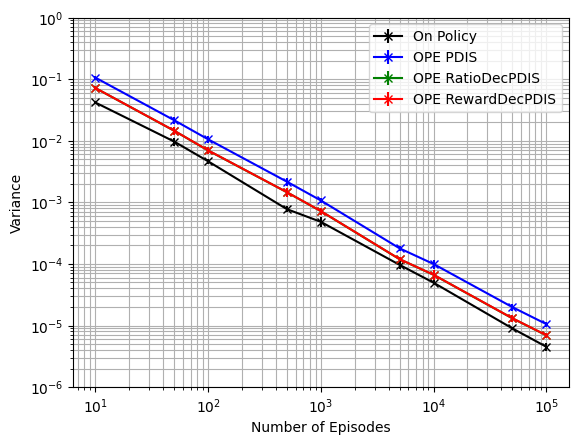

In [ ]:
vars1 = {'On Policy': [0.042099000000000004, 0.009549760000000001, 0.004320840000000001, 0.0006753600000000012, 0.0003641364000000005, 8.6610496e-05, 4.284529999999999e-05, 8.197221760000006e-06, 4.88578635999996e-06],
         'OPE IS': [0.10718115840000002, 0.02090129817599999, 0.01214973849600001, 0.002704879779839999, 0.0011811148185599982, 0.0001762293657600004, 0.00012706473277440022, 2.439082417766399e-05, 1.2483814772735995e-05],
         'OPE PDIS': [0.10718115840000002, 0.02090129817599999, 0.01214973849600001, 0.002704879779839999, 0.0011811148185599982, 0.0001762293657600004, 0.00012706473277440022, 2.439082417766399e-05, 1.2483814772735995e-05],
         'OPE RatioDecIS': [0.07303744, 0.014288825599999999, 0.008115143600000003, 0.0018844029439999972, 0.000810162623999999, 0.00011970952256000013, 8.568492415999965e-05, 1.6235369438399858e-05, 8.350526916400048e-06],
         'OPE RewardDecIS': [0.07311629663738424, 0.014295036228399364, 0.008138864825955135, 0.001882292796638632, 0.0008103820718235391, 0.00011982838599765076, 8.58731813363375e-05, 1.6288181572188038e-05, 8.373317210882913e-06],
         'OPE RatioDecPDIS': [0.07303744, 0.014288825599999999, 0.008115143600000003, 0.0018844029439999972, 0.000810162623999999, 0.00011970952256000013, 8.568492415999965e-05, 1.6235369438399858e-05, 8.350526916400048e-06],
         'OPE RewardDecPDIS': [0.07311629663738424, 0.014295036228399364, 0.008138864825955135, 0.001882292796638632, 0.0008103820718235391, 0.00011982838599765076, 8.58731813363375e-05, 1.6288181572188038e-05, 8.373317210882913e-06]}


vars2 = {'On Policy': [0.0411, 0.00860204, 0.004305710000000001, 0.0007772336000000014, 0.0004625675000000006, 8.669614399999998e-05, 4.78334159999999e-05, 9.096738999999982e-06, 3.5543141900000165e-06],
         'OPE IS': [0.1050061824, 0.021981855743999974, 0.010343844864000008, 0.001776724992000002, 0.0011642041958399997, 0.00018630585999360001, 0.00010552594544639995, 1.9557353816064093e-05, 1.0290996043776078e-05],
         'OPE PDIS': [0.1050061824, 0.021981855743999974, 0.010343844864000008, 0.001776724992000002, 0.0011642041958399997, 0.00018630585999360001, 0.00010552594544639995, 1.9557353816064093e-05, 1.0290996043776078e-05],
         'OPE RatioDecIS': [0.07006064, 0.014548945600000003, 0.006628350400000002, 0.0011880156639999988, 0.0007908256439999986, 0.00012780784175999956, 7.123153003999995e-05, 1.3117329297600084e-05, 6.698774590000008e-06],
         'OPE RewardDecIS': [0.07026242277301076, 0.01460354655532887, 0.006675768580934078, 0.001191020993853708, 0.0007918305237353818, 0.00012779331941980876, 7.135186486292841e-05, 1.3146194232633313e-05, 6.735346999859504e-06],
         'OPE RatioDecPDIS': [0.07006064, 0.014548945600000003, 0.006628350400000002, 0.0011880156639999988, 0.0007908256439999986, 0.00012780784175999956, 7.123153003999995e-05, 1.3117329297600084e-05, 6.698774590000008e-06],
         'OPE RewardDecPDIS': [0.07026242277301076, 0.01460354655532887, 0.006675768580934078, 0.001191020993853708, 0.0007918305237353818, 0.00012779331941980876, 7.135186486292841e-05, 1.3146194232633313e-05, 6.735346999859504e-06]}

vars3 = {'On Policy': [0.04457599999999999, 0.00809504, 0.004448760000000003, 0.0006826124000000011, 0.0005077464000000007, 8.329869999999985e-05, 4.837957599999992e-05, 8.497547640000017e-06, 4.310088999999996e-06],
         'OPE IS': [0.09536255999999999, 0.023792025599999968, 0.010212609024000016, 0.001904737443839999, 0.0009587696025600002, 0.00016130242805759986, 9.357161103360025e-05, 1.726816827801592e-05, 1.0520995737600078e-05],
         'OPE PDIS': [0.09536255999999999, 0.023792025599999968, 0.010212609024000016, 0.001904737443839999, 0.0009587696025600002, 0.00016130242805759986, 9.357161103360025e-05, 1.726816827801592e-05, 1.0520995737600078e-05],
         'OPE RatioDecIS': [0.06399883999999999, 0.016016857600000003, 0.006745841599999999, 0.0012384165760000016, 0.0006329090999999988, 0.00010748387776000007, 6.384615115999976e-05, 1.1115995230399971e-05, 6.640140510000117e-06],
         'OPE RewardDecIS': [0.06412419850809996, 0.016053035887107204, 0.006774459042560017, 0.0012454181460719502, 0.0006353828093483753, 0.0001077798591548816, 6.388230149597093e-05, 1.1185387553144667e-05, 6.697197201830531e-06],
         'OPE RatioDecPDIS': [0.06399883999999999, 0.016016857600000003, 0.006745841599999999, 0.0012384165760000016, 0.0006329090999999988, 0.00010748387776000007, 6.384615115999976e-05, 1.1115995230399971e-05, 6.640140510000117e-06],
         'OPE RewardDecPDIS': [0.06412419850809996, 0.016053035887107204, 0.006774459042560017, 0.0012454181460719502, 0.0006353828093483753, 0.0001077798591548816, 6.388230149597093e-05, 1.1185387553144667e-05, 6.697197201830531e-06]}

vars4 = {'On Policy': [0.0446, 0.009786360000000001, 0.00533611, 0.0008494604000000006, 0.00044798910000000067, 0.00012205585600000025, 5.6330739000000053e-05, 9.753629759999995e-06, 5.558300360000008e-06],
         'OPE IS': [0.10628904959999998, 0.016006201343999986, 0.008515067904000004, 0.002098081751040001, 0.0011561931878399997, 0.00020481444863999985, 9.754168319999966e-05, 2.0987213819903986e-05, 9.852179180543856e-06],
         'OPE PDIS': [0.10628904959999998, 0.016006201343999986, 0.008515067904000004, 0.002098081751040001, 0.0011561931878399997, 0.00020481444863999985, 9.754168319999966e-05, 2.0987213819903986e-05, 9.852179180543856e-06],
         'OPE RatioDecIS': [0.07297675999999999, 0.011065886399999995, 0.005645748400000001, 0.0014439771359999979, 0.0007778235839999997, 0.00013211906496000028, 6.410809504000003e-05, 1.3730221190399903e-05, 6.673700814399883e-06],
         'OPE RewardDecIS': [0.07296430739405482, 0.01105341123260954, 0.0056632234987700715, 0.001443665024241854, 0.0007794977115143724, 0.00013295697002885977, 6.437180964056013e-05, 1.3797529488952443e-05, 6.683488210980369e-06],
         'OPE RatioDecPDIS': [0.07297675999999999, 0.011065886399999995, 0.005645748400000001, 0.0014439771359999979, 0.0007778235839999997, 0.00013211906496000028, 6.410809504000003e-05, 1.3730221190399903e-05, 6.673700814399883e-06],
         'OPE RewardDecPDIS': [0.07296430739405482, 0.01105341123260954, 0.0056632234987700715, 0.001443665024241854, 0.0007794977115143724, 0.00013295697002885977, 6.437180964056013e-05, 1.3797529488952443e-05, 6.683488210980369e-06]}

vars5 = {'On Policy': [0.03637099999999999, 0.012482359999999996, 0.004797960000000001, 0.0008923500000000017, 0.0006304851000000005, 0.00010420958400000018, 5.286491600000011e-05, 9.41217004000002e-06, 4.323680110000011e-06],
         'OPE IS': [0.11551242240000002, 0.02502958694399998, 0.011547012096000018, 0.002346090946559999, 0.0009072046080000006, 0.00016736977059839995, 7.499299184640013e-05, 1.737196668518406e-05, 9.681372785664003e-06],
         'OPE PDIS': [0.11551242240000002, 0.02502958694399998, 0.011547012096000018, 0.002346090946559999, 0.0009072046080000006, 0.00016736977059839995, 7.499299184640013e-05, 1.737196668518406e-05, 9.681372785664003e-06],
         'OPE RatioDecIS': [0.07864555999999999, 0.01678826240000001, 0.0076273676000000006, 0.0015430787040000005, 0.0005881713439999995, 0.00010970925615999982, 4.803295983999991e-05, 1.130312076159997e-05, 6.340652909999937e-06],
         'OPE RewardDecIS': [0.07871176277425199, 0.01683215074971491, 0.007658483846211634, 0.0015500850490649829, 0.0005915044260602984, 0.00011023278610652185, 4.83609606839994e-05, 1.1359453551045775e-05, 6.369440684519997e-06],
         'OPE RatioDecPDIS': [0.07864555999999999, 0.01678826240000001, 0.0076273676000000006, 0.0015430787040000005, 0.0005881713439999995, 0.00010970925615999982, 4.803295983999991e-05, 1.130312076159997e-05, 6.340652909999937e-06],
         'OPE RewardDecPDIS': [0.07871176277425199, 0.01683215074971491, 0.007658483846211634, 0.0015500850490649829, 0.0005915044260602984, 0.00011023278610652185, 4.83609606839994e-05, 1.1359453551045775e-05, 6.369440684519997e-06]}

vars = [vars1, vars2, vars3, vars4, vars5]

plot_graphs(vars, 'var', 10**(-6), 10**0)

#### MSE

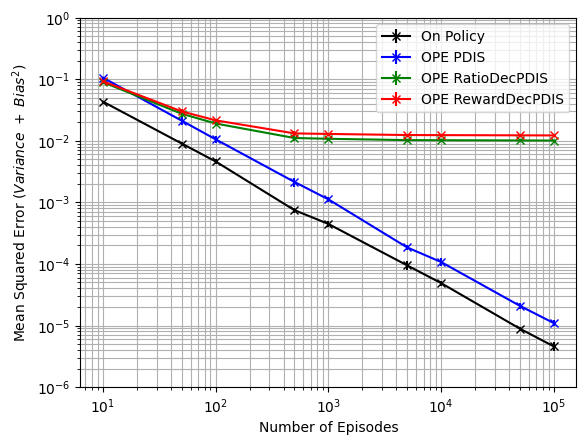

In [ ]:
MSEs1 = {'On Policy': [0.042099000000000004, 0.009549760000000001, 0.004320840000000001, 0.0006753600000000012, 0.0003641364000000005, 8.6610496e-05, 4.284529999999999e-05, 8.197221760000006e-06, 4.88578635999996e-06],
         'OPE IS': [0.10967716000000001, 0.021046067199999983, 0.01215083680000001, 0.0027287879679999973, 0.0011910448799999985, 0.00018590395391999883, 0.00013258798480000092, 2.4586315494399985e-05, 1.2853488500799996e-05],
         'OPE PDIS': [0.10967716000000001, 0.021046067199999983, 0.01215083680000001, 0.0027287879679999973, 0.0011910448799999985, 0.00018590395391999883, 0.00013258798480000092, 2.4586315494399985e-05, 1.2853488500799996e-05],
         'OPE RatioDecIS': [0.0924698, 0.02597011199999996, 0.018320183999999958, 0.012870796799999952, 0.011484358480000022, 0.010679162707199945, 0.01053927507600004, 0.010099455793696012, 0.01011960626338401],
         'OPE RewardDecIS': [0.09553971212068932, 0.028321312783183904, 0.02050089881822841, 0.015083622408133086, 0.013669453853277834, 0.012853860547550573, 0.012703244247872801, 0.012229848113605732, 0.012252916504410126],
         'OPE RatioDecPDIS': [0.0924698, 0.02597011199999996, 0.018320183999999958, 0.012870796799999952, 0.011484358480000022, 0.010679162707199945, 0.01053927507600004, 0.010099455793696012, 0.01011960626338401],
         'OPE RewardDecPDIS': [0.09553971212068932, 0.028321312783183904, 0.02050089881822841, 0.015083622408133086, 0.013669453853277834, 0.012853860547550573, 0.012703244247872801, 0.012229848113605732, 0.012252916504410126]}

MSEs2 = {'On Policy': [0.0411, 0.00860204, 0.004305710000000001, 0.0007772336000000014, 0.0004625675000000006, 8.669614399999998e-05, 4.78334159999999e-05, 9.096738999999982e-06, 3.5543141900000165e-06],
         'OPE IS': [0.10658704000000001, 0.023322587199999988, 0.010652058000000013, 0.0018143754880000022, 0.001164751204, 0.00018738313791999975, 0.00010571132735999994, 1.9716759169600206e-05, 1.0312761734800139e-05],
         'OPE PDIS': [0.10658704000000001, 0.023322587199999988, 0.010652058000000013, 0.0018143754880000022, 0.001164751204, 0.00018738313791999975, 0.00010571132735999994, 1.9716759169600206e-05, 1.0312761734800139e-05],
         'OPE RatioDecIS': [0.08812400000000002, 0.031117784000000027, 0.01954694599999999, 0.010017248959999987, 0.010515941100000004, 0.009934590294400027, 0.01013320725840001, 0.01008558414172004, 0.010037762861630052],
         'OPE RewardDecIS': [0.09115494541443343, 0.03391888784767309, 0.022005819324223366, 0.01202236206233145, 0.01261421304927251, 0.01204018405456917, 0.012263990240667908, 0.012215386622266003, 0.012163157594535616],
         'OPE RatioDecPDIS': [0.08812400000000002, 0.031117784000000027, 0.01954694599999999, 0.010017248959999987, 0.010515941100000004, 0.009934590294400027, 0.01013320725840001, 0.01008558414172004, 0.010037762861630052],
         'OPE RewardDecPDIS': [0.09115494541443343, 0.03391888784767309, 0.022005819324223366, 0.01202236206233145, 0.01261421304927251, 0.01204018405456917, 0.012263990240667908, 0.012215386622266003, 0.012163157594535616]}

MSEs3 = {'On Policy': [0.04457599999999999, 0.00809504, 0.004448760000000003, 0.0006826124000000011, 0.0005077464000000007, 8.329869999999985e-05, 4.837957599999992e-05, 8.497547640000017e-06, 4.310088999999996e-06],
         'OPE IS': [0.09849856000000003, 0.024032895999999974, 0.010552052800000019, 0.0019047375519999992, 0.00095924736, 0.00016235444751999965, 9.360185920000016e-05, 1.8083346126400114e-05, 1.0734994497599945e-05],
         'OPE PDIS': [0.09849856000000003, 0.024032895999999974, 0.010552052800000019, 0.0019047375519999992, 0.00095924736, 0.00016235444751999965, 9.360185920000016e-05, 1.8083346126400114e-05, 1.0734994497599945e-05],
         'OPE RatioDecIS': [0.08572560000000004, 0.028994624, 0.02009071199999997, 0.011097317839999975, 0.010567018000000008, 0.010313898195999977, 0.01001905641680007, 0.010168337146872042, 0.010083647826999982],
         'OPE RewardDecIS': [0.08907769128982507, 0.03146659550631731, 0.022601077371406555, 0.013229280117652977, 0.01270006146715687, 0.012459862408450113, 0.012139035928048074, 0.012307605653633818, 0.012214661018159873],
         'OPE RatioDecPDIS': [0.08572560000000004, 0.028994624, 0.02009071199999997, 0.011097317839999975, 0.010567018000000008, 0.010313898195999977, 0.01001905641680007, 0.010168337146872042, 0.010083647826999982],
         'OPE RewardDecPDIS': [0.08907769128982507, 0.03146659550631731, 0.022601077371406555, 0.013229280117652977, 0.01270006146715687, 0.012459862408450113, 0.012139035928048074, 0.012307605653633818, 0.012214661018159873]}

MSEs4 = {'On Policy': [0.0446, 0.009786360000000001, 0.00533611, 0.0008494604000000006, 0.00044798910000000067, 0.00012205585600000025, 5.6330739000000053e-05, 9.753629759999995e-06, 5.558300360000008e-06],
         'OPE IS': [0.10734399999999997, 0.01618619039999998, 0.008769917200000012, 0.0021224221600000016, 0.001156578084, 0.00020512894527999973, 9.754252419999965e-05, 2.1071508812799902e-05, 9.86494456479981e-06],
         'OPE PDIS': [0.10734399999999997, 0.01618619039999998, 0.008769917200000012, 0.0021224221600000016, 0.001156578084, 0.00020512894527999973, 9.754252419999965e-05, 2.1071508812799902e-05, 9.86494456479981e-06],
         'OPE RatioDecIS': [0.09034799999999998, 0.023556183999999983, 0.018153934000000007, 0.010270955439999974, 0.010435602659999972, 0.010005164579200023, 0.010067188332200001, 0.010061675552703988, 0.010013282792455978],
         'OPE RewardDecIS': [0.09306038154891214, 0.025906725497659225, 0.020562173629721396, 0.012283107527845333, 0.0125402863676944, 0.012115615936772035, 0.01219141745717601, 0.012189011944282372, 0.012136499291861802],
         'OPE RatioDecPDIS': [0.09034799999999998, 0.023556183999999983, 0.018153934000000007, 0.010270955439999974, 0.010435602659999972, 0.010005164579200023, 0.010067188332200001, 0.010061675552703988, 0.010013282792455978],
         'OPE RewardDecPDIS': [0.09306038154891214, 0.025906725497659225, 0.020562173629721396, 0.012283107527845333, 0.0125402863676944, 0.012115615936772035, 0.01219141745717601, 0.012189011944282372, 0.012136499291861802]}

MSEs5 = {'On Policy': [0.03637099999999999, 0.012482359999999996, 0.004797960000000001, 0.0008923500000000017, 0.0006304851000000005, 0.00010420958400000018, 5.286491600000011e-05, 9.41217004000002e-06, 4.323680110000011e-06],
         'OPE IS': [0.11555812000000001, 0.025150235199999985, 0.011558248000000017, 0.0023520875679999996, 0.0009077258920000006, 0.00017311518783999876, 7.710292239999903e-05, 1.7546269595199922e-05, 1.0457258937999897e-05],
         'OPE PDIS': [0.11555812000000001, 0.025150235199999985, 0.011558248000000017, 0.0023520875679999996, 0.0009077258920000006, 0.00017311518783999876, 7.710292239999903e-05, 1.7546269595199922e-05, 1.0457258937999897e-05],
         'OPE RatioDecIS': [0.08880620000000002, 0.024609895999999992, 0.01691647199999997, 0.011095404399999984, 0.01057097874000002, 0.01057524477759995, 0.010306157509599932, 0.010091888821255978, 0.010157185254870004],
         'OPE RewardDecIS': [0.09103344475832012, 0.026571377547711723, 0.019015420492701, 0.013177823162253301, 0.012685168889286511, 0.012739355631250884, 0.012453695792969796, 0.01222184728934045, 0.012294947173476232],
         'OPE RatioDecPDIS': [0.08880620000000002, 0.024609895999999992, 0.01691647199999997, 0.011095404399999984, 0.01057097874000002, 0.01057524477759995, 0.010306157509599932, 0.010091888821255978, 0.010157185254870004],
         'OPE RewardDecPDIS': [0.09103344475832012, 0.026571377547711723, 0.019015420492701, 0.013177823162253301, 0.012685168889286511, 0.012739355631250884, 0.012453695792969796, 0.01222184728934045, 0.012294947173476232]}

MSEs = [MSEs1, MSEs2, MSEs3, MSEs4]

plot_graphs(MSEs, 'MSE', 10**(-6), 10**0)

#### ESS

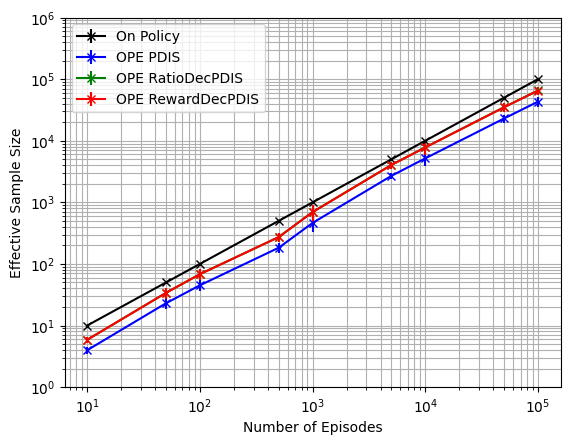

In [ ]:
EPISODES = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

vars1 = {'On Policy': [0.042099000000000004, 0.009549760000000001, 0.004320840000000001, 0.0006753600000000012, 0.0003641364000000005, 8.6610496e-05, 4.284529999999999e-05, 8.197221760000006e-06, 4.88578635999996e-06],
         'OPE IS': [0.10718115840000002, 0.02090129817599999, 0.01214973849600001, 0.002704879779839999, 0.0011811148185599982, 0.0001762293657600004, 0.00012706473277440022, 2.439082417766399e-05, 1.2483814772735995e-05],
         'OPE PDIS': [0.10718115840000002, 0.02090129817599999, 0.01214973849600001, 0.002704879779839999, 0.0011811148185599982, 0.0001762293657600004, 0.00012706473277440022, 2.439082417766399e-05, 1.2483814772735995e-05],
         'OPE RatioDecIS': [0.07303744, 0.014288825599999999, 0.008115143600000003, 0.0018844029439999972, 0.000810162623999999, 0.00011970952256000013, 8.568492415999965e-05, 1.6235369438399858e-05, 8.350526916400048e-06],
         'OPE RewardDecIS': [0.07311629663738424, 0.014295036228399364, 0.008138864825955135, 0.001882292796638632, 0.0008103820718235391, 0.00011982838599765076, 8.58731813363375e-05, 1.6288181572188038e-05, 8.373317210882913e-06],
         'OPE RatioDecPDIS': [0.07303744, 0.014288825599999999, 0.008115143600000003, 0.0018844029439999972, 0.000810162623999999, 0.00011970952256000013, 8.568492415999965e-05, 1.6235369438399858e-05, 8.350526916400048e-06],
         'OPE RewardDecPDIS': [0.07311629663738424, 0.014295036228399364, 0.008138864825955135, 0.001882292796638632, 0.0008103820718235391, 0.00011982838599765076, 8.58731813363375e-05, 1.6288181572188038e-05, 8.373317210882913e-06]}

ESS1 = calculate_ESS(vars1, EPISODES)

vars2 = {'On Policy': [0.0411, 0.00860204, 0.004305710000000001, 0.0007772336000000014, 0.0004625675000000006, 8.669614399999998e-05, 4.78334159999999e-05, 9.096738999999982e-06, 3.5543141900000165e-06],
         'OPE IS': [0.1050061824, 0.021981855743999974, 0.010343844864000008, 0.001776724992000002, 0.0011642041958399997, 0.00018630585999360001, 0.00010552594544639995, 1.9557353816064093e-05, 1.0290996043776078e-05],
         'OPE PDIS': [0.1050061824, 0.021981855743999974, 0.010343844864000008, 0.001776724992000002, 0.0011642041958399997, 0.00018630585999360001, 0.00010552594544639995, 1.9557353816064093e-05, 1.0290996043776078e-05],
         'OPE RatioDecIS': [0.07006064, 0.014548945600000003, 0.006628350400000002, 0.0011880156639999988, 0.0007908256439999986, 0.00012780784175999956, 7.123153003999995e-05, 1.3117329297600084e-05, 6.698774590000008e-06],
         'OPE RewardDecIS': [0.07026242277301076, 0.01460354655532887, 0.006675768580934078, 0.001191020993853708, 0.0007918305237353818, 0.00012779331941980876, 7.135186486292841e-05, 1.3146194232633313e-05, 6.735346999859504e-06],
         'OPE RatioDecPDIS': [0.07006064, 0.014548945600000003, 0.006628350400000002, 0.0011880156639999988, 0.0007908256439999986, 0.00012780784175999956, 7.123153003999995e-05, 1.3117329297600084e-05, 6.698774590000008e-06],
         'OPE RewardDecPDIS': [0.07026242277301076, 0.01460354655532887, 0.006675768580934078, 0.001191020993853708, 0.0007918305237353818, 0.00012779331941980876, 7.135186486292841e-05, 1.3146194232633313e-05, 6.735346999859504e-06]}

ESS2 = calculate_ESS(vars2, EPISODES)

vars3 = vars3 = {'On Policy': [0.04457599999999999, 0.00809504, 0.004448760000000003, 0.0006826124000000011, 0.0005077464000000007, 8.329869999999985e-05, 4.837957599999992e-05, 8.497547640000017e-06, 4.310088999999996e-06],
         'OPE IS': [0.09536255999999999, 0.023792025599999968, 0.010212609024000016, 0.001904737443839999, 0.0009587696025600002, 0.00016130242805759986, 9.357161103360025e-05, 1.726816827801592e-05, 1.0520995737600078e-05],
         'OPE PDIS': [0.09536255999999999, 0.023792025599999968, 0.010212609024000016, 0.001904737443839999, 0.0009587696025600002, 0.00016130242805759986, 9.357161103360025e-05, 1.726816827801592e-05, 1.0520995737600078e-05],
         'OPE RatioDecIS': [0.06399883999999999, 0.016016857600000003, 0.006745841599999999, 0.0012384165760000016, 0.0006329090999999988, 0.00010748387776000007, 6.384615115999976e-05, 1.1115995230399971e-05, 6.640140510000117e-06],
         'OPE RewardDecIS': [0.06412419850809996, 0.016053035887107204, 0.006774459042560017, 0.0012454181460719502, 0.0006353828093483753, 0.0001077798591548816, 6.388230149597093e-05, 1.1185387553144667e-05, 6.697197201830531e-06],
         'OPE RatioDecPDIS': [0.06399883999999999, 0.016016857600000003, 0.006745841599999999, 0.0012384165760000016, 0.0006329090999999988, 0.00010748387776000007, 6.384615115999976e-05, 1.1115995230399971e-05, 6.640140510000117e-06],
         'OPE RewardDecPDIS': [0.06412419850809996, 0.016053035887107204, 0.006774459042560017, 0.0012454181460719502, 0.0006353828093483753, 0.0001077798591548816, 6.388230149597093e-05, 1.1185387553144667e-05, 6.697197201830531e-06]}

ESS3 = calculate_ESS(vars3, EPISODES)

vars4 = {'On Policy': [0.0446, 0.009786360000000001, 0.00533611, 0.0008494604000000006, 0.00044798910000000067, 0.00012205585600000025, 5.6330739000000053e-05, 9.753629759999995e-06, 5.558300360000008e-06],
         'OPE IS': [0.10628904959999998, 0.016006201343999986, 0.008515067904000004, 0.002098081751040001, 0.0011561931878399997, 0.00020481444863999985, 9.754168319999966e-05, 2.0987213819903986e-05, 9.852179180543856e-06],
         'OPE PDIS': [0.10628904959999998, 0.016006201343999986, 0.008515067904000004, 0.002098081751040001, 0.0011561931878399997, 0.00020481444863999985, 9.754168319999966e-05, 2.0987213819903986e-05, 9.852179180543856e-06],
         'OPE RatioDecIS': [0.07297675999999999, 0.011065886399999995, 0.005645748400000001, 0.0014439771359999979, 0.0007778235839999997, 0.00013211906496000028, 6.410809504000003e-05, 1.3730221190399903e-05, 6.673700814399883e-06],
         'OPE RewardDecIS': [0.07296430739405482, 0.01105341123260954, 0.0056632234987700715, 0.001443665024241854, 0.0007794977115143724, 0.00013295697002885977, 6.437180964056013e-05, 1.3797529488952443e-05, 6.683488210980369e-06],
         'OPE RatioDecPDIS': [0.07297675999999999, 0.011065886399999995, 0.005645748400000001, 0.0014439771359999979, 0.0007778235839999997, 0.00013211906496000028, 6.410809504000003e-05, 1.3730221190399903e-05, 6.673700814399883e-06],
         'OPE RewardDecPDIS': [0.07296430739405482, 0.01105341123260954, 0.0056632234987700715, 0.001443665024241854, 0.0007794977115143724, 0.00013295697002885977, 6.437180964056013e-05, 1.3797529488952443e-05, 6.683488210980369e-06]}

ESS4 = calculate_ESS(vars4, EPISODES)

vars5 = {'On Policy': [0.03637099999999999, 0.012482359999999996, 0.004797960000000001, 0.0008923500000000017, 0.0006304851000000005, 0.00010420958400000018, 5.286491600000011e-05, 9.41217004000002e-06, 4.323680110000011e-06],
         'OPE IS': [0.11551242240000002, 0.02502958694399998, 0.011547012096000018, 0.002346090946559999, 0.0009072046080000006, 0.00016736977059839995, 7.499299184640013e-05, 1.737196668518406e-05, 9.681372785664003e-06],
         'OPE PDIS': [0.11551242240000002, 0.02502958694399998, 0.011547012096000018, 0.002346090946559999, 0.0009072046080000006, 0.00016736977059839995, 7.499299184640013e-05, 1.737196668518406e-05, 9.681372785664003e-06],
         'OPE RatioDecIS': [0.07864555999999999, 0.01678826240000001, 0.0076273676000000006, 0.0015430787040000005, 0.0005881713439999995, 0.00010970925615999982, 4.803295983999991e-05, 1.130312076159997e-05, 6.340652909999937e-06],
         'OPE RewardDecIS': [0.07871176277425199, 0.01683215074971491, 0.007658483846211634, 0.0015500850490649829, 0.0005915044260602984, 0.00011023278610652185, 4.83609606839994e-05, 1.1359453551045775e-05, 6.369440684519997e-06],
         'OPE RatioDecPDIS': [0.07864555999999999, 0.01678826240000001, 0.0076273676000000006, 0.0015430787040000005, 0.0005881713439999995, 0.00010970925615999982, 4.803295983999991e-05, 1.130312076159997e-05, 6.340652909999937e-06],
         'OPE RewardDecPDIS': [0.07871176277425199, 0.01683215074971491, 0.007658483846211634, 0.0015500850490649829, 0.0005915044260602984, 0.00011023278610652185, 4.83609606839994e-05, 1.1359453551045775e-05, 6.369440684519997e-06]}

ESS5 = calculate_ESS(vars5, EPISODES)

ESS = [ESS1, ESS2, ESS3, ESS4, ESS5]

plot_graphs(ESS, 'ESS', 10**(0), 10**6)

# Test on 4 State MDP

In [ ]:
#Change our working directory
if os.getcwd() == '/content':
  os.chdir('./Factored-Action-Spaces-for-OPE')

## Varying Trajectory Length With $\gamma = 0.7$

### Generate Data Set

#### From behaviour policy, generate maximum length trajectory

Dataset 1

In [ ]:
!python generate_dataset.py 4-state-MDP 10000 1000

Policy divergence: 1.44
Start state: 0,0, start state no: 0


Dataset 2

In [ ]:
!python generate_dataset.py 4-state-MDP 10000 1000

Policy divergence: 1.44
Start state: 0,0, start state no: 0


Dataset 3

In [ ]:
!python generate_dataset.py 4-state-MDP 10000 1000

Policy divergence: 1.44
Start state: 0,0, start state no: 0


Dataset 4

In [ ]:
!python generate_dataset.py 4-state-MDP 10000 1000

Policy divergence: 1.44
Start state: 0,0, start state no: 0


Dataset 5

In [ ]:
!python generate_dataset.py 4-state-MDP 10000 1000

Policy divergence: 1.44
Start state: 0,0, start state no: 0


Dataset 6

In [ ]:
!python generate_dataset.py 4-state-MDP 10000 1000

Policy divergence: 1.44
Start state: 0,0, start state no: 0


Dataset 7

In [ ]:
!python generate_dataset.py 4-state-MDP 10000 1000

Policy divergence: 1.44
Start state: 0,0, start state no: 0


Dataset 8

In [ ]:
!python generate_dataset.py 4-state-MDP 10000 1000

Policy divergence: 1.44
Start state: 0,0, start state no: 0


Dataset 9

In [ ]:
!python generate_dataset.py 4-state-MDP 10000 1000

Policy divergence: 1.44
Start state: 0,0, start state no: 0


Dataset 10

In [ ]:
!python generate_dataset.py 4-state-MDP 10000 1000

Policy divergence: 1.44
Start state: 0,0, start state no: 0


Estimate on dataset 1

In [ ]:
import sys
MDP_NAME = '4-state-MDP'
sys.argv[1] = MDP_NAME
import numpy as np
import policy_estimators as pe
from load_discrete_MDP import pi_b, pi_e
from load_discrete_MDP import factored_behaviour_policies, factored_evaluation_policies, factored_state_action_maps, factored_state_abstractions, factored_Rs
from load_discrete_MDP import action_spaces, action_space_mapping
from load_datasets import load_MDP_transitions
import gc

START_STATE_NO = 0
NO_TRAJECTORIES = 10000
TRAJECTORY_LENGTH = 1000
SHORTER_D = 1.44

def evaluate_PE(RUNS, NUM_EPISODES, EPISODE_LENGTH, VERSION_NUMBER):

  estimates = np.zeros(shape=(7,RUNS))

  nf_transitions_b, nf_transitions_e, f_transitions_b, f_transitions_e = load_MDP_transitions(MDP_NAME,
                                                                                          START_STATE_NO,
                                                                                          NO_TRAJECTORIES,
                                                                                          TRAJECTORY_LENGTH,
                                                                                          SHORTER_D,
                                                                                          VERSION_NUMBER)

  # Reshape data for processing
  T, ldim = nf_transitions_b.shape[-2], nf_transitions_b.shape[-1]
  nfb = nf_transitions_b.reshape((-1, NUM_EPISODES, T, ldim))
  nfe = nf_transitions_e.reshape((-1, NUM_EPISODES, T, ldim))
  T, D, ldim = f_transitions_b.shape[-3], f_transitions_b.shape[-2], f_transitions_b.shape[-1]
  fb = f_transitions_b.reshape((-1, NUM_EPISODES, T, D, ldim))
  fe = f_transitions_e.reshape((-1, NUM_EPISODES, T, D, ldim))

  for run in range(RUNS):

      #On policy Q estimate
      estimates[0, run] = pe.on_policy_Q_estimate(nfe[run, :, :EPISODE_LENGTH, :], 0.7)
      #Off policy IS estimate
      estimates[1, run] = pe.off_policy_IS_estimator(nfb[run, :, :EPISODE_LENGTH, :], 0.7, pi_b, pi_e)
      #Off policy PDIS estimate
      estimates[2, run] = pe.off_policy_PDIS_estimator(nfb[run, :, :EPISODE_LENGTH, :], 0.7, pi_b, pi_e)
      #Off policy decomposed IS estimate
      estimates[3, run] = off_policy_RatioDecIS_estimator(nfb[run, :, :EPISODE_LENGTH, :], fb[run, :, :EPISODE_LENGTH, :, :], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDIS estimate
      estimates[4, run] = off_policy_RewardDecIS_estimator(nfb[run, :, :EPISODE_LENGTH, :], fb[run, :, :EPISODE_LENGTH, :, :], 0.7, action_spaces, pi_b, pi_e)
      #Off policy decomposed IS estimate
      estimates[5, run] = off_policy_RatioDecPDIS_estimator(nfb[run, :, :EPISODE_LENGTH, :], fb[run, :, :EPISODE_LENGTH, :, :], 0.7, action_spaces, factored_behaviour_policies, factored_evaluation_policies)
      #Off policy decomposed PDIS estimate
      estimates[6, run] = off_policy_RewardDecPDIS_estimator(nfb[run, :, :EPISODE_LENGTH, :], fb[run, :, :EPISODE_LENGTH, :, :], 0.7, action_spaces, pi_b, pi_e)

  return estimates


In [ ]:
from sklearn.metrics import mean_squared_error

def generate_graph_data(estimates):
  means = np.mean(estimates, axis=-1)
  variances = np.var(estimates, ddof=0, axis=-1)
  MSEs = mean_squared_error(estimates.T, np.full((estimates.T).shape, means[0]), multioutput='raw_values')
  biases_1 = np.sqrt(MSEs - variances)
  biases_2 = np.abs(means - np.full(means.shape, means[0]))

  print(f'Mean on policy Q estimate: {means[0]}. Variance of on policy Q estimate: {variances[0]}')
  print(f'Mean off policy IS estimate: {means[1]}. Bias1: {biases_1[1]}. Bias2: {biases_2[1]}. Variance: {variances[1]}. MSE: {MSEs[1]}')
  print(f'Mean off policy PDIS estimate: {means[2]}. Bias1: {biases_1[2]}. Bias2: {biases_2[2]} Variance: {variances[2]}. MSE: {MSEs[2]}')
  print(f'Mean off policy RatioDecIS estimate: {means[3]}. Bias1: {biases_1[3]}. Bias2: {biases_2[3]}. Variance: {variances[3]}. MSE: {MSEs[3]}')
  print(f'Mean off policy RewardDecIS estimate: {means[4]}. Bias1: {biases_1[4]}. Bias2: {biases_2[4]}. Variance: {variances[4]}. MSE: {MSEs[4]}')
  print(f'Mean off policy RatioDecPDIS estimate: {means[5]}. Bias1: {biases_1[5]}. Bias2: {biases_2[5]}. Variance: {variances[5]}. MSE: {MSEs[5]}')
  print(f'Mean off policy RewardDecPDIS estimate: {means[6]}. Bias1: {biases_1[6]}. Bias2: {biases_2[6]}. Variance: {variances[6]}. MSE: {MSEs[6]}')

  return means, variances, MSEs, biases_1, biases_2

### Run Estimates on Collected Data Sets

#### 100 runs, 1000 episodes, trajectory length 1

In [ ]:
e_1 = evaluate_PE(10, 1000, 1, 1)
gc.collect()
e_2 = evaluate_PE(10, 1000, 1, 2)
gc.collect()
e_3 = evaluate_PE(10, 1000, 1, 3)
gc.collect()
e_4 = evaluate_PE(10, 1000, 1, 4)
gc.collect()
e_5 = evaluate_PE(10, 1000, 1, 5)
gc.collect()
e_6 = evaluate_PE(10, 1000, 1, 6)
gc.collect()
e_7 = evaluate_PE(10, 1000, 1, 7)
gc.collect()
e_8 = evaluate_PE(10, 1000, 1, 8)
gc.collect()
e_9 = evaluate_PE(10, 1000, 1, 9)
gc.collect()
e_10 = evaluate_PE(10, 1000, 1, 10)
gc.collect()
estimates = np.concatenate((e_1, e_2, e_3, e_4, e_5, e_6, e_7, e_8, e_9, e_10), axis=-1)
print(estimates.shape)

(7, 100)


In [ ]:
means, variances, MSEs, biases_1, biases_2 = generate_graph_data(estimates)

Mean on policy Q estimate: 1.19944. Variance of on policy Q estimate: 0.0005792264000000004
Mean off policy IS estimate: 1.204224. Bias1: 0.0047840000000000165. Bias2: 0.0047839999999998994. Variance: 0.0012518645759999982. MSE: 0.0012747512319999984
Mean off policy PDIS estimate: 1.204224. Bias1: 0.0047840000000000165. Bias2: 0.0047839999999998994 Variance: 0.0012518645759999982. MSE: 0.0012747512319999984
Mean off policy RatioDecIS estimate: 1.1029240000000002. Bias1: 0.09651600000000007. Bias2: 0.09651599999999982. Variance: 0.0008317406240000004. MSE: 0.010147078880000014
Mean off policy RewardDecIS estimate: 1.0928821567832379. Bias1: 0.10655784321676197. Bias2: 0.1065578432167622. Variance: 0.0008345920898653723. MSE: 0.012189166040873398
Mean off policy RatioDecPDIS estimate: 1.1029240000000002. Bias1: 0.09651600000000007. Bias2: 0.09651599999999982. Variance: 0.0008317406240000004. MSE: 0.010147078880000014
Mean off policy RewardDecPDIS estimate: 1.0928821567832379. Bias1: 0.10

#### 100 runs, 1000 episodes, trajectory length 5

In [ ]:
e_1 = evaluate_PE(10, 1000, 5, 1)
gc.collect()
e_2 = evaluate_PE(10, 1000, 5, 2)
gc.collect()
e_3 = evaluate_PE(10, 1000, 5, 3)
gc.collect()
e_4 = evaluate_PE(10, 1000, 5, 4)
gc.collect()
e_5 = evaluate_PE(10, 1000, 5, 5)
gc.collect()
e_6 = evaluate_PE(10, 1000, 5, 6)
gc.collect()
e_7 = evaluate_PE(10, 1000, 5, 7)
gc.collect()
e_8 = evaluate_PE(10, 1000, 5, 8)
gc.collect()
e_9 = evaluate_PE(10, 1000, 5, 9)
gc.collect()
e_10 = evaluate_PE(10, 1000, 5, 10)
gc.collect()
estimates = np.concatenate((e_1, e_2, e_3, e_4, e_5, e_6, e_7, e_8, e_9, e_10), axis=-1)
print(estimates.shape)

(7, 100)


In [ ]:
means_new, variances_new, MSEs_new, biases_1_new, biases_2_new = generate_graph_data(estimates)
means = np.stack((means, means_new), axis=-1)
variances = np.stack((variances, variances_new), axis=-1)
MSEs = np.stack((MSEs, MSEs_new), axis=-1)
biases_1 = np.stack((biases_1, biases_1_new), axis=-1)
print(means)

Mean on policy Q estimate: 0.7772826630000003. Variance of on policy Q estimate: 0.0008693947489917307
Mean off policy IS estimate: 0.7751833351480149. Bias1: 0.0020993278519855197. Bias2: 0.002099327851985411. Variance: 0.0012082123137473462. MSE: 0.0012126194911774683
Mean off policy PDIS estimate: 0.7732616926674813. Bias1: 0.004020970332518838. Bias2: 0.004020970332518914 Variance: 0.0019187105578390429. MSE: 0.0019348787602540395
Mean off policy RatioDecIS estimate: 0.8885152651263999. Bias1: 0.1112326021263998. Bias2: 0.11123260212639963. Variance: 0.0008446077987039654. MSE: 0.013217299574513926
Mean off policy RewardDecIS estimate: 0.8604577601451667. Bias1: 0.08317509714516658. Bias2: 0.08317509714516647. Variance: 0.0008023040078480046. MSE: 0.007720400792955901
Mean off policy RatioDecPDIS estimate: 0.8883963792127999. Bias1: 0.1111137162127997. Bias2: 0.11111371621279964. Variance: 0.001156986756342802. MSE: 0.013503244686961388
Mean off policy RewardDecPDIS estimate: 0.899

<ipython-input-51-b0547fc6dd57>:7: RuntimeWarning: invalid value encountered in sqrt
  biases_1 = np.sqrt(MSEs - variances)


#### 100 runs, 1000 episodes, trajectory length 10

In [ ]:
e_1 = evaluate_PE(10, 1000, 10, 1)
gc.collect()
e_2 = evaluate_PE(10, 1000, 10, 2)
gc.collect()
e_3 = evaluate_PE(10, 1000, 10, 3)
gc.collect()
e_4 = evaluate_PE(10, 1000, 10, 4)
gc.collect()
e_5 = evaluate_PE(10, 1000, 10, 5)
gc.collect()
e_6 = evaluate_PE(10, 1000, 10, 6)
gc.collect()
e_7 = evaluate_PE(10, 1000, 10, 7)
gc.collect()
e_8 = evaluate_PE(10, 1000, 10, 8)
gc.collect()
e_9 = evaluate_PE(10, 1000, 10, 9)
gc.collect()
e_10 = evaluate_PE(10, 1000, 10, 10)
gc.collect()
estimates = np.concatenate((e_1, e_2, e_3, e_4, e_5, e_6, e_7, e_8, e_9, e_10), axis=-1)
print(estimates.shape)

(7, 100)


In [ ]:
means_new, variances_new, MSEs_new, biases_1_new, biases_2_new = generate_graph_data(estimates)
means = np.concatenate((means, means_new[..., np.newaxis]), axis=-1)
variances = np.concatenate((variances, variances_new[..., np.newaxis]), axis=-1)
MSEs = np.concatenate((MSEs, MSEs_new[..., np.newaxis]), axis=-1)
biases_1 = np.concatenate((biases_1, biases_1_new[..., np.newaxis]), axis=-1)

Mean on policy Q estimate: 0.6665773844602703. Variance of on policy Q estimate: 0.0008955613323152548
Mean off policy IS estimate: 0.668758276832344. Bias1: 0.0021808923720739834. Bias2: 0.0021808923720737505. Variance: 0.002234741415705895. MSE: 0.0022394977072444657
Mean off policy PDIS estimate: 0.6610526022732812. Bias1: 0.005524782186989068. Bias2: 0.005524782186989041 Variance: 0.002074966681609499. MSE: 0.0021054898998231707
Mean off policy RatioDecIS estimate: 0.8344097875903607. Bias1: 0.16783240313009046. Bias2: 0.1678324031300904. Variance: 0.0009525948594044384. MSE: 0.029120310399825634
Mean off policy RewardDecIS estimate: 0.7728953582520401. Bias1: 0.10631797379176995. Bias2: 0.10631797379176988. Variance: 0.0008280517525096933. MSE: 0.012131563303697175
Mean off policy RatioDecPDIS estimate: 0.8322400395138689. Bias1: 0.16566265505359873. Bias2: 0.16566265505359867. Variance: 0.0011324653411621552. MSE: 0.028576580620569794
Mean off policy RewardDecPDIS estimate: 0.851

#### 100 runs, 1000 episodes, trajectory length 50

In [ ]:
e_1 = evaluate_PE(10, 1000, 50, 1)
gc.collect()
e_2 = evaluate_PE(10, 1000, 50, 2)
gc.collect()
e_3 = evaluate_PE(10, 1000, 50, 3)
gc.collect()
e_4 = evaluate_PE(10, 1000, 50, 4)
gc.collect()
e_5 = evaluate_PE(10, 1000, 50, 5)
gc.collect()
e_6 = evaluate_PE(10, 1000, 50, 6)
gc.collect()
e_7 = evaluate_PE(10, 1000, 50, 7)
gc.collect()
e_8 = evaluate_PE(10, 1000, 50, 8)
gc.collect()
e_9 = evaluate_PE(10, 1000, 50, 9)
gc.collect()
e_10 = evaluate_PE(10, 1000, 50, 10)
gc.collect()
estimates = np.concatenate((e_1, e_2, e_3, e_4, e_5, e_6, e_7, e_8, e_9, e_10), axis=-1)
print(estimates.shape)

(7, 100)


In [ ]:
means_new, variances_new, MSEs_new, biases_1_new, biases_2_new = generate_graph_data(estimates)
means = np.concatenate((means, means_new[..., np.newaxis]), axis=-1)
variances = np.concatenate((variances, variances_new[..., np.newaxis]), axis=-1)
MSEs = np.concatenate((MSEs, MSEs_new[..., np.newaxis]), axis=-1)
biases_1 = np.concatenate((biases_1, biases_1_new[..., np.newaxis]), axis=-1)

Mean on policy Q estimate: 0.6440039940497345. Variance of on policy Q estimate: 0.0009120289987790549
Mean off policy IS estimate: 0.6342386046547492. Bias1: 0.009765389394985108. Bias2: 0.00976538939498528. Variance: 0.03323050928973665. MSE: 0.03332587211977234
Mean off policy PDIS estimate: 0.6383355952903851. Bias1: 0.005668398759349558. Bias2: 0.005668398759349436 Variance: 0.00212213010128254. MSE: 0.0021542608457775355
Mean off policy RatioDecIS estimate: 0.8226754712134263. Bias1: 0.1786714771636917. Bias2: 0.1786714771636918. Variance: 0.004309961474790365. MSE: 0.03623345822664597
Mean off policy RewardDecIS estimate: 0.5079878745575117. Bias1: 0.13601611949222286. Bias2: 0.1360161194922228. Variance: 0.0009551229635007138. MSE: 0.019455507725223357
Mean off policy RatioDecPDIS estimate: 0.8209495253449005. Bias1: 0.17694553129516594. Bias2: 0.176945531295166. Variance: 0.001133542938385133. MSE: 0.03244326398371369
Mean off policy RewardDecPDIS estimate: 0.8420822440754826.

#### 100 runs, 1000 episodes, trajectory length 100

In [ ]:
e_1 = evaluate_PE(10, 1000, 100, 1)
gc.collect()
e_2 = evaluate_PE(10, 1000, 100, 2)
gc.collect()
e_3 = evaluate_PE(10, 1000, 100, 3)
gc.collect()
e_4 = evaluate_PE(10, 1000, 100, 4)
gc.collect()
e_5 = evaluate_PE(10, 1000, 100, 5)
gc.collect()
e_6 = evaluate_PE(10, 1000, 100, 6)
gc.collect()
e_7 = evaluate_PE(10, 1000, 100, 7)
gc.collect()
e_8 = evaluate_PE(10, 1000, 100, 8)
gc.collect()
e_9 = evaluate_PE(10, 1000, 100, 9)
gc.collect()
e_10 = evaluate_PE(10, 1000, 100, 10)
gc.collect()
estimates = np.concatenate((e_1, e_2, e_3, e_4, e_5, e_6, e_7, e_8, e_9, e_10), axis=-1)
print(estimates.shape)

(7, 100)


In [ ]:
means_new, variances_new, MSEs_new, biases_1_new, biases_2_new = generate_graph_data(estimates)
means = np.concatenate((means, means_new[..., np.newaxis]), axis=-1)
variances = np.concatenate((variances, variances_new[..., np.newaxis]), axis=-1)
MSEs = np.concatenate((MSEs, MSEs_new[..., np.newaxis]), axis=-1)
biases_1 = np.concatenate((biases_1, biases_1_new[..., np.newaxis]), axis=-1)

Mean on policy Q estimate: 0.6440039795900582. Variance of on policy Q estimate: 0.0009120289956136174
Mean off policy IS estimate: 0.5697330889236699. Bias1: 0.07427089066638821. Bias2: 0.07427089066638826. Variance: 0.12304878568554772. MSE: 0.12856495088592632
Mean off policy PDIS estimate: 0.6383355805155024. Bias1: 0.005668399074555635. Bias2: 0.005668399074555741 Variance: 0.002122130088830832. MSE: 0.002154260836899255
Mean off policy RatioDecIS estimate: 0.8056693972752689. Bias1: 0.1616654176852107. Bias2: 0.1616654176852107. Variance: 0.02212256507823965. MSE: 0.04825827235357329
Mean off policy RewardDecIS estimate: 0.3054269197173237. Bias1: 0.33857705987273445. Bias2: 0.33857705987273445. Variance: 0.0009627291862594799. MSE: 0.11559715465832468
Mean off policy RatioDecPDIS estimate: 0.820949517877064. Bias1: 0.1769455382870059. Bias2: 0.17694553828700588. Variance: 0.0011335429420939816. MSE: 0.03244326646177226
Mean off policy RewardDecPDIS estimate: 0.8420822401177921. 

#### 100 runs, 1000 episodes, trajectory length 500

In [ ]:
e_1 = evaluate_PE(10, 1000, 500, 1)
gc.collect()
e_2 = evaluate_PE(10, 1000, 500, 2)
gc.collect()
e_3 = evaluate_PE(10, 1000, 500, 3)
gc.collect()
e_4 = evaluate_PE(10, 1000, 500, 4)
gc.collect()
e_5 = evaluate_PE(10, 1000, 500, 5)
gc.collect()
e_6 = evaluate_PE(10, 1000, 500, 6)
gc.collect()
e_7 = evaluate_PE(10, 1000, 500, 7)
gc.collect()
e_8 = evaluate_PE(10, 1000, 500, 8)
gc.collect()
e_9 = evaluate_PE(10, 1000, 500, 9)
gc.collect()
e_10 = evaluate_PE(10, 1000, 500, 10)
gc.collect()
estimates = np.concatenate((e_1, e_2, e_3, e_4, e_5, e_6, e_7, e_8, e_9, e_10), axis=-1)
print(estimates.shape)

(7, 100)


In [ ]:
means_new, variances_new, MSEs_new, biases_1_new, biases_2_new = generate_graph_data(estimates)
means = np.concatenate((means, means_new[..., np.newaxis]), axis=-1)
variances = np.concatenate((variances, variances_new[..., np.newaxis]), axis=-1)
MSEs = np.concatenate((MSEs, MSEs_new[..., np.newaxis]), axis=-1)
biases_1 = np.concatenate((biases_1, biases_1_new[..., np.newaxis]), axis=-1)

Mean on policy Q estimate: 0.6440039795900581. Variance of on policy Q estimate: 0.0009120289956136172
Mean off policy IS estimate: 0.20618295859821728. Bias1: 0.43782102099183945. Bias2: 0.4378210209918408. Variance: 3.529958699854929. MSE: 3.7216459462772655
Mean off policy PDIS estimate: 0.6383355805155023. Bias1: 0.005668399074555712. Bias2: 0.005668399074555741 Variance: 0.002122130088830831. MSE: 0.002154260836899255
Mean off policy RatioDecIS estimate: 3.1031886581454593. Bias1: 2.4591846785553413. Bias2: 2.4591846785554012. Variance: 786.6187950499523. MSE: 792.6663843331936
Mean off policy RewardDecIS estimate: 0.005874368264518005. Bias1: 0.63812961132554. Bias2: 0.63812961132554. Variance: 0.00010772226894475246. MSE: 0.4073171231194296
Mean off policy RatioDecPDIS estimate: 0.8209495178770639. Bias1: 0.1769455382870059. Bias2: 0.17694553828700588. Variance: 0.0011335429420939805. MSE: 0.03244326646177226
Mean off policy RewardDecPDIS estimate: 0.8420822401177921. Bias1: 0.1

<ipython-input-51-b0547fc6dd57>:7: RuntimeWarning: invalid value encountered in sqrt
  biases_1 = np.sqrt(MSEs - variances)


#### 100 runs, 1000 episodes, trajectory length 1000

In [ ]:
e_1 = evaluate_PE(10, 1000, 1000, 1)
gc.collect()
e_2 = evaluate_PE(10, 1000, 1000, 2)
gc.collect()
e_3 = evaluate_PE(10, 1000, 1000, 3)
gc.collect()
e_4 = evaluate_PE(10, 1000, 1000, 4)
gc.collect()
e_5 = evaluate_PE(10, 1000, 1000, 5)
gc.collect()
e_6 = evaluate_PE(10, 1000, 1000, 6)
gc.collect()
e_7 = evaluate_PE(10, 1000, 1000, 7)
gc.collect()
e_8 = evaluate_PE(10, 1000, 1000, 8)
gc.collect()
e_9 = evaluate_PE(10, 1000, 1000, 9)
gc.collect()
e_10 = evaluate_PE(10, 1000, 1000, 10)
gc.collect()
estimates = np.concatenate((e_1, e_2, e_3, e_4, e_5, e_6, e_7, e_8, e_9, e_10), axis=-1)
print(estimates.shape)

(7, 100)


In [ ]:
means_new, variances_new, MSEs_new, biases_1_new, biases_2_new = generate_graph_data(estimates)
means = np.concatenate((means, means_new[..., np.newaxis]), axis=-1)
variances = np.concatenate((variances, variances_new[..., np.newaxis]), axis=-1)
MSEs = np.concatenate((MSEs, MSEs_new[..., np.newaxis]), axis=-1)
biases_1 = np.concatenate((biases_1, biases_1_new[..., np.newaxis]), axis=-1)

Mean on policy Q estimate: 0.6440039795900581. Variance of on policy Q estimate: 0.0009120289956136172
Mean off policy IS estimate: 3.1958103129842363e-06. Bias1: 0.6440007837797451. Bias2: 0.6440007837797451. Variance: 7.281152351279609e-10. MSE: 0.41473701023704124
Mean off policy PDIS estimate: 0.6383355805155023. Bias1: 0.005668399074555712. Bias2: 0.005668399074555741 Variance: 0.002122130088830831. MSE: 0.002154260836899255
Mean off policy RatioDecIS estimate: 0.08903530060568138. Bias1: 0.5549686789843765. Bias2: 0.5549686789843766. Variance: 0.306908062031383. MSE: 0.6148982966850469
Mean off policy RewardDecIS estimate: 1.9505921713838873e-05. Bias1: 0.6439844736683442. Bias2: 0.6439844736683442. Variance: 5.2291541622079264e-09. MSE: 0.41471600755504845
Mean off policy RatioDecPDIS estimate: 0.8209495178770639. Bias1: 0.1769455382870059. Bias2: 0.17694553828700588. Variance: 0.0011335429420939805. MSE: 0.03244326646177226
Mean off policy RewardDecPDIS estimate: 0.842082240117

<ipython-input-51-b0547fc6dd57>:7: RuntimeWarning: invalid value encountered in sqrt
  biases_1 = np.sqrt(MSEs - variances)


#### Write out the readings dict (to copy and paste)

In [ ]:
biases_dict = {
      'On Policy': list(biases_1[0, :]),
      'OPE IS': list(biases_1[1, :]),
      'OPE PDIS': list(biases_1[2, :]),
      'OPE RatioDecIS': list(biases_1[3, :]),
      'OPE RewardDecIS': list(biases_1[4, :]),
      'OPE RatioDecPDIS': list(biases_1[5, :]),
      'OPE RewardDecPDIS': list(biases_1[6, :]),
  }

vars_dict = {
      'On Policy': list(variances[0, :]),
      'OPE IS': list(variances[1, :]),
      'OPE PDIS': list(variances[2, :]),
      'OPE RatioDecIS': list(variances[3, :]),
      'OPE RewardDecIS': list(variances[4, :]),
      'OPE RatioDecPDIS': list(variances[5, :]),
      'OPE RewardDecPDIS': list(variances[6, :]),
  }

MSEs_dict = {
      'On Policy': list(MSEs[0, :]),
      'OPE IS': list(MSEs[1, :]),
      'OPE PDIS': list(MSEs[2, :]),
      'OPE RatioDecIS': list(MSEs[3, :]),
      'OPE RewardDecIS': list(MSEs[4, :]),
      'OPE RatioDecPDIS': list(MSEs[5, :]),
      'OPE RewardDecPDIS': list(MSEs[6, :]),
  }

print(biases_dict)
print()
print(vars_dict)
print()
print(MSEs_dict)

{'On Policy': [0.0, nan, 0.0, 6.585445079827193e-10, 4.656612873077393e-10, nan, nan], 'OPE IS': [0.0047840000000000165, 0.0020993278519855197, 0.0021808923720739834, 0.009765389394985108, 0.07427089066638821, 0.43782102099183945, 0.6440007837797451], 'OPE PDIS': [0.0047840000000000165, 0.004020970332518838, 0.005524782186989068, 0.005668398759349558, 0.005668399074555635, 0.005668399074555712, 0.005668399074555712], 'OPE RatioDecIS': [0.09651600000000007, 0.1112326021263998, 0.16783240313009046, 0.1786714771636917, 0.1616654176852107, 2.4591846785553413, 0.5549686789843765], 'OPE RewardDecIS': [0.10655784321676197, 0.08317509714516658, 0.10631797379176995, 0.13601611949222286, 0.33857705987273445, 0.63812961132554, 0.6439844736683442], 'OPE RatioDecPDIS': [0.09651600000000007, 0.1111137162127997, 0.16566265505359873, 0.17694553129516594, 0.1769455382870059, 0.1769455382870059, 0.1769455382870059], 'OPE RewardDecPDIS': [0.10655784321676197, 0.12238887515623456, 0.1846896406201528, 0.19

### Plot Graphs
<a id='vs_tr_len_g_0_7'></a>
<a name="vs_tr_len_g_0_7"></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_ESS(variances, episodes):
  ESS = {}
  on_policy_vars = variances['On Policy']
  for key in variances.keys():
    ESS[key] = []
    for ind in range(len(on_policy_vars)):
      ESS[key].append(episodes * on_policy_vars[ind]/variances[key][ind])
  return ESS

def generate_mean_std(readings, legend):
  arrays = None
  for r_dict in readings:
    add_val = np.expand_dims(np.array(r_dict[legend]), axis=0)
    if arrays is None:
      arrays = add_val
    else:
      arrays = np.concatenate((arrays, add_val), axis=0)

  return np.mean(arrays, axis=0), np.std(arrays, axis=0)

def plot_graphs(readings, label, low_ylim, up_ylim):
  LENGTHS = [1, 5, 10, 50, 100, 500, 1000]

  colours = {
      'On Policy': 'k',
      'OPE IS': 'lightseagreen',
      'OPE PDIS': 'b',
      'OPE RatioDecIS': 'lightcoral',
      'OPE RewardDecIS': 'lime',
      'OPE RatioDecPDIS': 'r',
      'OPE RewardDecPDIS': 'g'
  }

  ylabels = {
      'bias': '|Bias| With Respect to On Policy Estimate',
      'var': 'Variance',
      'MSE': 'Mean Squared Error ($Variance \ + \ Bias^2$)',
      'ESS': 'Effective Sample Size'
  }

  legend_list = ['OPE IS', 'OPE PDIS', 'OPE RatioDecIS', 'OPE RewardDecIS', 'OPE RatioDecPDIS', 'OPE RewardDecPDIS']

  plt.figure(figsize=(5.5,4))
  if label != 'bias':
    legend_list.insert(0,'On Policy')
  for legend in legend_list:
    mean_reading, std_reading = generate_mean_std(readings, legend)
    plt.errorbar(LENGTHS, mean_reading, yerr=std_reading, color=colours[legend], marker='x')
  plt.yscale("log")
  plt.xscale("log")
  plt.grid(visible=True, which='both', axis='both')
  plt.legend(legend_list)
  plt.xlabel('Time Steps in Episode')
  plt.ylabel(ylabels[label])
  plt.ylim([low_ylim, up_ylim])
  plt.savefig(f'{label}-vs-episode-length-discount-0-7-policy-divergence-1-44.pdf', dpi=300)
  plt.show()

#### Bias

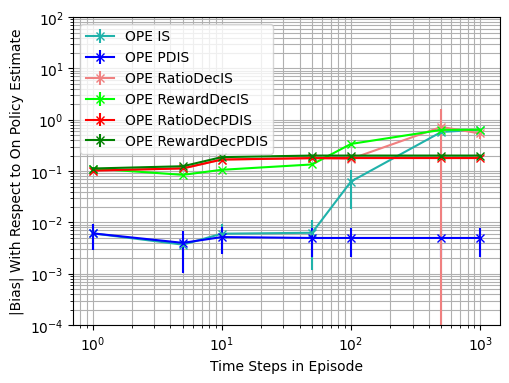

In [ ]:
biases_1 = {'On Policy': [3.2927225399135965e-10, 3.2927225399135965e-10, 0.0, 0.0, 0.0, 0.0, 0.0],
            'OPE IS': [0.009875599999999917, 0.004298578354260196, 0.00895073632937886, 0.00015773144412013583, 0.024309863817564448, 0.6052628055217987, 0.6406193246751436],
            'OPE PDIS': [0.009875599999999917, 0.0032030555584124437, 0.004277256819180685, 0.0038677661387497065, 0.0038677655142587623, 0.003867765514258594, 0.003867765514258594],
            'OPE RatioDecIS': [0.10863999999999992, 0.10970319603360007, 0.16357990493445615, 0.17334786737328708, 0.17005969066440907, 0.4298797146771978, 0.6220047218178617],
            'OPE RewardDecIS': [0.11876003309493356, 0.0815643367371935, 0.10207255459909695, 0.13856972489344896, 0.34075468561922273, 0.6363906742851279, 0.6406066771606895],
            'OPE RatioDecPDIS': [0.10863999999999992, 0.11017222692000002, 0.16523444601135404, 0.17688827164921334, 0.17688827897208162, 0.1768882789720817, 0.1768882789720817],
            'OPE RewardDecPDIS': [0.11876003309493356, 0.12164220419765374, 0.18452501924124443, 0.1982574399834544, 0.19825745052905258, 0.19825745052905278, 0.19825745052905278]}

biases_2 = {'On Policy': [3.2927225399135965e-10, 3.2927225399135965e-10, 0.0, 0.0, 0.0, 0.0, 0.0],
            'OPE IS': [0.009875599999999917, 0.004298578354260196, 0.00895073632937886, 0.00015773144412013583, 0.024309863817564448, 0.6052628055217987, 0.6406193246751436],
            'OPE PDIS': [0.009875599999999917, 0.0032030555584124437, 0.004277256819180685, 0.0038677661387497065, 0.0038677655142587623, 0.003867765514258594, 0.003867765514258594],
            'OPE RatioDecIS': [0.10863999999999992, 0.10970319603360007, 0.16357990493445615, 0.17334786737328708, 0.17005969066440907, 0.4298797146771978, 0.6220047218178617],
            'OPE RewardDecIS': [0.11876003309493356, 0.0815643367371935, 0.10207255459909695, 0.13856972489344896, 0.34075468561922273, 0.6363906742851279, 0.6406066771606895],
            'OPE RatioDecPDIS': [0.10863999999999992, 0.11017222692000002, 0.16523444601135404, 0.17688827164921334, 0.17688827897208162, 0.1768882789720817, 0.1768882789720817],
            'OPE RewardDecPDIS': [0.11876003309493356, 0.12164220419765374, 0.18452501924124443, 0.1982574399834544, 0.19825745052905258, 0.19825745052905278, 0.19825745052905278]}

biases_3 = {'On Policy': [4.656612873077393e-10, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            'OPE IS': [0.0038760000000001376, 0.0018037654068024836, 0.0014721192142251984, 0.01220782833273254, 0.04688125386494471, 0.6251905242716589, 0.6383096920400231],
            'OPE PDIS': [0.0038760000000001376, 0.0002418502823863411, 0.0016929717877032216, 0.001433197122884663, 0.0014331971261168507, 0.0014331971261165482, 0.0014331971261165482],
            'OPE RatioDecIS': [0.09621199999999995, 0.11405274038816, 0.16710198199107787, 0.18662941765305735, 0.19951086895077072, 0.05253110861860358, 0.6138056659993993],
            'OPE RewardDecIS': [0.10633506371036651, 0.08594728083557537, 0.1062003075461506, 0.12897137199099623, 0.3348391833133789, 0.6341493846094811, 0.6382978479637132],
            'OPE RatioDecPDIS': [0.09621199999999995, 0.11295189087775993, 0.16695838402030744, 0.17835244711513648, 0.17835245446790435, 0.1783524544679044, 0.1783524544679044],
            'OPE RewardDecPDIS': [0.10633506371036651, 0.12462053757357755, 0.18648657061408905, 0.19997899241897643, 0.19997900301125787, 0.19997900301125804, 0.19997900301125804]}

biases_4 = {'On Policy': [3.2927225399135965e-10, 0.0, 5.703162734357589e-10, 0.0, 0.0, 0.0, 0.0],
            'OPE IS': [0.002253999999999921, 0.005989828194626328, 0.00866496053568524, 0.009179776259047286, 0.1439045264250714, 0.6244832584046108, 0.6375366583699503],
            'OPE PDIS': [0.002253999999999921, 0.009342203604462423, 0.010207993996413364, 0.010095067547307358, 0.01009506852683417, 0.010095068526833955, 0.010095068526833955],
            'OPE RatioDecIS': [0.10158999999999994, 0.11944394936095995, 0.1767061302694074, 0.17782050318223608, 0.16341115984598525, 0.25858535010280675, 0.2940678478248385],
            'OPE RewardDecIS': [0.11174862293144722, 0.09094606886411544, 0.11401546175807441, 0.13242516797861556, 0.33834399464996917, 0.6339503266590768, 0.6382082546922445],
            'OPE RatioDecPDIS': [0.10158999999999994, 0.12105804692255986, 0.17786200213198866, 0.18914055824116627, 0.18914056575096608, 0.18914056575096624, 0.18914056575096624],
            'OPE RewardDecPDIS': [0.11174862293144722, 0.13221211798471658, 0.19680437734039904, 0.2102498691653153, 0.21024987986642174, 0.21024987986642205, 0.21024987986642205]}


biases_5 = {'On Policy': [0.0, 0.0, 0.0, 6.585445079827193e-10, 4.656612873077393e-10, 0.0, 0.0],
            'OPE IS': [0.0047840000000000165, 0.0020993278519855197, 0.0021808923720739834, 0.009765389394985108, 0.07427089066638821, 0.43782102099183945, 0.6440007837797451],
            'OPE PDIS': [0.0047840000000000165, 0.004020970332518838, 0.005524782186989068, 0.005668398759349558, 0.005668399074555635, 0.005668399074555712, 0.005668399074555712],
            'OPE RatioDecIS': [0.09651600000000007, 0.1112326021263998, 0.16783240313009046, 0.1786714771636917, 0.1616654176852107, 2.4591846785553413, 0.5549686789843765],
            'OPE RewardDecIS': [0.10655784321676197, 0.08317509714516658, 0.10631797379176995, 0.13601611949222286, 0.33857705987273445, 0.63812961132554, 0.6439844736683442],
            'OPE RatioDecPDIS': [0.09651600000000007, 0.1111137162127997, 0.16566265505359873, 0.17694553129516594, 0.1769455382870059, 0.1769455382870059, 0.1769455382870059],
            'OPE RewardDecPDIS': [0.10655784321676197, 0.12238887515623456, 0.1846896406201528, 0.19807825002574797, 0.198078260527734, 0.19807826052773406, 0.19807826052773406]}

biases = [biases_1, biases_2, biases_3, biases_4, biases_5]


plot_graphs(biases, 'bias', 10**(-4), 10**(2))

In [ ]:
def print_specific_mean_std(r_dict_list):
  r_1000 = np.zeros((5, 7))
  r_100000 = np.zeros((5, 7))

  for r in range(len(r_dict_list)):
    r_dict = r_dict_list[r]
    legends = list(r_dict.keys())
    for l in range(len(legends)):
      legend = legends[l]
      r_1000[r, l] = r_dict[legend][2]
      r_100000[r, l] = r_dict[legend][-1]

  print('10 STEPS')
  print(list(np.mean(r_1000, axis = 0)))
  print(list(np.std(r_1000, axis = 0)))
  print('\n1000 STEPS')
  print(list(np.mean(r_100000, axis = 0)))
  print(list(np.std(r_100000, axis = 0)))

print_specific_mean_std(biases)

10 STEPS
[6.585445079827192e-11, 0.0003489435321103368, 0.0004064998547361284, 0.03414886959949572, 0.03408293033251335, 0.0, 0.0]
[1.3170890159654387e-10, 0.0006978870642206736, 0.0008129997094722568, 0.06829773919899146, 0.0681658606650267, 0.0, 0.0]

1000 STEPS
[0.0, 0.12797153652234175, 0.0004468663209586441, 0.1209840854970308, 0.03637842564721932, 0.0, 0.0]
[0.0, 0.2559430730446835, 0.0008937326419172882, 0.24196817099406157, 0.07275685129443864, 0.0, 0.0]


#### Variance

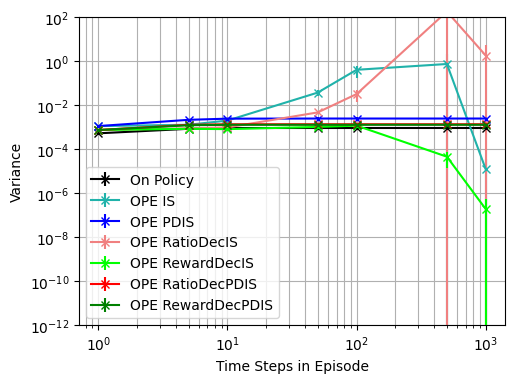

In [ ]:
vars1 = {'On Policy': [0.0005006491000000001, 0.0008685554601657704, 0.0009475327860100351, 0.0009529765512548791, 0.000952976542495385, 0.000952976542495386, 0.000952976542495386],
         'OPE IS': [0.00115229297664, 0.00144184099810092, 0.0019381744102469566, 0.031970629397222984, 0.6460018503849736, 0.0788756962648896, 2.114760934671364e-11],
         'OPE PDIS': [0.00115229297664, 0.002395852162460963, 0.0027264699187032337, 0.0027500059113419266, 0.002750006035751812, 0.002750006035751813, 0.002750006035751813],
         'OPE RatioDecIS': [0.0007610394999999987, 0.0009933150190962214, 0.0010533461996246538, 0.004659766421402421, 0.027287119924754966, 51.63547693183275, 0.003724383189914122],
         'OPE RewardDecIS': [0.0007639944313617306, 0.0009385516415324625, 0.0008634062841018849, 0.0009723348417041604, 0.001266100758225104, 3.2232331614325015e-05, 1.3741405534447208e-09],
         'OPE RatioDecPDIS': [0.0007610394999999987, 0.001418126681586638, 0.0015105569005267544, 0.0015139669314025985, 0.0015139669524682725, 0.0015139669524682731, 0.0015139669524682731],
         'OPE RewardDecPDIS': [0.0007639944313617306, 0.0013634672298938322, 0.001430328762867924, 0.0014297325945582561, 0.0014297326062922308, 0.001429732606292231, 0.001429732606292231]}


vars2 ={'On Policy': [0.0005006491000000001, 0.0008685554601657704, 0.0009475327860100351, 0.0009529765512548791, 0.000952976542495385, 0.000952976542495386, 0.000952976542495386],
        'OPE IS': [0.00115229297664, 0.00144184099810092, 0.0019381744102469566, 0.031970629397222984, 0.6460018503849736, 0.0788756962648896, 2.114760934671364e-11],
        'OPE PDIS': [0.00115229297664, 0.002395852162460963, 0.0027264699187032337, 0.0027500059113419266, 0.002750006035751812, 0.002750006035751813, 0.002750006035751813],
        'OPE RatioDecIS': [0.0007610394999999987, 0.0009933150190962214, 0.0010533461996246538, 0.004659766421402421, 0.027287119924754966, 51.63547693183275, 0.003724383189914122],
        'OPE RewardDecIS': [0.0007639944313617306, 0.0009385516415324625, 0.0008634062841018849, 0.0009723348417041604, 0.001266100758225104, 3.2232331614325015e-05, 1.3741405534447208e-09],
        'OPE RatioDecPDIS': [0.0007610394999999987, 0.001418126681586638, 0.0015105569005267544, 0.0015139669314025985, 0.0015139669524682725, 0.0015139669524682731, 0.0015139669524682731],
        'OPE RewardDecPDIS': [0.0007639944313617306, 0.0013634672298938322, 0.001430328762867924, 0.0014297325945582561, 0.0014297326062922308, 0.001429732606292231, 0.001429732606292231]}

vars3 = {'On Policy': [0.0006117100000000011, 0.0008887448309889789, 0.0009865710059715038, 0.0009701196474218429, 0.0009701196452031742, 0.0009701196452031749, 0.0009701196452031749],
         'OPE IS': [0.000889406208, 0.0011309652737600641, 0.0015589081013627232, 0.05724052887363418, 0.15604358198752494, 0.01022043220965486, 9.179531388705651e-10],
         'OPE PDIS': [0.000889406208, 0.0018638580485861767, 0.002059654551637367, 0.002098617655863482, 0.0020986176041049593, 0.0020986176041049623, 0.0020986176041049623],
         'OPE RatioDecIS': [0.0006072426560000002, 0.0007185440384686965, 0.0007041813000318348, 0.005213873103418607, 0.066908693351335, 5.840128217242442, 0.007175114682102682],
         'OPE RewardDecIS': [0.0006074949540358542, 0.0006741985083000263, 0.0005847246573004967, 0.0011487548667645483, 0.001285257480413614, 3.6331902262750083e-05, 7.069601492792713e-09],
         'OPE RatioDecPDIS': [0.0006072426560000002, 0.0010316667913913462, 0.001106323276821728, 0.0011120470594249967, 0.0011120470564327154, 0.0011120470564327143, 0.0011120470564327143],
         'OPE RewardDecPDIS': [0.0006074949540358542, 0.0009929904047116364, 0.0010546545078494493, 0.0010581222150700836, 0.0010581222133927107, 0.00105812221339271, 0.00105812221339271]}

vars4 = {'On Policy': [0.0004195331000000006, 0.000698310702965099, 0.0007712113114173494, 0.0007804976176898304, 0.0007804976218941252, 0.0007804976218941255, 0.0007804976218941255],
         'OPE IS': [0.0011285798400000003, 0.0011735477446466907, 0.0022676864410902217, 0.031079311512944456, 0.44751570358162895, 0.0031166160695243216, 6.046838113289105e-05],
         'OPE PDIS': [0.0011285798400000003, 0.002166457337614575, 0.0025362166796767094, 0.0025659917370649404, 0.002565991698423993, 0.0025659916984239668, 0.0025659916984239668],
         'OPE RatioDecIS': [0.0007249263999999992, 0.0008708251150335871, 0.0010802580638880502, 0.004454220895125926, 0.015500861183358406, 0.40577465077592834, 8.642698266662956],
         'OPE RewardDecIS': [0.000729940913966053, 0.0008365577542271998, 0.0009181010520838223, 0.0010542447569534149, 0.0010622400098115666, 1.791295090626694e-05, 9.22073951269295e-07],
         'OPE RatioDecPDIS': [0.0007249263999999992, 0.001333095749080124, 0.0014686697635486162, 0.0014763280142677832, 0.0014763280027562781, 0.0014763280027562773, 0.0014763280027562773],
         'OPE RewardDecPDIS': [0.000729940913966053, 0.0012663563632594583, 0.0013826438252935896, 0.0013848899560581314, 0.0013848899523562028, 0.0013848899523562022, 0.0013848899523562022]}

vars5 = {'On Policy': [0.0005792264000000004, 0.0008693947489917307, 0.0008955613323152548, 0.0009120289987790549, 0.0009120289956136174, 0.0009120289956136172, 0.0009120289956136172],
         'OPE IS': [0.0012518645759999982, 0.0012082123137473462, 0.002234741415705895, 0.03323050928973665, 0.12304878568554772, 3.529958699854929, 7.281152351279609e-10],
         'OPE PDIS': [0.0012518645759999982, 0.0019187105578390429, 0.002074966681609499, 0.00212213010128254, 0.002122130088830832, 0.002122130088830831, 0.002122130088830831],
         'OPE RatioDecIS': [0.0008317406240000004, 0.0008446077987039654, 0.0009525948594044384, 0.004309961474790365, 0.02212256507823965, 786.6187950499523, 0.306908062031383],
         'OPE RewardDecIS': [0.0008345920898653723, 0.0008023040078480046, 0.0008280517525096933, 0.0009551229635007138, 0.0009627291862594799, 0.00010772226894475246, 5.2291541622079264e-09],
         'OPE RatioDecPDIS': [0.0008317406240000004, 0.001156986756342802, 0.0011324653411621552, 0.001133542938385133, 0.0011335429420939816, 0.0011335429420939805, 0.0011335429420939805],
         'OPE RewardDecPDIS': [0.0008345920898653723, 0.001107283012074263, 0.0010851751174907516, 0.001085241310228308, 0.0010852413137688991, 0.0010852413137688987, 0.0010852413137688987]}

vars = [vars1, vars2, vars3, vars4, vars5]

plot_graphs(vars, 'var', 10**(-12), 10**2)

In [ ]:
print_specific_mean_std(vars)

10 STEPS
[0.0001677946740973564, 0.00040765944315461955, 0.00044885334837717827, 0.0001926915824428623, 0.00024836025999558505, 0.0, 0.0]
[0.00033558934819471277, 0.0008153188863092391, 0.0008977066967543565, 0.00038538316488572464, 0.0004967205199911702, 0.0, 0.0]

1000 STEPS
[0.00016835009271367896, 8.328355140148818e-12, 0.0004627501815233502, 0.0038649510479346976, 0.0002519773806812488, 0.0, 0.0]
[0.00033670018542735793, 1.6656710280297632e-11, 0.0009255003630467006, 0.007729902095869394, 0.0005039547613624975, 0.0, 0.0]


#### MSE

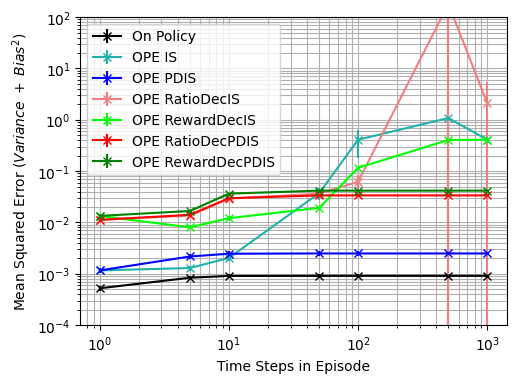

In [ ]:
MSEs1 = {'On Policy': [0.0005006491000000002, 0.0008685554601657705, 0.0009475327860100349, 0.0009529765512548785, 0.0009529765424953847, 0.0009529765424953855, 0.0009529765424953855],
         'OPE IS': [0.0012498204519999984, 0.0014603187739686344, 0.002018290091085019, 0.03197065427643145, 0.6465928198638021, 0.4452187600130083, 0.41039311916838467],
         'OPE PDIS': [0.0012498204519999984, 0.00240611172737124, 0.0027447648446004614, 0.0027649655262459855, 0.002764965645825101, 0.002764965645825101, 0.002764965645825101],
         'OPE RatioDecIS': [0.012563689099999982, 0.013028106239082708, 0.027811731497990367, 0.034709249544269155, 0.056207418313629465, 51.8202735009237, 0.39061425715362963],
         'OPE RewardDecIS': [0.014867939892071445, 0.007591292668910756, 0.011282212686487512, 0.020173903498750288, 0.11737985652968043, 0.40502532264869406, 0.4103769161970005],
         'OPE RatioDecPDIS': [0.012563689099999982, 0.013556046266098616, 0.02881297904920583, 0.032803427578448494, 0.03280343019017324, 0.03280343019017328, 0.03280343019017328],
         'OPE RewardDecPDIS': [0.014867939892071445, 0.016160293071957522, 0.03547981148884955, 0.040735745103351276, 0.04073574929657196, 0.04073574929657203, 0.04073574929657203]}

MSEs2 = {'On Policy': [0.0005006491000000002, 0.0008685554601657705, 0.0009475327860100349, 0.0009529765512548785, 0.0009529765424953847, 0.0009529765424953855, 0.0009529765424953855],
         'OPE IS': [0.0012498204519999984, 0.0014603187739686344, 0.002018290091085019, 0.03197065427643145, 0.6465928198638021, 0.4452187600130083, 0.41039311916838467],
         'OPE PDIS': [0.0012498204519999984, 0.00240611172737124, 0.0027447648446004614, 0.0027649655262459855, 0.002764965645825101, 0.002764965645825101, 0.002764965645825101],
         'OPE RatioDecIS': [0.012563689099999982, 0.013028106239082708, 0.027811731497990367, 0.034709249544269155, 0.056207418313629465, 51.8202735009237, 0.39061425715362963],
         'OPE RewardDecIS': [0.014867939892071445, 0.007591292668910756, 0.011282212686487512, 0.020173903498750288, 0.11737985652968043, 0.40502532264869406, 0.4103769161970005],
         'OPE RatioDecPDIS': [0.012563689099999982, 0.013556046266098616, 0.02881297904920583, 0.032803427578448494, 0.03280343019017324, 0.03280343019017328, 0.03280343019017328],
         'OPE RewardDecPDIS': [0.014867939892071445, 0.016160293071957522, 0.03547981148884955, 0.040735745103351276, 0.04073574929657196, 0.04073574929657203, 0.04073574929657203]}

MSEs3 = {'On Policy': [0.0006117100000000013, 0.0008887448309889787, 0.0009865710059715033, 0.0009701196474218429, 0.0009701196452031742, 0.0009701196452031745, 0.0009701196452031745],
         'OPE IS': [0.000904429584000001, 0.0011342188434028415, 0.0015610752363436143, 0.057389559946235645, 0.15824143395147433, 0.40108362384872653, 0.40743926387018226],
         'OPE PDIS': [0.000904429584000001, 0.001863916540145267, 0.002062520705111326, 0.002100671709856527, 0.002100671658107269, 0.002100671658107271, 0.002100671658107271],
         'OPE RatioDecIS': [0.009863991599999991, 0.01372657162851772, 0.028627253685378343, 0.04004441263693792, 0.1067132801808266, 5.842887734615141, 0.3839325102950689],
         'OPE RewardDecIS': [0.011914640728323558, 0.008061133591329287, 0.01186322998019747, 0.017782369660004474, 0.11340253616238417, 0.40218177390284643, 0.4074241497847091],
         'OPE RatioDecPDIS': [0.009863991599999991, 0.013789796444252734, 0.028981425271494176, 0.03292164245138256, 0.032921645071158606, 0.032921645071158634, 0.032921645071158634],
         'OPE RewardDecPDIS': [0.011914640728323558, 0.01652326878983909, 0.03583189552725307, 0.04104971962397912, 0.04104972385876939, 0.04104972385876946, 0.04104972385876946]}

MSEs4 = {'On Policy': [0.0004195331000000007, 0.0006983107029650986, 0.0007712113114173498, 0.0007804976176898303, 0.0007804976218941251, 0.0007804976218941252, 0.0007804976218941252],
         'OPE IS': [0.001133660356, 0.0012094257864478312, 0.0023427679821752044, 0.031163579805110624, 0.468224216307253, 0.3930959560971643, 0.4065134591466556],
         'OPE PDIS': [0.001133660356, 0.0022537341058018055, 0.0026404198211075207, 0.0026679021258496386, 0.0026679021069854706, 0.0026679021069854402, 0.0026679021069854402],
         'OPE RatioDecIS': [0.011045454499999989, 0.015137682153977152, 0.032305314538676834, 0.03607435224710956, 0.04220406834556855, 0.4726410340637195, 8.729174165787288],
         'OPE RewardDecIS': [0.013217695641040823, 0.009107745196063626, 0.013917626571990749, 0.018590669871117963, 0.11553889872550993, 0.4019109296220564, 0.40731069843127216],
         'OPE RatioDecPDIS': [0.011045454499999989, 0.01598814647378483, 0.03310356156594816, 0.03725047878604779, 0.037250481615351806, 0.03725048161535187, 0.03725048161535187],
         'OPE RewardDecPDIS': [0.013217695641040823, 0.01874640050526407, 0.04011460676563576, 0.04558989744009032, 0.04558990193620098, 0.0455899019362011, 0.0455899019362011]}

MSEs5 = {'On Policy': [0.0005792264000000004, 0.0008693947489917306, 0.0008955613323152548, 0.0009120289987790553, 0.0009120289956136176, 0.0009120289956136171, 0.0009120289956136171],
         'OPE IS': [0.0012747512319999984, 0.0012126194911774683, 0.0022394977072444657, 0.03332587211977234, 0.12856495088592632, 3.7216459462772655, 0.41473701023704124],
         'OPE PDIS': [0.0012747512319999984, 0.0019348787602540395, 0.0021054898998231707, 0.0021542608457775355, 0.002154260836899255, 0.002154260836899255, 0.002154260836899255],
         'OPE RatioDecIS': [0.010147078880000014, 0.013217299574513926, 0.029120310399825634, 0.03623345822664597, 0.04825827235357329, 792.6663843331936, 0.6148982966850469],
         'OPE RewardDecIS': [0.012189166040873398, 0.007720400792955901, 0.012131563303697175, 0.019455507725223357, 0.11559715465832468, 0.4073171231194296, 0.41471600755504845],
         'OPE RatioDecPDIS': [0.010147078880000014, 0.013503244686961388, 0.028576580620569794, 0.03244326398371369, 0.03244326646177226, 0.03244326646177226, 0.03244326646177226],
         'OPE RewardDecPDIS': [0.012189166040873398, 0.016086319774082633, 0.035195438469891954, 0.04032023444349104, 0.04032023860746176, 0.040320238607461784, 0.040320238607461784]}

MSEs = [MSEs1, MSEs2, MSEs3, MSEs4, MSEs5]

plot_graphs(MSEs, 'MSE', 10**(-4), 10**2)

In [ ]:
print_specific_mean_std(MSEs)

10 STEPS
[0.0001677946740973564, 0.00040826825109762776, 0.0004496795590366807, 0.006023418057059679, 0.006056590960250377, 0.0, 0.0]
[0.00033558934819471277, 0.0008165365021952555, 0.0008993591180733614, 0.012046836114119358, 0.012113181920500754, 0.0, 0.0]

1000 STEPS
[0.00016835009271367896, 0.0818835708077736, 0.0004637486290673858, 0.07705069576569898, 0.006868926643532572, 0.0, 0.0]
[0.00033670018542735793, 0.1637671416155472, 0.0009274972581347716, 0.15410139153139796, 0.013737853287065142, 0.0, 0.0]


#### ESS

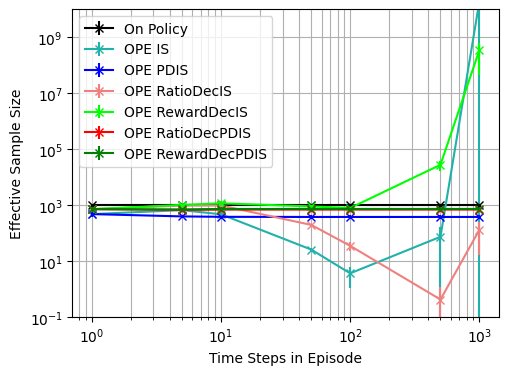

In [ ]:
vars1 = {'On Policy': [0.0005006491000000001, 0.0008685554601657704, 0.0009475327860100351, 0.0009529765512548791, 0.000952976542495385, 0.000952976542495386, 0.000952976542495386],
         'OPE IS': [0.00115229297664, 0.00144184099810092, 0.0019381744102469566, 0.031970629397222984, 0.6460018503849736, 0.0788756962648896, 2.114760934671364e-11],
         'OPE PDIS': [0.00115229297664, 0.002395852162460963, 0.0027264699187032337, 0.0027500059113419266, 0.002750006035751812, 0.002750006035751813, 0.002750006035751813],
         'OPE RatioDecIS': [0.0007610394999999987, 0.0009933150190962214, 0.0010533461996246538, 0.004659766421402421, 0.027287119924754966, 51.63547693183275, 0.003724383189914122],
         'OPE RewardDecIS': [0.0007639944313617306, 0.0009385516415324625, 0.0008634062841018849, 0.0009723348417041604, 0.001266100758225104, 3.2232331614325015e-05, 1.3741405534447208e-09],
         'OPE RatioDecPDIS': [0.0007610394999999987, 0.001418126681586638, 0.0015105569005267544, 0.0015139669314025985, 0.0015139669524682725, 0.0015139669524682731, 0.0015139669524682731],
         'OPE RewardDecPDIS': [0.0007639944313617306, 0.0013634672298938322, 0.001430328762867924, 0.0014297325945582561, 0.0014297326062922308, 0.001429732606292231, 0.001429732606292231]}

ESS1 = calculate_ESS(vars1, 1000)


vars2 ={'On Policy': [0.0005006491000000001, 0.0008685554601657704, 0.0009475327860100351, 0.0009529765512548791, 0.000952976542495385, 0.000952976542495386, 0.000952976542495386],
        'OPE IS': [0.00115229297664, 0.00144184099810092, 0.0019381744102469566, 0.031970629397222984, 0.6460018503849736, 0.0788756962648896, 2.114760934671364e-11],
        'OPE PDIS': [0.00115229297664, 0.002395852162460963, 0.0027264699187032337, 0.0027500059113419266, 0.002750006035751812, 0.002750006035751813, 0.002750006035751813],
        'OPE RatioDecIS': [0.0007610394999999987, 0.0009933150190962214, 0.0010533461996246538, 0.004659766421402421, 0.027287119924754966, 51.63547693183275, 0.003724383189914122],
        'OPE RewardDecIS': [0.0007639944313617306, 0.0009385516415324625, 0.0008634062841018849, 0.0009723348417041604, 0.001266100758225104, 3.2232331614325015e-05, 1.3741405534447208e-09],
        'OPE RatioDecPDIS': [0.0007610394999999987, 0.001418126681586638, 0.0015105569005267544, 0.0015139669314025985, 0.0015139669524682725, 0.0015139669524682731, 0.0015139669524682731],
        'OPE RewardDecPDIS': [0.0007639944313617306, 0.0013634672298938322, 0.001430328762867924, 0.0014297325945582561, 0.0014297326062922308, 0.001429732606292231, 0.001429732606292231]}

ESS2 = calculate_ESS(vars2, 1000)

vars3 = {'On Policy': [0.0006117100000000011, 0.0008887448309889789, 0.0009865710059715038, 0.0009701196474218429, 0.0009701196452031742, 0.0009701196452031749, 0.0009701196452031749],
         'OPE IS': [0.000889406208, 0.0011309652737600641, 0.0015589081013627232, 0.05724052887363418, 0.15604358198752494, 0.01022043220965486, 9.179531388705651e-10],
         'OPE PDIS': [0.000889406208, 0.0018638580485861767, 0.002059654551637367, 0.002098617655863482, 0.0020986176041049593, 0.0020986176041049623, 0.0020986176041049623],
         'OPE RatioDecIS': [0.0006072426560000002, 0.0007185440384686965, 0.0007041813000318348, 0.005213873103418607, 0.066908693351335, 5.840128217242442, 0.007175114682102682],
         'OPE RewardDecIS': [0.0006074949540358542, 0.0006741985083000263, 0.0005847246573004967, 0.0011487548667645483, 0.001285257480413614, 3.6331902262750083e-05, 7.069601492792713e-09],
         'OPE RatioDecPDIS': [0.0006072426560000002, 0.0010316667913913462, 0.001106323276821728, 0.0011120470594249967, 0.0011120470564327154, 0.0011120470564327143, 0.0011120470564327143],
         'OPE RewardDecPDIS': [0.0006074949540358542, 0.0009929904047116364, 0.0010546545078494493, 0.0010581222150700836, 0.0010581222133927107, 0.00105812221339271, 0.00105812221339271]}

ESS3 = calculate_ESS(vars3, 1000)

vars4 = {'On Policy': [0.0004195331000000006, 0.000698310702965099, 0.0007712113114173494, 0.0007804976176898304, 0.0007804976218941252, 0.0007804976218941255, 0.0007804976218941255],
         'OPE IS': [0.0011285798400000003, 0.0011735477446466907, 0.0022676864410902217, 0.031079311512944456, 0.44751570358162895, 0.0031166160695243216, 6.046838113289105e-05],
         'OPE PDIS': [0.0011285798400000003, 0.002166457337614575, 0.0025362166796767094, 0.0025659917370649404, 0.002565991698423993, 0.0025659916984239668, 0.0025659916984239668],
         'OPE RatioDecIS': [0.0007249263999999992, 0.0008708251150335871, 0.0010802580638880502, 0.004454220895125926, 0.015500861183358406, 0.40577465077592834, 8.642698266662956],
         'OPE RewardDecIS': [0.000729940913966053, 0.0008365577542271998, 0.0009181010520838223, 0.0010542447569534149, 0.0010622400098115666, 1.791295090626694e-05, 9.22073951269295e-07],
         'OPE RatioDecPDIS': [0.0007249263999999992, 0.001333095749080124, 0.0014686697635486162, 0.0014763280142677832, 0.0014763280027562781, 0.0014763280027562773, 0.0014763280027562773],
         'OPE RewardDecPDIS': [0.000729940913966053, 0.0012663563632594583, 0.0013826438252935896, 0.0013848899560581314, 0.0013848899523562028, 0.0013848899523562022, 0.0013848899523562022]}

ESS4 = calculate_ESS(vars4, 1000)

vars5 = {'On Policy': [0.0005792264000000004, 0.0008693947489917307, 0.0008955613323152548, 0.0009120289987790549, 0.0009120289956136174, 0.0009120289956136172, 0.0009120289956136172],
         'OPE IS': [0.0012518645759999982, 0.0012082123137473462, 0.002234741415705895, 0.03323050928973665, 0.12304878568554772, 3.529958699854929, 7.281152351279609e-10],
         'OPE PDIS': [0.0012518645759999982, 0.0019187105578390429, 0.002074966681609499, 0.00212213010128254, 0.002122130088830832, 0.002122130088830831, 0.002122130088830831],
         'OPE RatioDecIS': [0.0008317406240000004, 0.0008446077987039654, 0.0009525948594044384, 0.004309961474790365, 0.02212256507823965, 786.6187950499523, 0.306908062031383],
         'OPE RewardDecIS': [0.0008345920898653723, 0.0008023040078480046, 0.0008280517525096933, 0.0009551229635007138, 0.0009627291862594799, 0.00010772226894475246, 5.2291541622079264e-09],
         'OPE RatioDecPDIS': [0.0008317406240000004, 0.001156986756342802, 0.0011324653411621552, 0.001133542938385133, 0.0011335429420939816, 0.0011335429420939805, 0.0011335429420939805],
         'OPE RewardDecPDIS': [0.0008345920898653723, 0.001107283012074263, 0.0010851751174907516, 0.001085241310228308, 0.0010852413137688991, 0.0010852413137688987, 0.0010852413137688987]}

ESS5 = calculate_ESS(vars5, 1000)

ESS = [ESS1, ESS2, ESS3, ESS4, ESS5]

plot_graphs(ESS, 'ESS', 10**(-1), 10**10)

In [ ]:
print_specific_mean_std(ESS)